In [1]:
import os
import dill
import random
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import sentence_bleu as bleu
from nltk.translate.bleu_score import SmoothingFunction

from utils import *
from seq2seq_data_loader import *

SMOOTH = SmoothingFunction()

In [2]:
loader = Seq2SeqDataLoader('mscoco/')
indexer, trainPairs, trainLens, testPairs, testLens = loader.load(specialTokenList=['EOS','SOS','PAD','UNK'])

... loading training data.
... loading test data.
Done!



In [3]:
%%time

glovePath = "glove_embeddings/glove.6B.300d.txt"
embeddings = np.zeros((indexer.size,300)) 
word2embedding = {}
count = 0
print "Reading embeddings ..."
with open(glovePath, 'r') as f:
    for line in f:
        count += 1
        line = line.split()
        word = line[0]
        embedding = np.array(line[1:], dtype=float)
        word2embedding[word] = embedding
        if count%10000==0:
            print '... processed %d lines.' % count
print "\nLoading embeddings to matrix ..."
oovSize = 0
for i in range(indexer.size): 
    word = indexer.get_word(i)
    if word in word2embedding:
        embeddings[i] = word2embedding[word]
    else:
        embeddings[i] = np.zeros(300)
        oovSize += 1
print "Done (#oov = %d)" % oovSize
del word2embedding

Reading embeddings ...
... processed 10000 lines.
... processed 20000 lines.
... processed 30000 lines.
... processed 40000 lines.
... processed 50000 lines.
... processed 60000 lines.
... processed 70000 lines.
... processed 80000 lines.
... processed 90000 lines.
... processed 100000 lines.
... processed 110000 lines.
... processed 120000 lines.
... processed 130000 lines.
... processed 140000 lines.
... processed 150000 lines.
... processed 160000 lines.
... processed 170000 lines.
... processed 180000 lines.
... processed 190000 lines.
... processed 200000 lines.
... processed 210000 lines.
... processed 220000 lines.
... processed 230000 lines.
... processed 240000 lines.
... processed 250000 lines.
... processed 260000 lines.
... processed 270000 lines.
... processed 280000 lines.
... processed 290000 lines.
... processed 300000 lines.
... processed 310000 lines.
... processed 320000 lines.
... processed 330000 lines.
... processed 340000 lines.
... processed 350000 lines.
... pr

In [7]:
# NB: shorthand shape annotation. 
#   `mt` = max-time/sequence-length; 
#   `bc` = batch-size; 
#   `emb` = embedding-size;
#   `h` = hidden-size;
#   `n_layer`, `n_dir`: #layers, #directions.

class Encoder(nn.Module):
    """GRU encoder"""
    
    def __init__(self, inputSize, embeddingSize, hiddenSize, 
                 nLayers=2, dropout=0.1, bidirectional=True, gloveInit=np.array([])):
        """
        
        Args:
            inputSize: vocabulary size.
            embeddingSize: size of word embedding.
            hiddenSize: size of RNN hidden state.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            bidirectional: boolean.
            gloveInit: numpy.ndarray. Default is empty.
        """
        super(Encoder, self).__init__()
        # save params
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.embeddingSize = embeddingSize
        self.gloveInit = gloveInit
        self.nLayers = nLayers
        self.dropout = dropout
        self.bidirectional = bidirectional
        # build arc
        if len(self.gloveInit)>0:
            assert len(self.gloveInit)==self.inputSize
            self.embeddingSize = self.gloveInit.shape[1]
            self.embeddings = nn.Embedding(self.inputSize, self.embeddingSize)
            self.embeddings.weight.data.copy_(torch.from_numpy(self.gloveInit))
            del self.gloveInit
        else:
            self.embeddings = nn.Embedding(self.inputSize, self.embeddingSize)
        self.gru = nn.GRU(self.embeddingSize, self.hiddenSize, 
                          num_layers=self.nLayers, dropout=self.dropout, bidirectional=self.bidirectional)
    
    def forward(self, batchInput, batchLen, hidden=None):
        """
        
        Args:
            batchInputs: shape = <max-time(enc),batch-size>.
            batchLen: shape = <batch-size,>.
            hidden: input hidden state (initialized as None).
        """
        # bi: <mt-enc,bc>
        # bl: <bc,>
        embedded = self.embeddings(batchInput)
            # lookup: <mt-enc,bc> -> <mt-enc,bc,emb>
        packedInput = torch.nn.utils.rnn.pack_padded_sequence(embedded, batchLen)
            # 'packed' has a 'data' and a 'batch_sizes' field.
            #   'data' is a <sum(len),emb> matrix (len is real lengths, not padded).
            #   'batch_sizes' has the number of non-zero batches at each time-step.
            # e.g. for this 'inputs'
            #    2     1     3     0     2
            #    6     8     1     6     2
            #    0     7     0     8     8
            #    6     4     2     1     1
            #    1     8     1     1     1
            #    6     1     1     1     1
            #    0     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1  
            # 'data' = 22 = 7+5+4+3+3 (1's are pads corresponding to 'EOS').
            # 'batch_sizes' = [5, 5, 5, 3, 2, 1, 1].
        packedOutput, hidden = self.gru(packedInput, hidden)
            # packedOutput: <sum(bl),h*n_dir>; hidden: <n_layer*n_dir,bc,h>
        batchOutput, batchLen = torch.nn.utils.rnn.pad_packed_sequence(packedOutput)
            # batchOutput: <mt-enc,bc,h*n_dir>
            # batchLen: <bc,>      
        if self.bidirectional:
            batchOutput = torch.cat((batchOutput[:,:,:self.hiddenSize],
                                     batchOutput[:,:,self.hiddenSize:]),dim=-1)
                # <mt-enc,bc,h> cat <mt-enc,bc,h> -> <mt-enc,bc,h*n_dir=2h>
            hidden = torch.cat((hidden[:self.nLayers,:,:],
                                hidden[self.nLayers:,:,:]),dim=-1)
                # <n_layer,bc,h> cat <n_layer,bc,h> -> <n_layer,bc,h*n_dir=2h>
        return batchOutput, hidden
            # batchOutput: <mt-enc,bc,h*n_dir=2h>
            # hidden: <n_layer,bc,h*n_dir=2h>

class Attention(nn.Module):
    """Attention layer. https://github.com/tensorflow/nmt"""
    # Source: https://github.com/tensorflow/nmt
    
    def __init__(self, hiddenSize, attentionType='bahdanau'):
        """
        
        Args:
            hiddenSize: hidden size of the decoder.
            attentionType: `bahdanau` or `luong`.
        """
        super(Attention, self).__init__()
        # save params
        self.hiddenSize = hiddenSize
        self.attentionType = attentionType
        # layers for Bahdanau
        self.encoderLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        self.decoderLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        self.tanh = nn.Tanh()
        self.v = nn.Parameter(torch.rand(self.hiddenSize,1))
        # layers for Luong
        self.biLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        # general layer
        self.linear = nn.Linear(self.hiddenSize*2, self.hiddenSize)
    
    def bahdanau_score(self, encoderOutput, decoderHidden):
        """Bahdanau et al. (2015).
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            The `score` as the second in Eq.4 in the nmt tutorial.
        """
        # eo: <bc,mt-enc,h> =here= <bc,mt-enc,h>
        # dh: <bc,n_layer,h> =here= <bc,1,h>        
        return torch.matmul(self.tanh(self.encoderLinear(encoderOutput)+\
                                      self.decoderLinear(decoderHidden)),self.v).transpose(1,2)
            # op1. enc-o -> <bc,mt-enc,h>; dec-h -> <bc,1,h>; add -> <bc,mt-enc,h>
            # op2. tanh, shapes retain
            # op3. <bc,mt-enc,h> x <h,1> -> <bc,mt-enc,1>
            # op4. <bc,mt-enc,1> -> <bc,1,mt-enc> (convenient weighted-sum later)
    
    def luong_score(self, encoderOutput, decoderHidden):
        """Luong et al. (2016), `Global attention`.
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            The `score` as the first in Eq.4 in the nmt tutorial.        
        """
        # eo: <bc,mt-enc,h> =here= <bc,mt-enc,h>
        # dh: <bc,n_layer,h> =here= <bc,1,h> 
        return torch.bmm(self.biLinear(encoderOutput), decoderHidden.transpose(1,2)).transpose(1,2)
            # op1. linear on encoderOutput: <bc,mt-enc,h> -> <bc,mt-enc,h>
            # op2. decoderHidden transpose for bmm: <bc,1,h> -> <bc,h,1>
            # op3. bmm: <bc,mt-enc,h> x <bc,h,1> -> <bc,mt-enc,1>
            # op4. <bc,mt-enc,1> -> <bc,1,mt-enc> (convenient weighted-sum later)
    
    def score(self, encoderOutput, decoderHidden, attentionType):
        """Attention score by type.
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
            attentionType: `bahdanau` or `luong`.
        Returns:
            Score of chosen type.
        """
        assert attentionType in ['bahdanau','luong']
        if attentionType=='bahdanau':
            return self.bahdanau_score(encoderOutput, decoderHidden)
        return self.luong_score(encoderOutput, decoderHidden)
        
    def forward(self, encoderOutput, decoderHidden):
        """
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            a batch of attention vectors (as per Eq.3 in the nmt tutorial). 
        """
        # eo: <mt-enc,bc,h> =here= <mt-enc,bc,h>
        # dh: <n_layer,bc,h> =here= <1,bc,h>
        encoderOutput = encoderOutput.transpose(0,1) # <bc,mt-enc,h>
        decoderHidden = decoderHidden.transpose(0,1) # <bc,1,h>
        attentionWeights = F.softmax(self.score(encoderOutput, decoderHidden, self.attentionType),dim=-1)
            # <bc,1,mt-enc>, where sum by mt-end = 1.
        context = torch.bmm(attentionWeights, encoderOutput).squeeze()
            # op1. batch matmul: <bc,1,mt-enc> x <bc,mt-enc,h> -> <bc,1,h>
            # op2. <bc,1,h> -> <bc,h>
        return self.tanh(self.linear(torch.cat((context,decoderHidden.squeeze()),dim=-1))), \
               attentionWeights.squeeze()
            # return arg1
            #   op1. decoderHidden squeeze: <bc,1,h> -> <bc,h>
            #   op2. concat: <bc,h> cat <bc,h> -> <bc,2h>
            #   op3. final linear layer: <bc,2h> -> <bc,h>
            #   op4. final nonlinear: dim retain
            # return arg2
            #   <bc,mt-enc> attention matrix for visualization

class AttentionDecoder(nn.Module):
    
    def __init__(self, outputSize, embeddingSize, hiddenSize, attentionType='bahdanau',
                 nLayers=2, dropout=0.1, residual=True, gloveInit=np.array([])):
        """
        
        Args:
            outputSize: vocabulary size.
            embeddingSize: size of word embedding.
            hiddenSize: GRU hidden state size.
            attentionType: `bahdanau` or `luong`.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            residual: boolean, whether establish residual link (to top layer) or not.
            gloveInit: numpy.ndarray. Default is empty.
        """        
        # NB: hiddenSize should double if the encoder is bidirectional.
        super(AttentionDecoder, self).__init__()
        # save params
        self.outputSize = outputSize
        self.embeddingSize = embeddingSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.dropout = dropout
        self.residual = residual
        self.gloveInit = gloveInit
        # layers
        if len(self.gloveInit)>0:
            assert len(self.gloveInit)==self.outputSize
            self.embeddingSize = self.gloveInit.shape[1]
            self.embeddings = nn.Embedding(self.outputSize, self.embeddingSize)
            self.embeddings.weight.data.copy_(torch.from_numpy(self.gloveInit))
            del self.gloveInit
        else:
            self.embeddings = nn.Embedding(self.outputSize, self.embeddingSize)
        self.gru = nn.GRU(self.embeddingSize, self.hiddenSize, num_layers=self.nLayers, dropout=self.dropout)
        self.residualLinear = nn.Linear(self.embeddingSize, self.hiddenSize)
        self.attention = Attention(self.hiddenSize, attentionType).cuda()
        self.linear = nn.Linear(self.hiddenSize, self.outputSize) 
        self.tanh = nn.Tanh()
        self.logSoftmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, batchSingleInput, encoderOutput, prevHidden):
        # bsi: <bc,>
        # eo: <mt-enc,bc,h> =here= <mt-enc,bc,h>
        # ph: <n_layer,bc,h> =here= <1,bc,h>
        embedded = self.embeddings(batchSingleInput).unsqueeze(0)
            # op1. lookup: <bc,> -> <bc,emb>
            # op2. conform to GRU input format: <mt=1,bc,emb>
        batchSingleOutput, hidden = self.gru(embedded, prevHidden)
            # batchSingleOutput: <mt=1,bc,h>
            # hidden: <n_layer,bc,h>
        if self.residual:
            hidden = hidden + self.residualLinear(embedded)
                # op1. map input to correct space (in last dim): emb -> h
                # op2. broadcase elemwise addition
                #   <n_layer,bc,h> + <1,bc,h> = <n_layer,bc,h>
        batchAttentionVector, attentionWeights = self.attention(encoderOutput, 
                                                                hidden[-1].unsqueeze(0))
            # batchAttentionVector: <bc,2h>
            # attentionWeights: <bc,mt-enc>
            # NB: for hidden we only take the state from the last layer
        batchSingleOutput = self.logSoftmax(self.linear(batchAttentionVector))
            # op1. linear: <bc,h> -> <bc,vocab>
            # op2. log-softmax over vocab
        return batchSingleOutput, hidden, attentionWeights
            # batchSingleOutput: <bc,vocab>
            # hidden: <1,bc,h>
            # attentionWeights: <bc,mt-enc>

class Seq2Seq:
    
    def __init__(self, indexer, trainPairs, trainLens, testPairs, testLens,
                 attentionType='luong',
                 batchSize=128, embeddingSize=300, hiddenSize=100,
                 nLayers=2, dropout=0.1, residual=True, bidirectional=True,
                 lr=1e-4, enforcingRatio=0.5, clip=10.0,
                 gloveInit=np.array([]),
                 resultSavePath='mscoco/results.txt'):
        self.indexer = indexer
        self.trainIter = DataIterator(indexer, trainPairs, trainLens)
        self.testIter = DataIterator(indexer, testPairs, testLens)
        self.attentionType=attentionType
        self.batchSize = batchSize
        self.embeddingSize = embeddingSize
        self.hiddenSize = hiddenSize
        self.nLayers=nLayers
        self.dropout=dropout
        self.residual=residual
        self.bidirectional=bidirectional
        self.lr = lr
        self.enforcingRatio = enforcingRatio
        self.clip = clip
        self.gloveInit = gloveInit
        self.resultSavePath = resultSavePath
        self._build_model()
    
    def _build_model(self):
        self.encoder = Encoder(self.indexer.size, self.embeddingSize, self.hiddenSize,
                               self.nLayers, self.dropout, self.bidirectional, self.gloveInit).cuda()
        self.decoder = AttentionDecoder(self.indexer.size, self.embeddingSize,
                                        self.hiddenSize*2 if self.bidirectional else self.hiddenSize,
                                        self.attentionType, self.nLayers, self.dropout, self.residual,
                                        self.gloveInit).cuda()
        del self.gloveInit
        self.encoderOptim = optim.Adam(self.encoder.parameters(), self.lr)
        self.decoderOptim = optim.Adam(self.decoder.parameters(), self.lr)
        self.criterion = nn.NLLLoss()

    def _model_config(self):
        return 'Vocab Size = ' + str(self.indexer.size) + '\n' + \
               'Train/Test Size = ' + str(self.trainIter.size)+'/'+str(self.testIter.size) + '\n' + \
               'AttentionType = ' + str(self.attentionType) + '\n' + \
               'batchSize = ' + str(self.batchSize) + '\n' + \
               'embeddingSize = ' + str(self.embeddingSize) + '; hiddenSize = ' + str(self.hiddenSize) + '\n' + \
               'nLayers = ' + str(self.nLayers) + '; dropout = ' + str(self.dropout) + '\n' + \
               'residual = ' + str(self.residual) + '; bidirectional = ' + str(self.bidirectional) + '\n' + \
               'learning rate = ' + str(self.lr) + '\n' + \
               'teacher enforce ratio = ' + str(self.enforcingRatio) + '; clip = ' + str(self.clip) + '\n\n'
    
    def _train_step(self):
        """One step of training."""
        inputs, inputsLen, targets, targetsLen = self.trainIter.random_batch(self.batchSize)
        inputs, targets = inputs.cuda(), targets.cuda()
        self.encoderOptim.zero_grad()
        self.decoderOptim.zero_grad()
        loss = 0
        # Run encoder
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen)
        # Run decoder 
        maxDecodingLen = max(targetsLen) # longest sent in output
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*self.batchSize)).cuda()
        decoderHidden = encoderHidden
        enforce = random.random() < self.enforcingRatio
        decoderOutputAll = Variable(torch.zeros(maxDecodingLen, self.batchSize, self.decoder.outputSize)).cuda()
        mask = torch.LongTensor([1]*self.batchSize).cuda()
        for di in range(maxDecodingLen):
            decoderOutput, decoderHidden, _ = self.decoder(decoderInput,encoderOutput,decoderHidden)
                # arg3 = attentionWeights, not needed here, no visualization.
            decoderOutputAll[di] = decoderOutput
            if enforce:
                decoderInput = targets[di]
            else:
                topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
                topIndices = topIndices.squeeze()# topIndices = <bc,>
                for b in range(self.batchSize):
                    if topIndices[b] == 0: # EOS
                        mask[b] = 0
                topIndices = topIndices * mask
                decoderInput = Variable(topIndices).cuda()
        # Batch cross entropy
            # requires arg1/pred = <#entries,vocab>, arg2/target = <#entries,>
        decoderOutputAll = decoderOutputAll.view(-1, self.decoder.outputSize)
            # reshape to <mt*bc,vocab>
        targets = targets.contiguous().view(-1)
            # reshape to <mt*bc>
        loss = self.criterion(decoderOutputAll, targets)
        # Backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm(self.encoder.parameters(), self.clip)
        torch.nn.utils.clip_grad_norm(self.decoder.parameters(), self.clip)
        self.encoderOptim.step()
        self.decoderOptim.step()
        return loss.data[0] / targetsLen.sum()
    
    def train(self, nEpochs=1, epochSize=100, printEvery=5, evalSize=5):
        """Train on loaded data upon construction.
        
        Args:
            nEpochs: number of epochs.
            epochSize: number of batches trained in an epoch.
            printEvery: frequency of results report.
            evalSize: how many samples to evaluate
        """
        globalStep = 0
        averageLoss = 0
        start = time.time()
        for e in range(nEpochs):
            epochLoss = 0
            for step in range(epochSize):
                loss = self._train_step()
                if step!=0 and step%printEvery==0:
                    print("Step %d average loss = %.6f (time: %.2f)" % (step, loss, # batch mean.
                                                                        time.time()-start))
                    start = time.time()
                epochLoss += loss
            epochLoss /= epochSize
            averageLoss += epochLoss
            print("\nEpoch %d loss = %.4f\n" % (e+1,epochLoss))
            averageBleu = self.evaluate_random(size=evalSize, saveResults=False, printResults=True)  

    def _clear_special_tokens(self, words):
        """Clear all the PAD, UNK, EOS to avoid inflated BLEU.
        
        Args:
            words: a list of tokens.
        Returns:
            a list of tokens which are not special tokens.
        """
        return [word for word in words if word not in set(["PAD","UNK","EOS","SOS"])]
    
    def evaluate_pair(self, predWords, targetWords):
        """Compute the BLEU score of a prediction given a reference.
        
        Args:
            predWords: predicted words (a list of strings).
            targetWords: reference, same type as preWords.
        Returns:
            The BLEU score (uses = nltk.translate.bleu_score.sentence_bleu).
        """
        return bleu([targetWords], 
                     predWords, smoothing_function=SMOOTH.method3)

    def _print_heatmap(self, attentionWeightsAll, inputs, predictions, targets):
        """Plot alignment heatmaps.
        
        Args:
            attentionWeightsAll: shape <bc,mt-dec=maxDecodingLen,mt-enc=inputsLen>
            inputs: <bc,mt-enc=inputsLen>
            predictions: <bc,mt-dec=maxDecodingLen>
            targets: <bc,mt-dec=targetsLen>
            NB: all types = numpy.ndarray.
        """

        print '=========== HEATMAPS =========='
        for aw,iw,pw,tw in zip(attentionWeightsAll,inputs,predictions,targets): # <mt,vocab>
            _, ax = plt.subplots()
            xticks = self.indexer.to_words(iw)
            yticks = [p+'-'+t for p,t in zip(self.indexer.to_words(pw),self.indexer.to_words(tw))]
            ax = sns.heatmap(aw)
            ax.xaxis.tick_top()
            ax.xaxis.set_ticklabels(xticks, rotation=90)
            ax.yaxis.set_ticklabels(yticks, rotation=0)
            plt.show()
        print '===============================\n\n'

    def evaluate_random(self, size, saveResults, printResults=True, endOfEpochPlot=True):
        """Randomly evaluate samples from the test set (which is loaded upon construction).
        
        Args:
            size: number of samples evaluated (as a single batch).
            printResults: print input, prediction and gold translation to console. (default=True)
        Returns:
            The average BLEU score in the batch.
        """
        self.encoder.eval()
        self.decoder.eval()
        inputs, inputsLen, targets, targetsLen = self.testIter.random_batch(size)
        inputs, targets = inputs.cuda(), targets.cuda()
        # Run encoder
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen)
        # Run decoder
        maxEncodingLen = inputs.size(0)  # longest sent in inputs
        maxDecodingLen = max(targetsLen)
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*size)).cuda()
        decoderHidden = encoderHidden
        predictions = []
        attentionWeightsAll = Variable(torch.zeros(maxDecodingLen, size, maxEncodingLen)).cuda()
        mask = torch.LongTensor([1]*size).cuda()
        for di in range(maxDecodingLen):
            decoderOutput, decoderHidden, attentionWeights = self.decoder(decoderInput, 
                                                                          encoderOutput,
                                                                          decoderHidden)
            attentionWeightsAll[di] = attentionWeights # set row di as <bc,mt-enc>
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            topIndices = topIndices.squeeze() # topIndices = <bc,>
            for b in range(size):
                if topIndices[b] == 0:
                    mask[b] = 0
            topIndices = topIndices * mask
            decoderInput = Variable(topIndices).cuda()
            predictions.append(topIndices.view(-1).cpu().numpy())
        
        attentionWeightsAll = np.array([aw.data.cpu().numpy() for aw in attentionWeightsAll])
        attentionWeightsAll = attentionWeightsAll.swapaxes(0,1) # <mt-dec,bc,mt-enc> -> <bc,mt-dec,mt-enc> 
        inputs = inputs.data.cpu().numpy().transpose()
        predictions = np.array(predictions).transpose() # <mt,bc> -> <bc,mt>
        targets = targets.data.cpu().numpy().transpose()
        if endOfEpochPlot:
            self._print_heatmap(attentionWeightsAll, inputs, predictions, targets)
        
        bleuList = []
        results = []
        for i,(input,pred,target) in enumerate(zip(inputs,predictions,targets)):
            inputWords = self._clear_special_tokens(self.indexer.to_words(input))
            predWords = self._clear_special_tokens(self.indexer.to_words(pred))
            targetWords = self._clear_special_tokens(self.indexer.to_words(target))
            bleuCurr = self.evaluate_pair(predWords, targetWords)
            bleuList.append(bleuCurr)
            inputSent = ' '.join(inputWords)
            predSent = ' '.join(predWords)
            targetSent = ' '.join(targetWords)
            results.append([inputSent, predSent, targetSent])
            if printResults:
                print("Example %d" % (i+1))
                print("INPUT >> %s" % inputSent)
                print("PRED >> %s" % predSent)
                print("TRUE >> %s" % targetSent)
                print("[BLEU] %.2f\n" % bleuCurr)
        averageBleu = np.mean(bleuList)
        if saveResults:
            return averageBleu, results
        return averageBleu

    def evaluate(self, nBatches=10, saveResults=True):
        """Randomly evaluate a given number of batches.
        
        Args:
            nBatches: the number of random batches to be evaluated.
        """
        averageBleuList = []
        for i in range(nBatches):
            if saveResults:
                averageBleu, results = self.evaluate_random(self.batchSize, saveResults, printResults=False,
                                                            endOfEpochPlot=False)
                averageBleuList.append(averageBleu)
                with open(self.resultSavePath, 'a') as f:
                    if i==0:
                        f.write(self._model_config())
                        f.write('=================================\n')
                    for input,pred,target in results:
                        f.write('INPUT  >> ' + input + '\n')
                        f.write('PRED   >> ' + pred + '\n')
                        f.write('TARGET >> ' + target + '\n\n')
            else:
                averageBleuList.append(self.evaluate_random(self.batchSize, saveResults, 
                                                            printResults=False, endOfEpochPlot=False))
        message = "Average BLEU score over %d examples is %.4f" % (self.batchSize*nBatches, 
                                                                   np.mean(averageBleuList))
        with open(self.resultSavePath, 'a') as f:
            f.write('=================================\n')
            f.write(message)
        print message

Step 50 average loss = 0.004352 (time: 10.98)
Step 100 average loss = 0.010558 (time: 9.95)
Step 150 average loss = 0.009412 (time: 9.79)
Step 200 average loss = 0.010605 (time: 9.89)
Step 250 average loss = 0.010520 (time: 10.48)
Step 300 average loss = 0.006492 (time: 10.47)
Step 350 average loss = 0.007500 (time: 10.04)
Step 400 average loss = 0.004906 (time: 9.58)
Step 450 average loss = 0.008836 (time: 10.01)
Step 500 average loss = 0.009572 (time: 10.19)
Step 550 average loss = 0.011412 (time: 10.72)
Step 600 average loss = 0.005300 (time: 9.85)
Step 650 average loss = 0.008305 (time: 9.95)
Step 700 average loss = 0.008493 (time: 9.97)
Step 750 average loss = 0.007294 (time: 10.11)
Step 800 average loss = 0.005884 (time: 10.30)
Step 850 average loss = 0.007497 (time: 9.96)
Step 900 average loss = 0.009327 (time: 9.70)
Step 950 average loss = 0.007229 (time: 10.04)

Epoch 1 loss = 0.0089

=========== HEATMAPS ==========


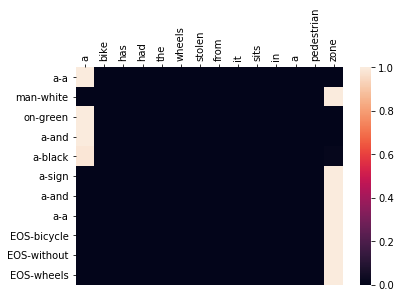

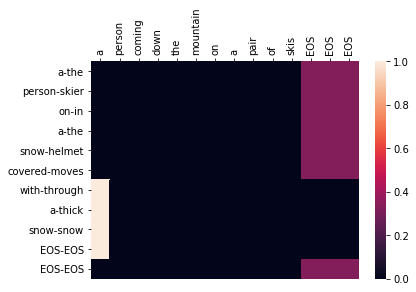

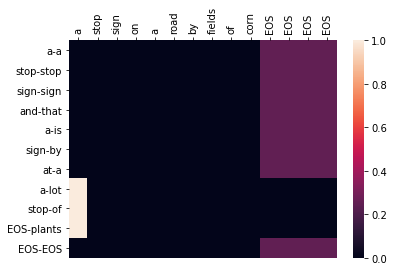

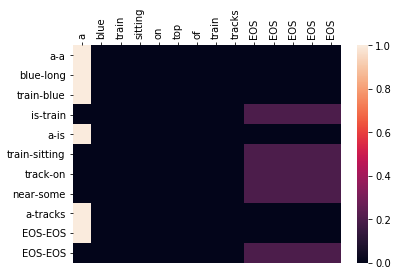

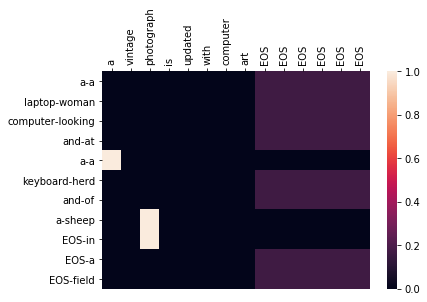



Example 1
INPUT >> a bike has had the wheels stolen from it sits in a pedestrian zone
PRED >> a man on a a a a a
TRUE >> a white green and black sign and a bicycle without wheels
[BLEU] 0.05

Example 2
INPUT >> a person coming down the mountain on a pair of skis
PRED >> a person on a snow covered with a snow
TRUE >> the skier in the helmet moves through thick snow
[BLEU] 0.05

Example 3
INPUT >> a stop sign on a road by fields of corn
PRED >> a stop sign and a sign at a stop
TRUE >> a stop sign that is by a lot of plants
[BLEU] 0.17

Example 4
INPUT >> a blue train sitting on top of train tracks
PRED >> a blue train is a train track near a
TRUE >> a long blue train is sitting on some tracks
[BLEU] 0.19

Example 5
INPUT >> a vintage photograph is updated with computer art
PRED >> a laptop computer and a keyboard and a
TRUE >> a woman looking at a herd of sheep in a field
[BLEU] 0.05

Step 50 average loss = 0.007003 (time: 20.73)
Step 100 average loss = 0.005515 (time: 9.48)
Step 150 a

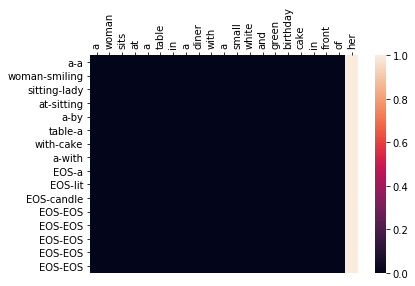

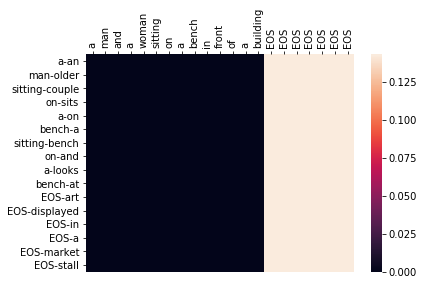

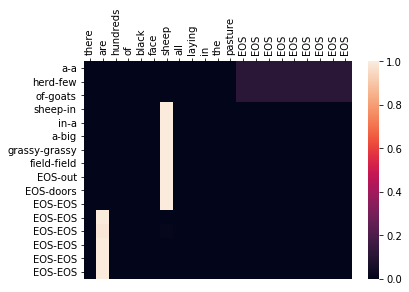

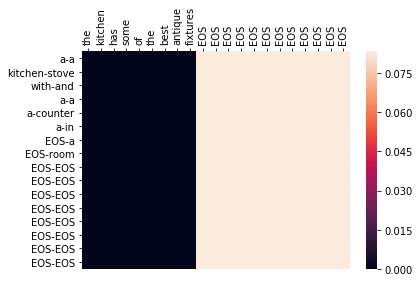

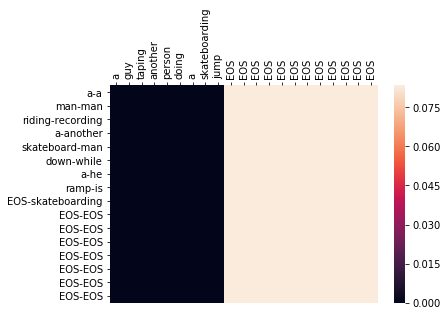



Example 1
INPUT >> a woman sits at a table in a diner with a small white and green birthday cake in front of her
PRED >> a woman sitting at a table with a
TRUE >> a smiling lady sitting by a cake with a lit candle
[BLEU] 0.10

Example 2
INPUT >> a man and a woman sitting on a bench in front of a building
PRED >> a man sitting on a bench sitting on a bench
TRUE >> an older couple sits on a bench and looks at art displayed in a market stall
[BLEU] 0.09

Example 3
INPUT >> there are hundreds of black face sheep all laying in the pasture
PRED >> a herd of sheep in a grassy field
TRUE >> a few goats in a big grassy field out doors
[BLEU] 0.13

Example 4
INPUT >> the kitchen has some of the best antique fixtures
PRED >> a kitchen with a a a
TRUE >> a stove and a counter in a room
[BLEU] 0.08

Example 5
INPUT >> a guy taping another person doing a skateboarding jump
PRED >> a man riding a skateboard down a ramp
TRUE >> a man recording another man while he is skateboarding
[BLEU] 0.10

Step 

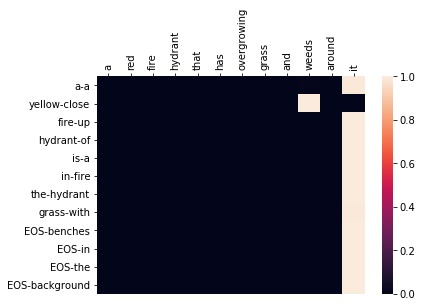

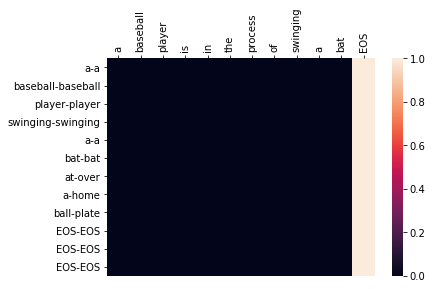

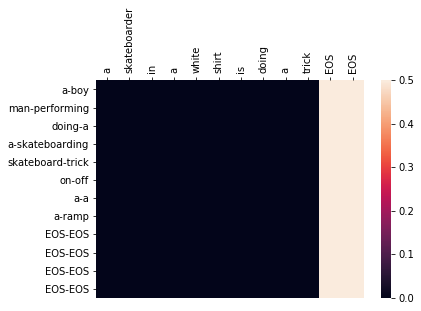

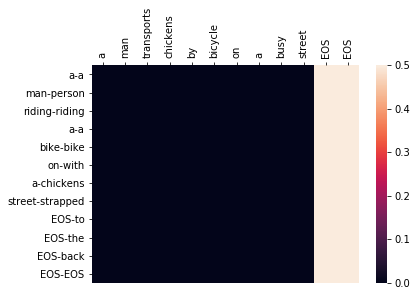

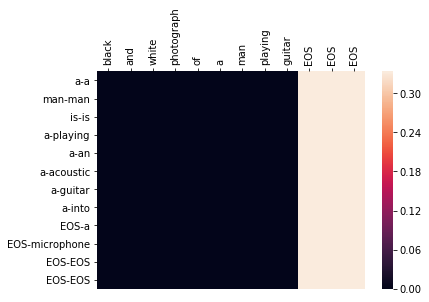



Example 1
INPUT >> a red fire hydrant that has overgrowing grass and weeds around it
PRED >> a yellow fire hydrant is in the grass
TRUE >> a close up of a fire hydrant with benches in the background
[BLEU] 0.10

Example 2
INPUT >> a baseball player is in the process of swinging a bat
PRED >> a baseball player swinging a bat at a ball
TRUE >> a baseball player swinging a bat over home plate
[BLEU] 0.59

Example 3
INPUT >> a skateboarder in a white shirt is doing a trick
PRED >> a man doing a skateboard on a a
TRUE >> boy performing a skateboarding trick off a ramp
[BLEU] 0.07

Example 4
INPUT >> a man transports chickens by bicycle on a busy street
PRED >> a man riding a bike on a street
TRUE >> a person riding a bike with chickens strapped to the back
[BLEU] 0.15

Example 5
INPUT >> black and white photograph of a man playing guitar
PRED >> a man is a a a a a
TRUE >> a man is playing an acoustic guitar into a microphone
[BLEU] 0.17

Step 50 average loss = 0.005346 (time: 20.49)
Step 

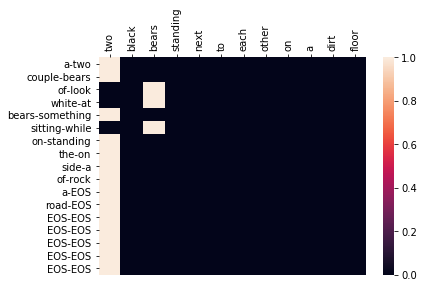

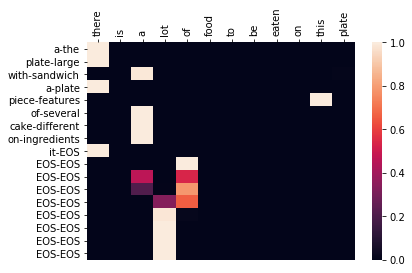

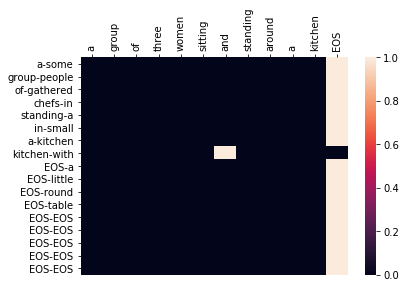

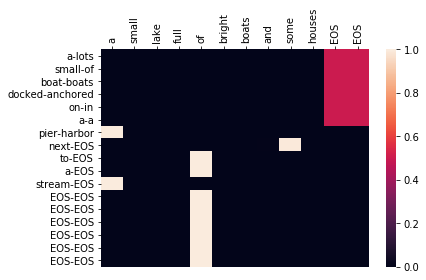

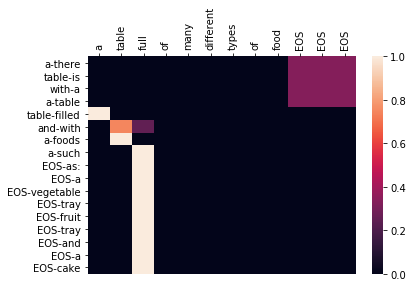



Example 1
INPUT >> two black bears standing next to each other on a dirt floor
PRED >> a couple of white bears sitting on the side of a road
TRUE >> two bears look at something while standing on a rock
[BLEU] 0.04

Example 2
INPUT >> there is a lot of food to be eaten on this plate
PRED >> a plate with a piece of cake on it
TRUE >> the large sandwich plate features several different ingredients
[BLEU] 0.05

Example 3
INPUT >> a group of three women sitting and standing around a kitchen
PRED >> a group of chefs standing in a kitchen
TRUE >> some people gathered in a small kitchen with a little round table
[BLEU] 0.08

Example 4
INPUT >> a small lake full of bright boats and some houses
PRED >> a small boat docked on a pier next to a stream
TRUE >> lots of boats anchored in a harbor
[BLEU] 0.04

Example 5
INPUT >> a table full of many different types of food
PRED >> a table with a table and a a
TRUE >> there is a table filled with foods such as: a vegetable tray fruit tray and a cake
[

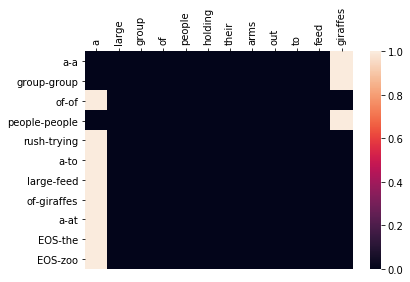

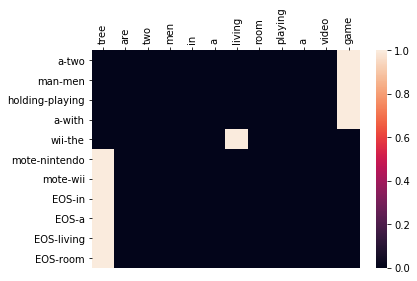

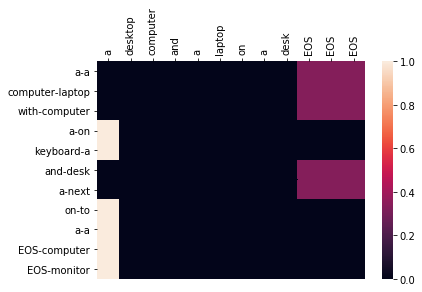

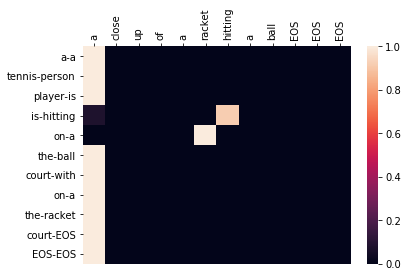

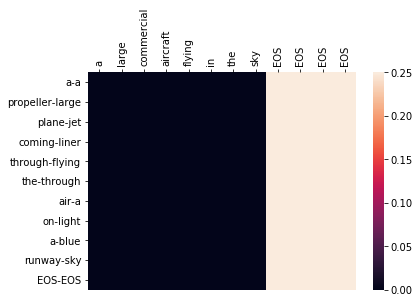



Example 1
INPUT >> a large group of people holding their arms out to feed giraffes
PRED >> a group of people rush a large of a
TRUE >> a group of people trying to feed giraffes at the zoo
[BLEU] 0.24

Example 2
INPUT >> tree are two men in a living room playing a video game
PRED >> a man holding a wii mote mote
TRUE >> two men playing with the nintendo wii in a living room
[BLEU] 0.04

Example 3
INPUT >> a desktop computer and a laptop on a desk
PRED >> a computer with a keyboard and a on a
TRUE >> a laptop computer on a desk next to a computer monitor
[BLEU] 0.11

Example 4
INPUT >> a close up of a racket hitting a ball
PRED >> a tennis player is on the court on the court
TRUE >> a person is hitting a ball with a racket
[BLEU] 0.05

Example 5
INPUT >> a large commercial aircraft flying in the sky
PRED >> a propeller plane coming through the air on a runway
TRUE >> a large jet liner flying through a light blue sky
[BLEU] 0.06

Step 50 average loss = 0.007213 (time: 20.80)
Step 100 av

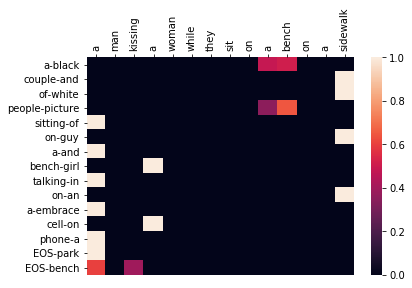

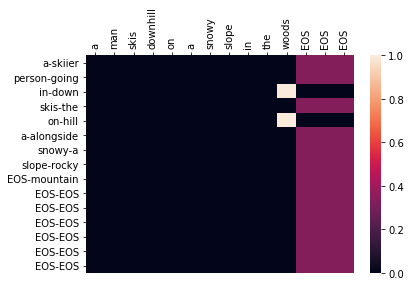

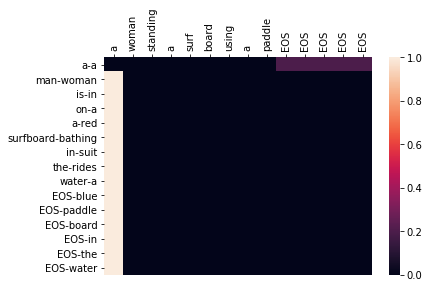

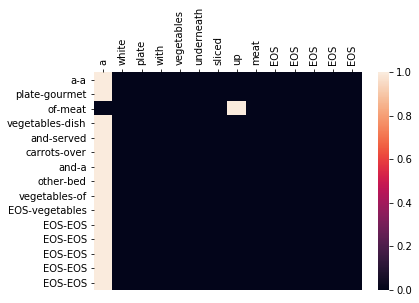

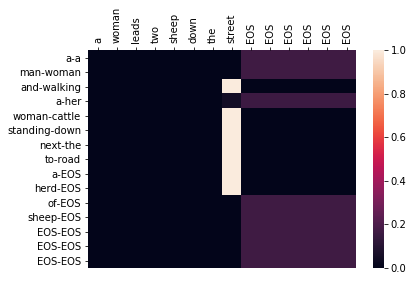



Example 1
INPUT >> a man kissing a woman while they sit on a bench on a sidewalk
PRED >> a couple of people sitting on a bench talking on a cell phone
TRUE >> black and white picture of guy and girl in an embrace on a park bench
[BLEU] 0.06

Example 2
INPUT >> a man skis downhill on a snowy slope in the woods
PRED >> a person in skis on a snowy slope
TRUE >> skiier going down the hill alongside a rocky mountain
[BLEU] 0.05

Example 3
INPUT >> a woman standing a surf board using a paddle
PRED >> a man is on a surfboard in the water
TRUE >> a woman in a red bathing suit rides a blue paddle board in the water
[BLEU] 0.10

Example 4
INPUT >> a white plate with vegetables underneath sliced up meat
PRED >> a plate of vegetables and carrots and other vegetables
TRUE >> a gourmet meat dish served over a bed of vegetables
[BLEU] 0.09

Example 5
INPUT >> a woman leads two sheep down the street
PRED >> a man and a woman standing next to a herd of sheep
TRUE >> a woman walking her cattle down th

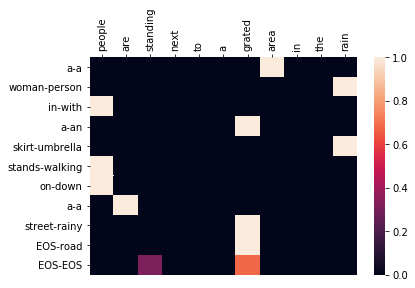

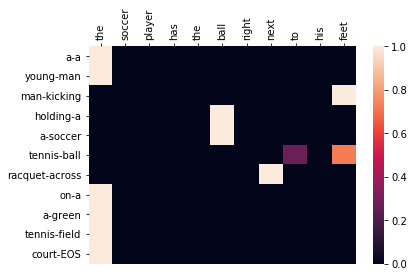

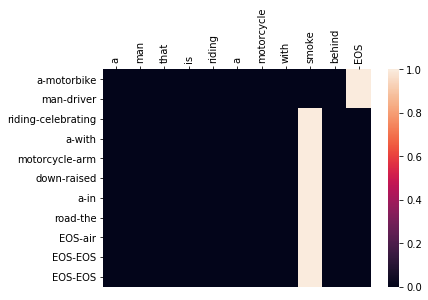

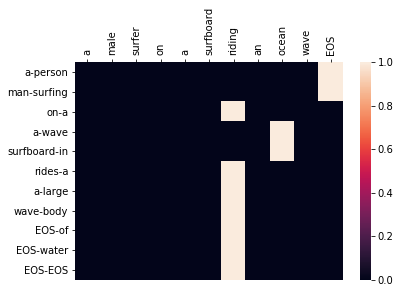

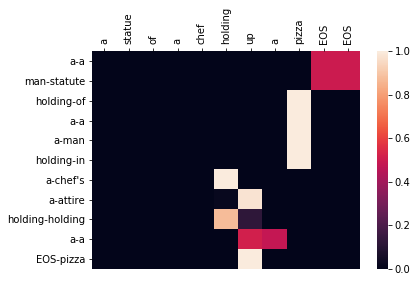



Example 1
INPUT >> people are standing next to a grated area in the rain
PRED >> a woman in a skirt stands on a street
TRUE >> a person with an umbrella walking down a rainy road
[BLEU] 0.05

Example 2
INPUT >> the soccer player has the ball right next to his feet
PRED >> a young man holding a tennis racquet on a tennis court
TRUE >> a man kicking a soccer ball across a green field
[BLEU] 0.05

Example 3
INPUT >> a man that is riding a motorcycle with smoke behind
PRED >> a man riding a motorcycle down a road
TRUE >> motorbike driver celebrating with arm raised in the air
[BLEU] 0.00

Example 4
INPUT >> a male surfer on a surfboard riding an ocean wave
PRED >> a man on a surfboard rides a wave
TRUE >> person surfing a wave in a large body of water
[BLEU] 0.10

Example 5
INPUT >> a statue of a chef holding up a pizza
PRED >> a man holding a a holding a a holding a
TRUE >> a statute of a man in chef's attire holding a pizza
[BLEU] 0.11

Step 50 average loss = 0.005764 (time: 20.42)
Ste

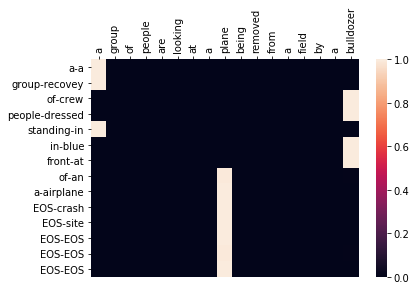

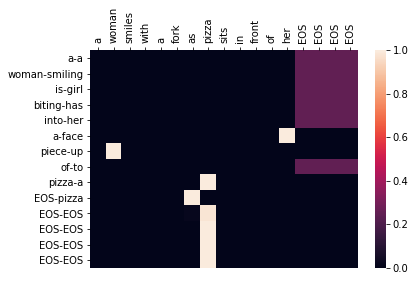

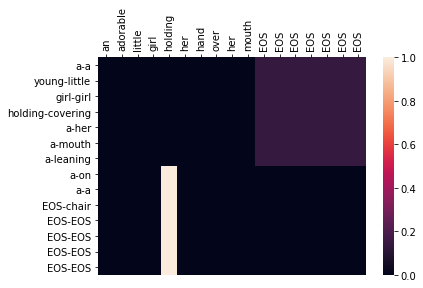

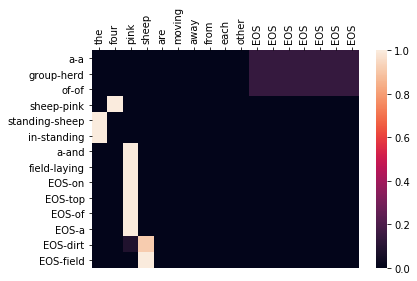

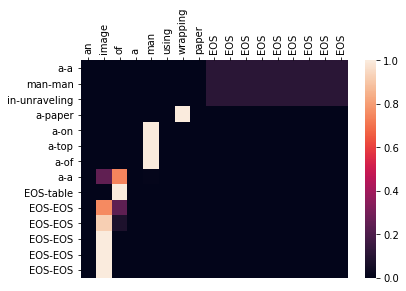



Example 1
INPUT >> a group of people are looking at a plane being removed from a field by a bulldozer
PRED >> a group of people standing in front of a
TRUE >> a recovey crew dressed in blue at an airplane crash site
[BLEU] 0.05

Example 2
INPUT >> a woman smiles with a fork as pizza sits in front of her
PRED >> a woman is biting into a piece of pizza
TRUE >> a smiling girl has her face up to a pizza
[BLEU] 0.06

Example 3
INPUT >> an adorable little girl holding her hand over her mouth
PRED >> a young girl holding a a a a a
TRUE >> a little girl covering her mouth leaning on a chair
[BLEU] 0.06

Example 4
INPUT >> the four pink sheep are moving away from each other
PRED >> a group of sheep standing in a field
TRUE >> a herd of pink sheep standing and laying on top of a dirt field
[BLEU] 0.07

Example 5
INPUT >> an image of a man using wrapping paper
PRED >> a man in a a a a a
TRUE >> a man unraveling paper on top of a table
[BLEU] 0.11

Step 50 average loss = 0.006483 (time: 20.56)
S

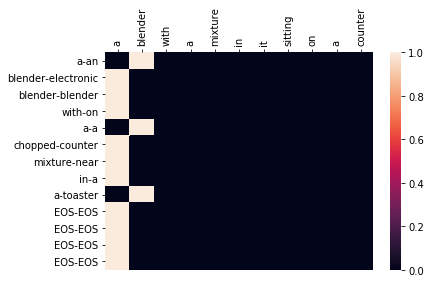

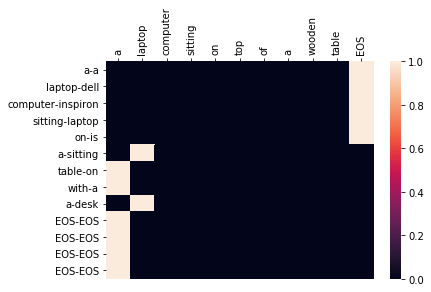

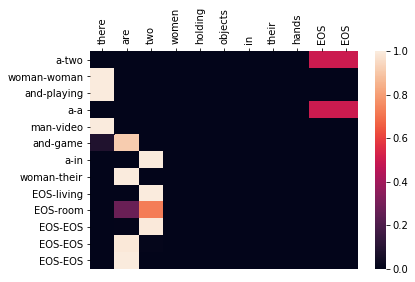

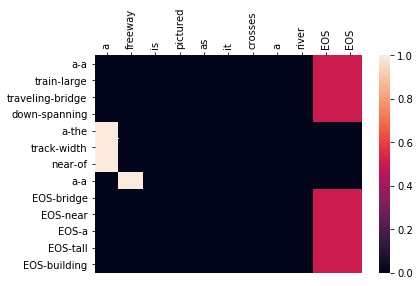

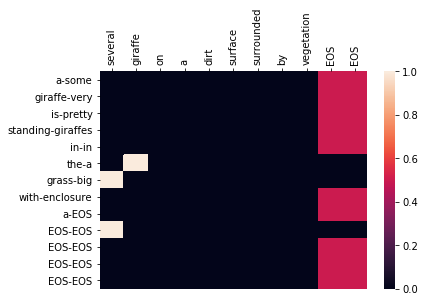



Example 1
INPUT >> a blender with a mixture in it sitting on a counter
PRED >> a blender blender with a chopped mixture in a
TRUE >> an electronic blender on a counter near a toaster
[BLEU] 0.06

Example 2
INPUT >> a laptop computer sitting on top of a wooden table
PRED >> a laptop computer sitting on a table with a
TRUE >> a dell inspiron laptop is sitting on a desk
[BLEU] 0.20

Example 3
INPUT >> there are two women holding objects in their hands
PRED >> a woman and a man and a woman
TRUE >> two woman playing a video game in their living room
[BLEU] 0.05

Example 4
INPUT >> a freeway is pictured as it crosses a river
PRED >> a train traveling down a track near a
TRUE >> a large bridge spanning the width of a bridge near a tall building
[BLEU] 0.07

Example 5
INPUT >> several giraffe on a dirt surface surrounded by vegetation
PRED >> a giraffe is standing in the grass with a
TRUE >> some very pretty giraffes in a big enclosure
[BLEU] 0.06

Step 50 average loss = 0.006615 (time: 21.5

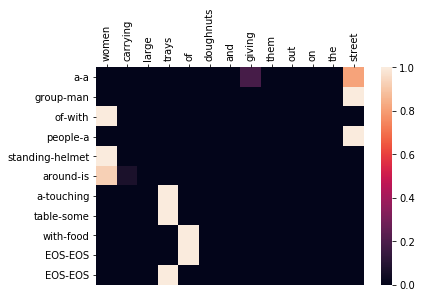

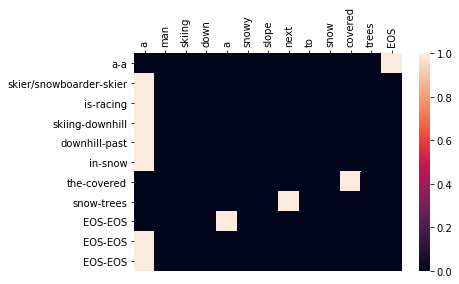

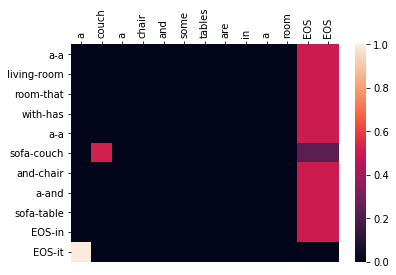

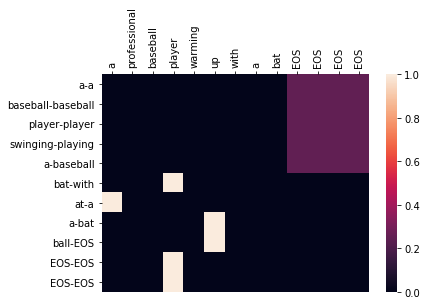

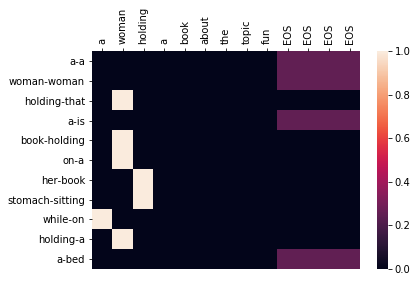



Example 1
INPUT >> women carrying large trays of doughnuts and giving them out on the street
PRED >> a group of people standing around a table with
TRUE >> a man with a helmet is touching some food
[BLEU] 0.06

Example 2
INPUT >> a man skiing down a snowy slope next to snow covered trees
PRED >> a skier/snowboarder is skiing downhill in the snow
TRUE >> a skier racing downhill past snow covered trees
[BLEU] 0.07

Example 3
INPUT >> a couch a chair and some tables are in a room
PRED >> a living room with a sofa and a sofa
TRUE >> a room that has a couch chair and table in it
[BLEU] 0.05

Example 4
INPUT >> a professional baseball player warming up with a bat
PRED >> a baseball player swinging a bat at a ball
TRUE >> a baseball player playing baseball with a bat
[BLEU] 0.22

Example 5
INPUT >> a woman holding a book about the topic fun
PRED >> a woman holding a book on her stomach while holding a
TRUE >> a woman that is holding a book sitting on a bed
[BLEU] 0.19

Step 50 average loss 

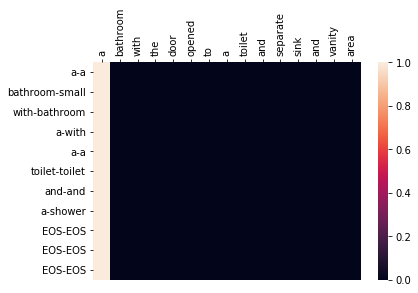

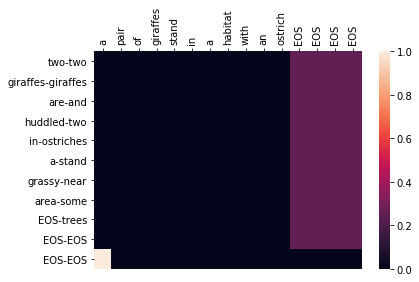

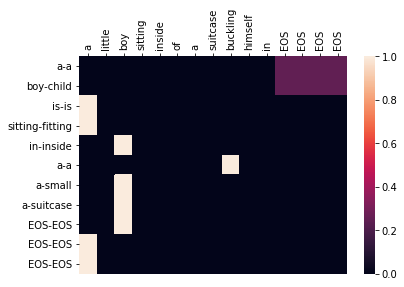

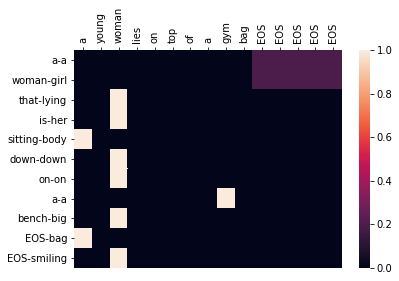

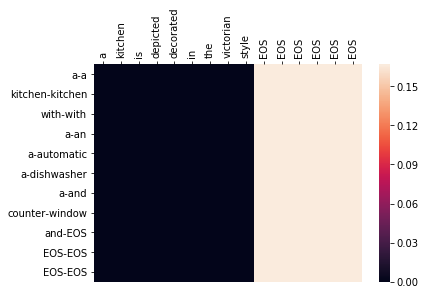



Example 1
INPUT >> a bathroom with the door opened to a toilet and separate sink and vanity area
PRED >> a bathroom with a a toilet and a
TRUE >> a small bathroom with a toilet and shower
[BLEU] 0.35

Example 2
INPUT >> a pair of giraffes stand in a habitat with an ostrich
PRED >> two giraffes are huddled in a grassy area
TRUE >> two giraffes and two ostriches stand near some trees
[BLEU] 0.10

Example 3
INPUT >> a little boy sitting inside of a suitcase buckling himself in
PRED >> a boy is sitting in a a a
TRUE >> a child is fitting inside a small suitcase
[BLEU] 0.07

Example 4
INPUT >> a young woman lies on top of a gym bag
PRED >> a woman that is sitting down on a bench
TRUE >> a girl lying her body down on a big bag smiling
[BLEU] 0.15

Example 5
INPUT >> a kitchen is depicted decorated in the victorian style
PRED >> a kitchen with a a a a counter and
TRUE >> a kitchen with an automatic dishwasher and window
[BLEU] 0.19

Step 50 average loss = 0.005157 (time: 21.22)
Step 100 ave

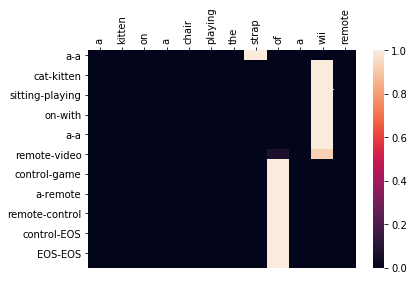

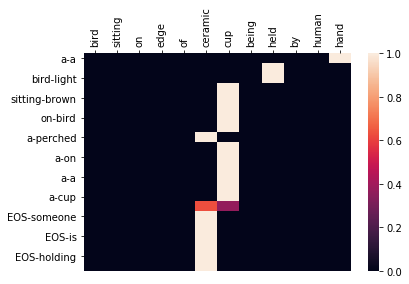

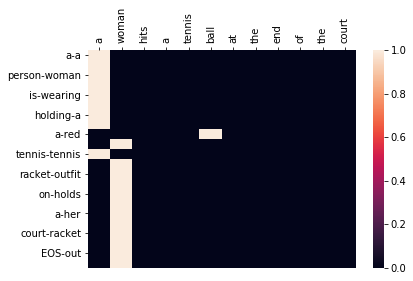

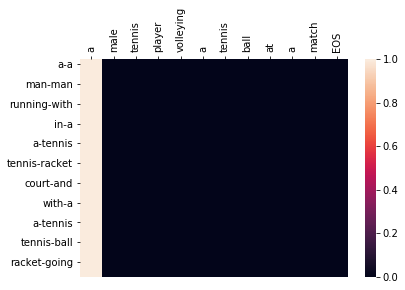

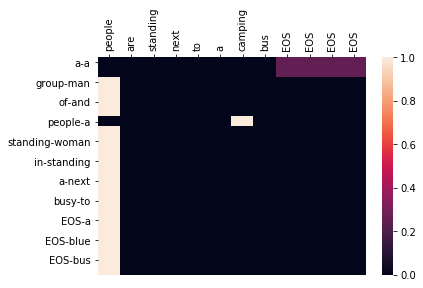



Example 1
INPUT >> a kitten on a chair playing the strap of a wii remote
PRED >> a cat sitting on a remote control a remote control
TRUE >> a kitten playing with a video game remote control
[BLEU] 0.10

Example 2
INPUT >> bird sitting on edge of ceramic cup being held by human hand
PRED >> a bird sitting on a a a a
TRUE >> a light brown bird perched on a cup someone is holding with trees in the background
[BLEU] 0.05

Example 3
INPUT >> a woman hits a tennis ball at the end of the court
PRED >> a person is holding a tennis racket on a court
TRUE >> a woman wearing a red tennis outfit holds her racket out to the side near a tennis ball on a tennis court
[BLEU] 0.04

Example 4
INPUT >> a male tennis player volleying a tennis ball at a match
PRED >> a man running in a tennis court with a tennis racket
TRUE >> a man with a tennis racket and a tennis ball going towards him
[BLEU] 0.26

Example 5
INPUT >> people are standing next to a camping bus
PRED >> a group of people standing in a bus

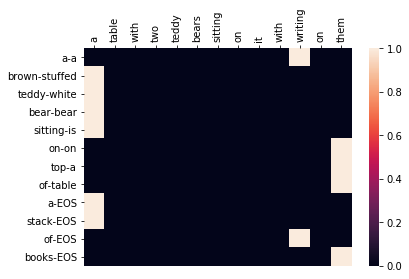

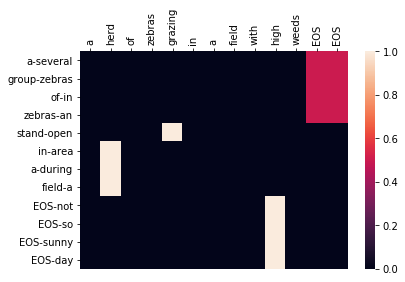

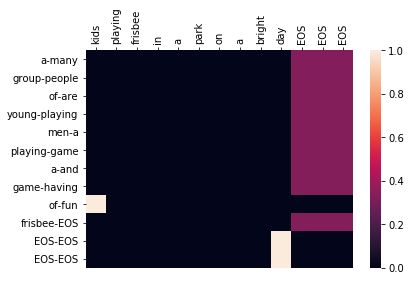

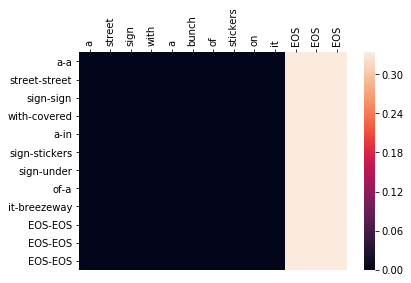

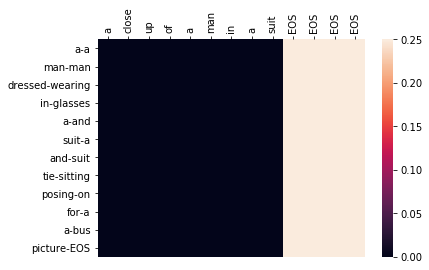



Example 1
INPUT >> a table with two teddy bears sitting on it with writing on them
PRED >> a brown teddy bear sitting on top of a stack of books
TRUE >> a stuffed white bear is on a table
[BLEU] 0.05

Example 2
INPUT >> a herd of zebras grazing in a field with high weeds
PRED >> a group of zebras stand in a field
TRUE >> several zebras in an open area during a not so sunny day
[BLEU] 0.04

Example 3
INPUT >> kids playing frisbee in a park on a bright day
PRED >> a group of young men playing a game of frisbee
TRUE >> many people are playing a game and having fun
[BLEU] 0.16

Example 4
INPUT >> a street sign with a bunch of stickers on it
PRED >> a street sign with a sign sign of it
TRUE >> a street sign covered in stickers under a breezeway
[BLEU] 0.19

Example 5
INPUT >> a close up of a man in a suit
PRED >> a man dressed in a suit and tie posing for a picture
TRUE >> a man wearing glasses and a suit sitting on a bus
[BLEU] 0.11

Step 50 average loss = 0.005589 (time: 20.74)
Step 100

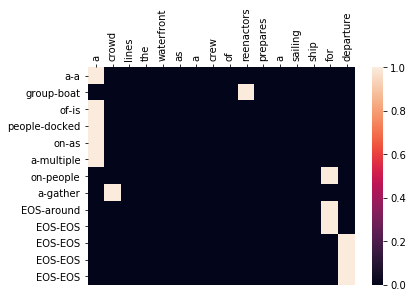

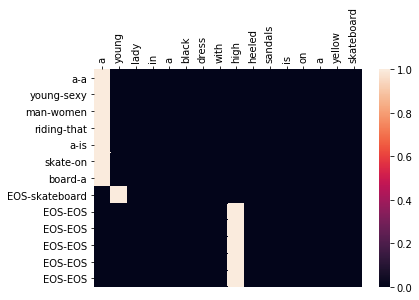

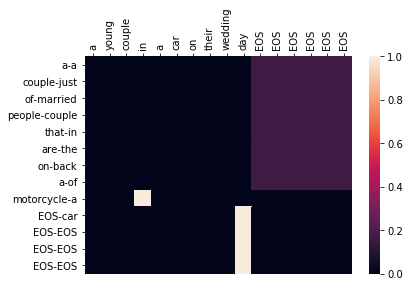

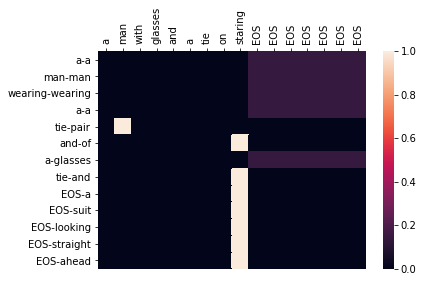

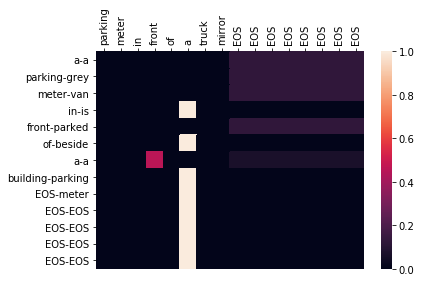



Example 1
INPUT >> a crowd lines the waterfront as a crew of reenactors prepares a sailing ship for departure
PRED >> a group of people on a on a
TRUE >> a boat is docked as multiple people gather around
[BLEU] 0.06

Example 2
INPUT >> a young lady in a black dress with high heeled sandals is on a yellow skateboard
PRED >> a young man riding a skate board
TRUE >> a sexy women that is on a skateboard
[BLEU] 0.07

Example 3
INPUT >> a young couple in a car on their wedding day
PRED >> a couple of people that are on a motorcycle
TRUE >> a just married couple in the back of a car
[BLEU] 0.06

Example 4
INPUT >> a man with glasses and a tie on staring
PRED >> a man wearing a tie and a tie
TRUE >> a man wearing a pair of glasses and a suit looking straight ahead
[BLEU] 0.22

Example 5
INPUT >> parking meter in front of a truck mirror
PRED >> a parking meter in front of a building
TRUE >> a grey van is parked beside a parking meter
[BLEU] 0.19

Step 50 average loss = 0.005690 (time: 20.79)


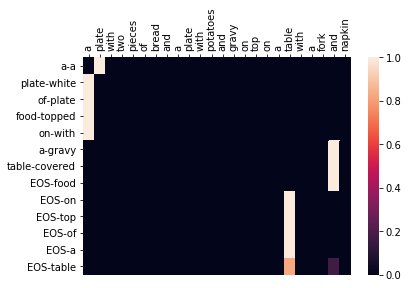

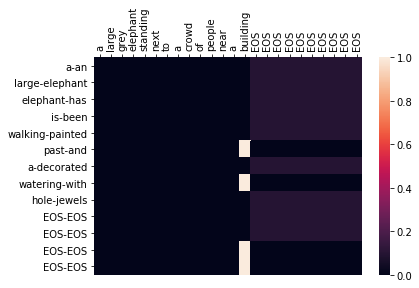

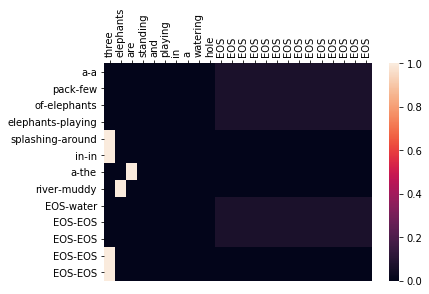

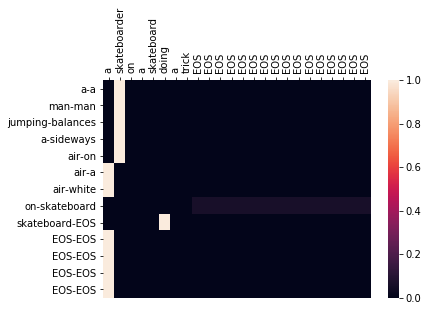

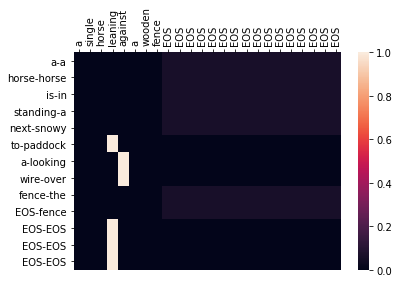



Example 1
INPUT >> a plate with two pieces of bread and a plate with potatoes and gravy on top on a table with a fork and napkin
PRED >> a plate of food on a table
TRUE >> a white plate topped with gravy covered food on top of a table
[BLEU] 0.09

Example 2
INPUT >> a large grey elephant standing next to a crowd of people near a building
PRED >> a large elephant is walking past a watering hole
TRUE >> an elephant has been painted and decorated with jewels
[BLEU] 0.05

Example 3
INPUT >> three elephants are standing and playing in a watering hole
PRED >> a pack of elephants splashing in a river
TRUE >> a few elephants playing around in the muddy water
[BLEU] 0.06

Example 4
INPUT >> a skateboarder on a skateboard doing a trick
PRED >> a man jumping a air air air on skateboard
TRUE >> a man balances sideways on a white skateboard
[BLEU] 0.12

Example 5
INPUT >> a single horse leaning against a wooden fence
PRED >> a horse is standing next to a wire fence
TRUE >> a horse in a snowy padd

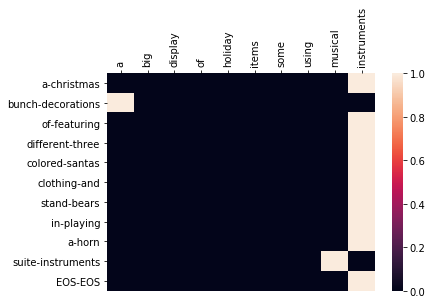

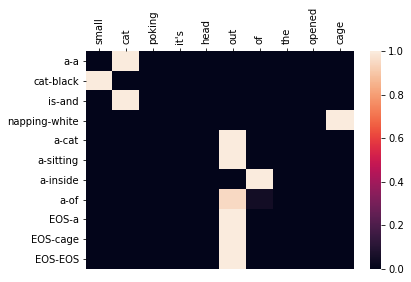

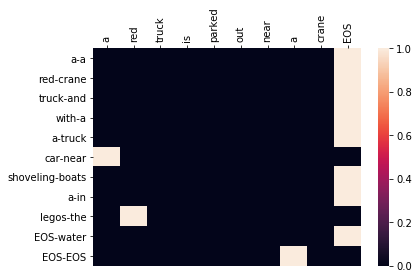

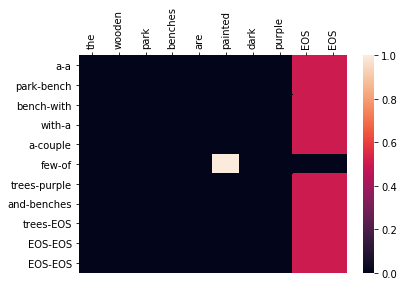

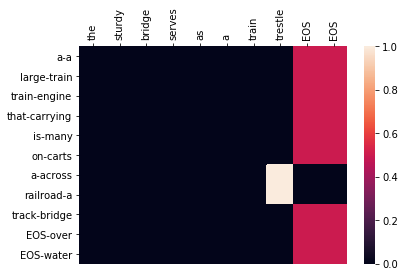



Example 1
INPUT >> a big display of holiday items some using musical instruments
PRED >> a bunch of different colored clothing stand in a suite
TRUE >> christmas decorations featuring three santas and bears playing horn instruments
[BLEU] 0.00

Example 2
INPUT >> small cat poking it's head out of the opened cage
PRED >> a cat is napping a a a a
TRUE >> a black and white cat sitting inside of a cage
[BLEU] 0.06

Example 3
INPUT >> a red truck is parked out near a crane
PRED >> a red truck with a car shoveling a legos
TRUE >> a crane and a truck near boats in the water
[BLEU] 0.06

Example 4
INPUT >> the wooden park benches are painted dark purple
PRED >> a park bench with a few trees and trees
TRUE >> a bench with a couple of purple benches
[BLEU] 0.19

Example 5
INPUT >> the sturdy bridge serves as a train trestle
PRED >> a large train that is on a railroad track
TRUE >> a train engine carrying many carts across a bridge over water
[BLEU] 0.05

Step 50 average loss = 0.004462 (time: 

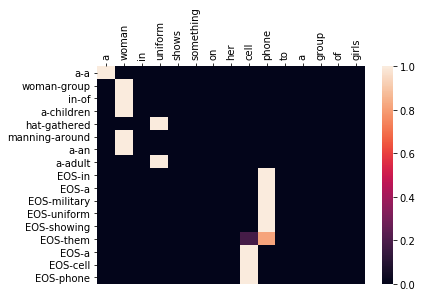

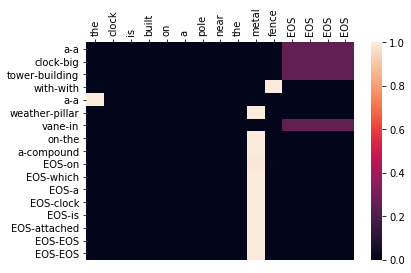

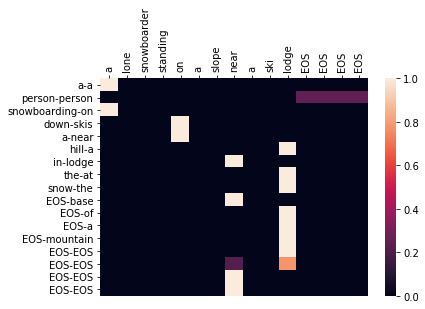

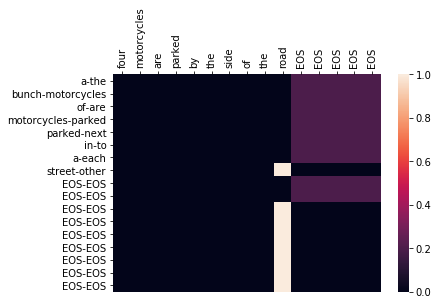

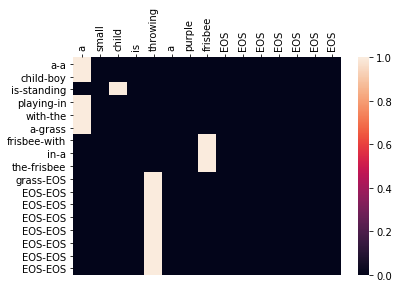



Example 1
INPUT >> a woman in uniform shows something on her cell phone to a group of girls
PRED >> a woman in a hat manning a a
TRUE >> a group of children gathered around an adult in a military uniform showing them a cell phone
[BLEU] 0.04

Example 2
INPUT >> the clock is built on a pole near the metal fence
PRED >> a clock tower with a weather vane on a
TRUE >> a big building with a pillar in the compound on which a clock is attached
[BLEU] 0.08

Example 3
INPUT >> a lone snowboarder standing on a slope near a ski lodge
PRED >> a person snowboarding down a hill in the snow
TRUE >> a person on skis near a lodge at the base of a mountain
[BLEU] 0.07

Example 4
INPUT >> four motorcycles are parked by the side of the road
PRED >> a bunch of motorcycles parked in a street
TRUE >> the motorcycles are parked next to each other
[BLEU] 0.07

Example 5
INPUT >> a small child is throwing a purple frisbee
PRED >> a child is playing with a frisbee in the grass
TRUE >> a boy standing in the gra

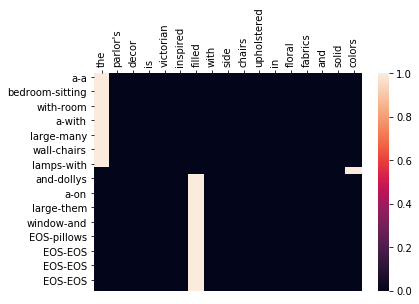

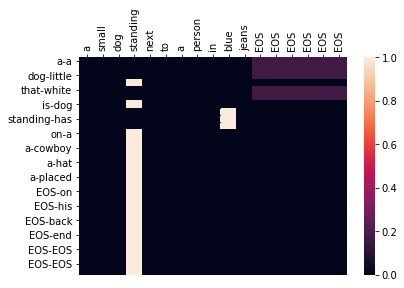

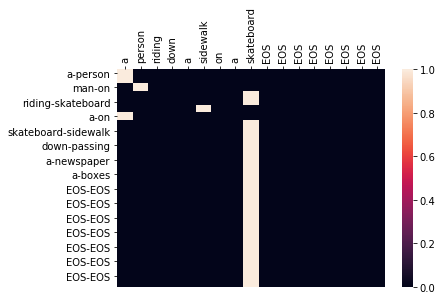

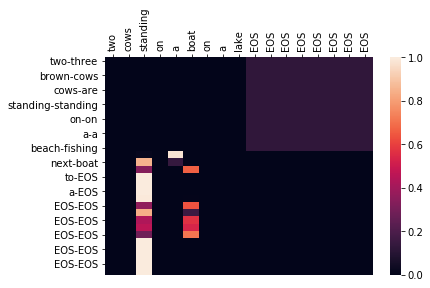

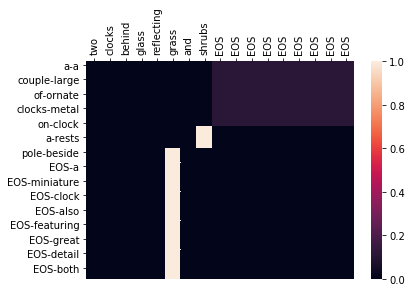



Example 1
INPUT >> the parlor's decor is victorian inspired filled with side chairs upholstered in floral fabrics and solid colors
PRED >> a bedroom with a large wall lamps and a large window
TRUE >> a sitting room with many chairs with dollys on them and pillows
[BLEU] 0.05

Example 2
INPUT >> a small dog standing next to a person in blue jeans
PRED >> a dog that is standing on a a a
TRUE >> a little white dog has a cowboy hat placed on his back end
[BLEU] 0.04

Example 3
INPUT >> a person riding down a sidewalk on a skateboard
PRED >> a man riding a skateboard down a a
TRUE >> person on skateboard on sidewalk passing newspaper boxes
[BLEU] 0.06

Example 4
INPUT >> two cows standing on a boat on a lake
PRED >> two brown cows standing on a beach next to a
TRUE >> three cows are standing on a fishing boat
[BLEU] 0.17

Example 5
INPUT >> two clocks behind glass reflecting grass and shrubs
PRED >> a couple of clocks on a pole
TRUE >> a large ornate metal clock rests beside a miniature c

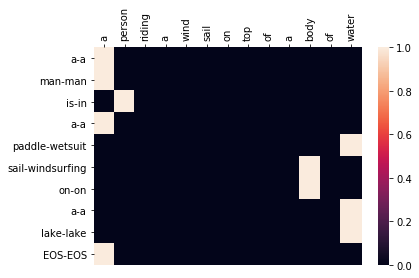

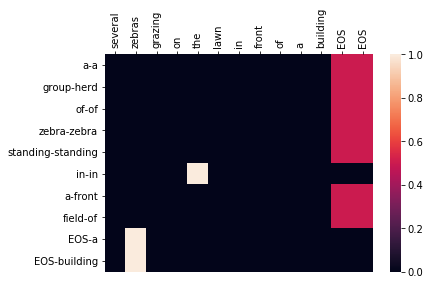

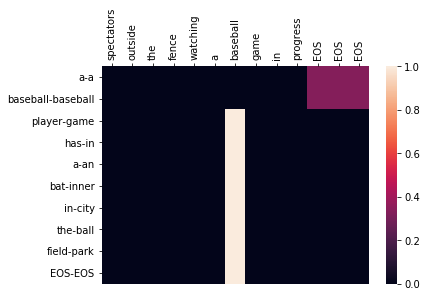

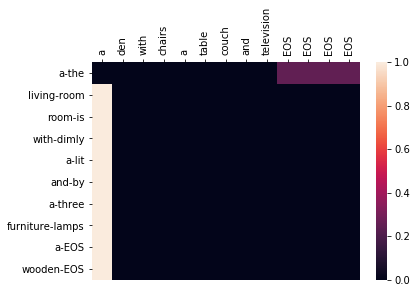

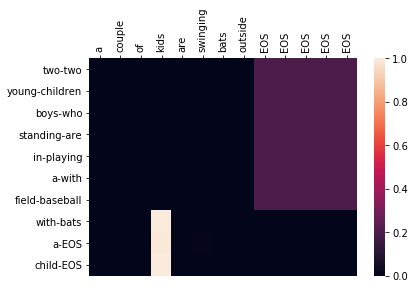



Example 1
INPUT >> a person riding a wind sail on top of a body of water
PRED >> a man is a paddle sail on a lake
TRUE >> a man in a wetsuit windsurfing on a lake
[BLEU] 0.23

Example 2
INPUT >> several zebras grazing on the lawn in front of a building
PRED >> a group of zebra standing in a field
TRUE >> a herd of zebra standing in front of a building
[BLEU] 0.30

Example 3
INPUT >> spectators outside the fence watching a baseball game in progress
PRED >> a baseball player has a bat in the field
TRUE >> a baseball game in an inner city ball park
[BLEU] 0.11

Example 4
INPUT >> a den with chairs a table couch and television
PRED >> a living room with a and a furniture a wooden
TRUE >> the room is dimly lit by three lamps
[BLEU] 0.04

Example 5
INPUT >> a couple of kids are swinging bats outside
PRED >> two young boys standing in a field with a child
TRUE >> two children who are playing with baseball bats
[BLEU] 0.05

Step 50 average loss = 0.013712 (time: 20.92)
Step 100 average loss 

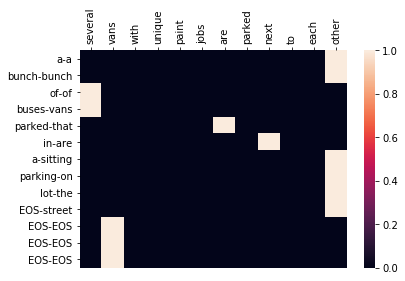

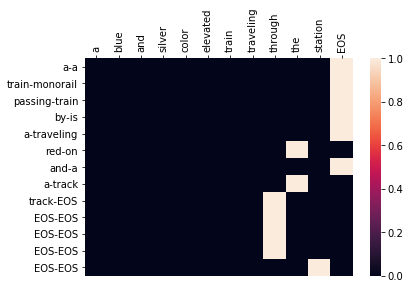

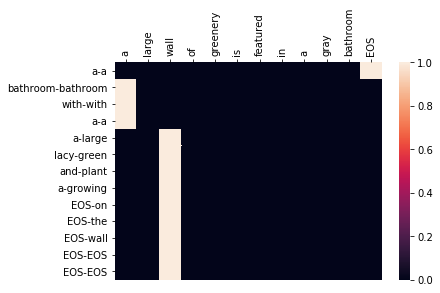

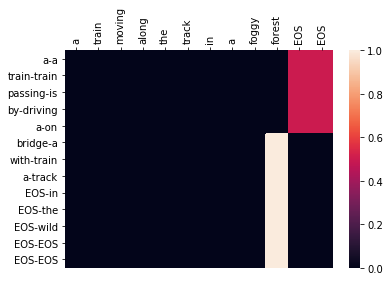

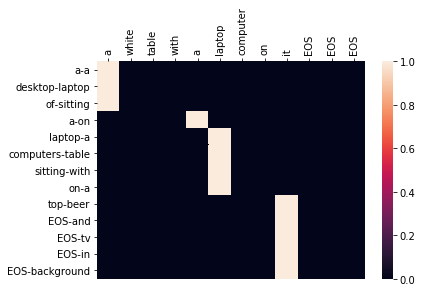



Example 1
INPUT >> several vans with unique paint jobs are parked next to each other
PRED >> a bunch of buses parked in a parking lot
TRUE >> a bunch of vans that are sitting on the street
[BLEU] 0.16

Example 2
INPUT >> a blue and silver color elevated train traveling through the station
PRED >> a train passing by a red and a track
TRUE >> a monorail train is traveling on a track
[BLEU] 0.11

Example 3
INPUT >> a large wall of greenery is featured in a gray bathroom
PRED >> a bathroom with a a lacy and a
TRUE >> a bathroom with a large green plant growing on the wall
[BLEU] 0.24

Example 4
INPUT >> a train moving along the track in a foggy forest
PRED >> a train passing by a bridge with a
TRUE >> a train is driving on a train track in the wild
[BLEU] 0.08

Example 5
INPUT >> a white table with a laptop computer on it
PRED >> a desktop of a laptop computers sitting on top
TRUE >> a laptop sitting on a table with a beer and tv in background
[BLEU] 0.09

Step 50 average loss = 0.005645

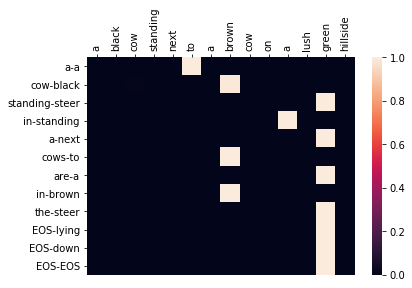

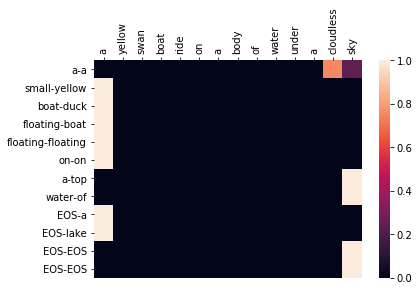

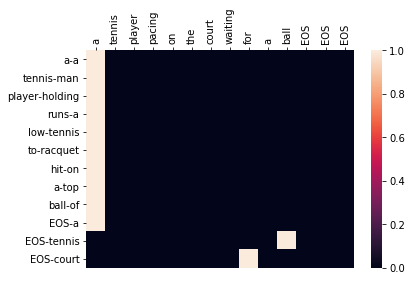

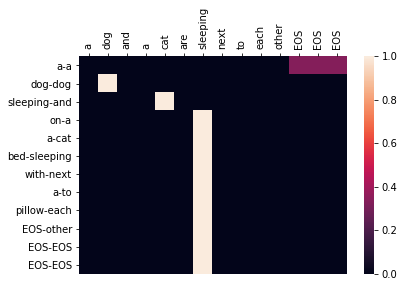

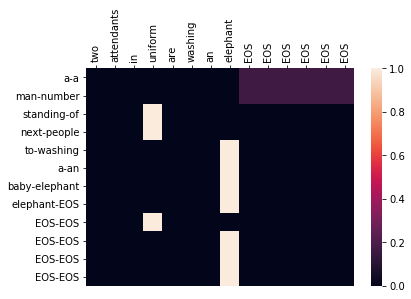



Example 1
INPUT >> a black cow standing next to a brown cow on a lush green hillside
PRED >> a cow standing in a cows are in the
TRUE >> a black steer standing next to a brown steer lying down
[BLEU] 0.05

Example 2
INPUT >> a yellow swan boat ride on a body of water under a cloudless sky
PRED >> a small boat floating floating on a water
TRUE >> a yellow duck boat floating on top of a lake
[BLEU] 0.13

Example 3
INPUT >> a tennis player pacing on the court waiting for a ball
PRED >> a tennis player runs low to hit a ball
TRUE >> a man holding a tennis racquet on top of a tennis court
[BLEU] 0.08

Example 4
INPUT >> a dog and a cat are sleeping next to each other
PRED >> a dog sleeping on a bed with a pillow
TRUE >> a dog and a cat sleeping next to each other
[BLEU] 0.10

Example 5
INPUT >> two attendants in uniform are washing an elephant
PRED >> a man standing next to a baby elephant
TRUE >> a number of people washing an elephant
[BLEU] 0.07

Step 50 average loss = 0.006955 (time: 2

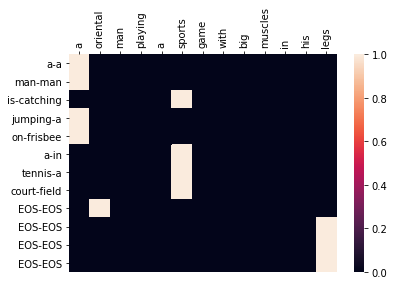

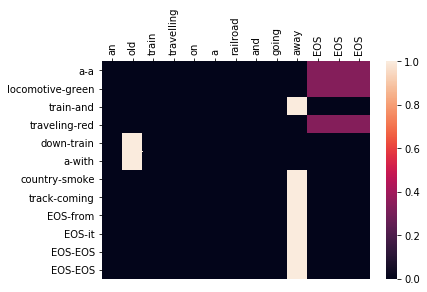

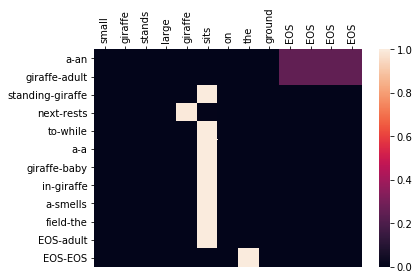

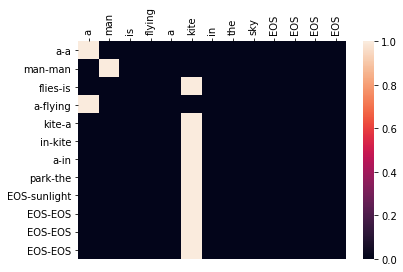

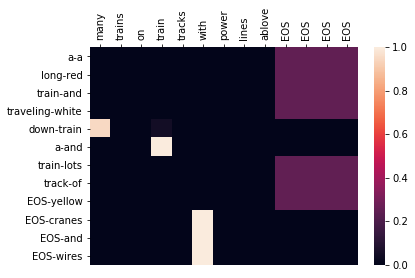



Example 1
INPUT >> a oriental man playing a sports game with big muscles in his legs
PRED >> a man is jumping on a tennis court
TRUE >> a man catching a frisbee in a field
[BLEU] 0.12

Example 2
INPUT >> an old train travelling on a railroad and going away
PRED >> a locomotive train traveling down a country track
TRUE >> a green and red train with smoke coming from it
[BLEU] 0.05

Example 3
INPUT >> small giraffe stands large giraffe sits on the ground
PRED >> a giraffe standing next to a giraffe in a field
TRUE >> an adult giraffe rests while a baby giraffe smells the adult
[BLEU] 0.05

Example 4
INPUT >> a man is flying a kite in the sky
PRED >> a man flies a kite in a park
TRUE >> a man is flying a kite in the sunlight
[BLEU] 0.23

Example 5
INPUT >> many trains on train tracks with power lines ablove
PRED >> a long train traveling down a train track
TRUE >> a red and white train and lots of yellow cranes and wires
[BLEU] 0.04

Step 50 average loss = 0.010436 (time: 20.27)
Step 10

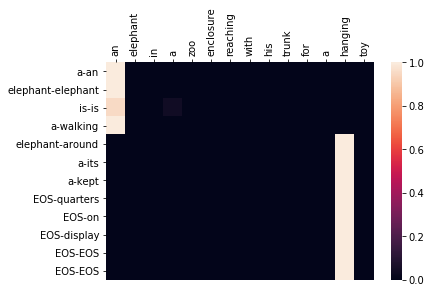

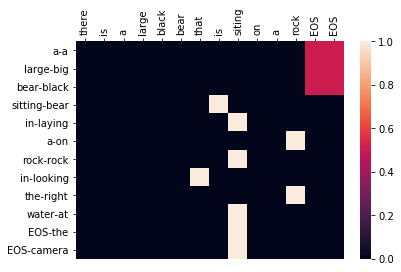

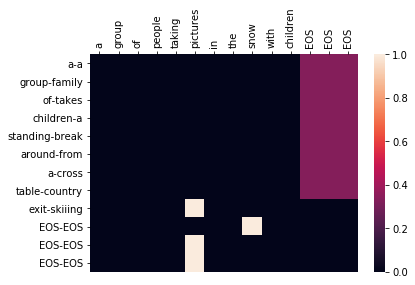

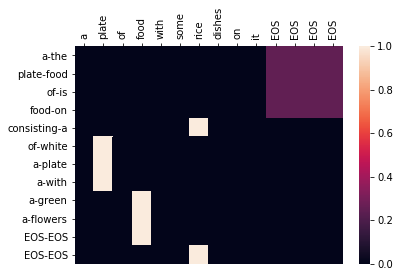

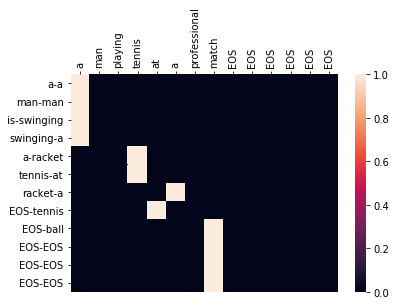



Example 1
INPUT >> an elephant in a zoo enclosure reaching with his trunk for a hanging toy
PRED >> a elephant is a elephant a a
TRUE >> an elephant is walking around its kept quarters on display
[BLEU] 0.09

Example 2
INPUT >> there is a large black bear that is siting on a rock
PRED >> a large bear sitting in a rock in the water
TRUE >> a big black bear laying on rock looking right at the camera
[BLEU] 0.05

Example 3
INPUT >> a group of people taking pictures in the snow with children
PRED >> a group of children standing around a table exit
TRUE >> a family takes a break from cross country skiiing
[BLEU] 0.06

Example 4
INPUT >> a plate of food with some rice dishes on it
PRED >> a plate of food consisting of a a a a
TRUE >> the food is on a white plate with green flowers
[BLEU] 0.06

Example 5
INPUT >> a man playing tennis at a professional match
PRED >> a man is swinging a tennis racket
TRUE >> a man swinging a racket at a tennis ball
[BLEU] 0.17

Step 50 average loss = 0.006987

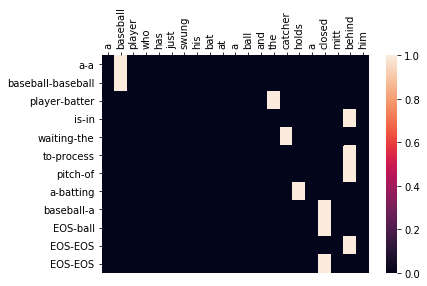

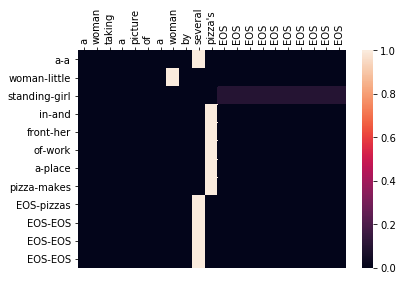

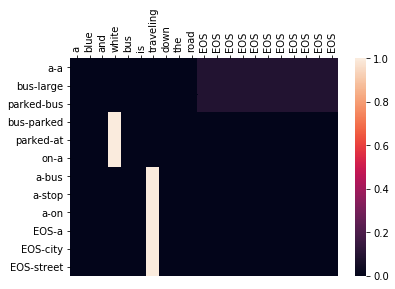

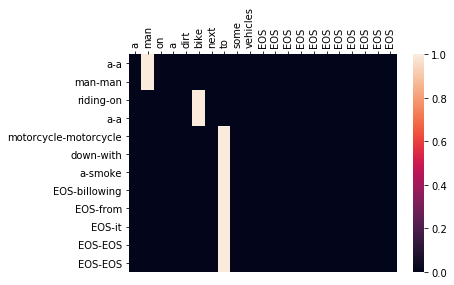

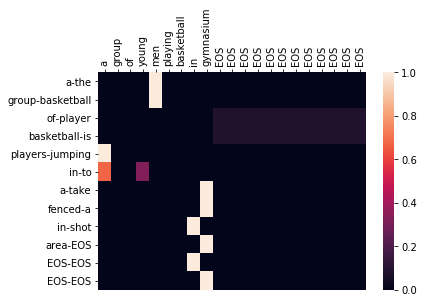



Example 1
INPUT >> a baseball player who has just swung his bat at a ball and the catcher holds a closed mitt behind him
PRED >> a baseball player is waiting to pitch a baseball
TRUE >> a baseball batter in the process of batting a ball
[BLEU] 0.09

Example 2
INPUT >> a woman taking a picture of a woman by several pizza's
PRED >> a woman standing in front of a pizza
TRUE >> a little girl and her work place makes pizzas
[BLEU] 0.05

Example 3
INPUT >> a blue and white bus is traveling down the road
PRED >> a bus parked bus parked on a a a
TRUE >> a large bus parked at a bus stop on a city street
[BLEU] 0.12

Example 4
INPUT >> a man on a dirt bike next to some vehicles
PRED >> a man riding a motorcycle down a
TRUE >> a man on a motorcycle with smoke billowing from it
[BLEU] 0.12

Example 5
INPUT >> a group of young men playing basketball in gymnasium
PRED >> a group of basketball players in a fenced in area
TRUE >> the basketball player is jumping to take a shot
[BLEU] 0.05

Step 50 a

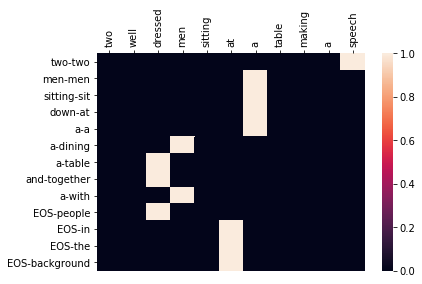

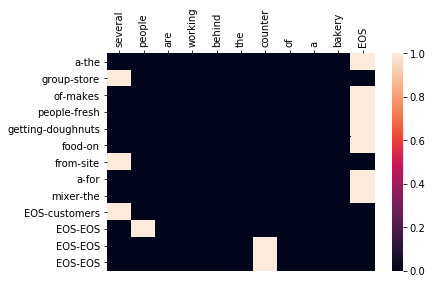

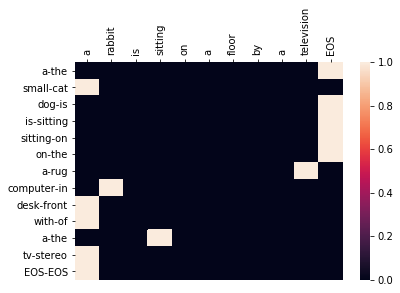

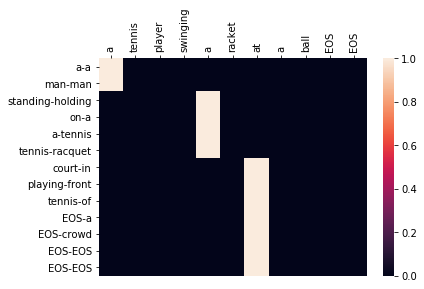

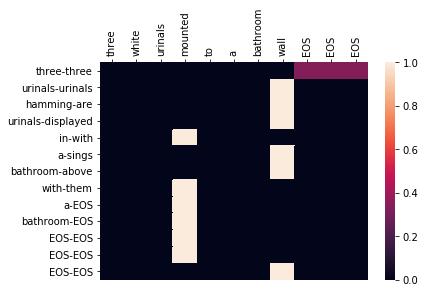



Example 1
INPUT >> two well dressed men sitting at a table making a speech
PRED >> two men sitting down a a a and a
TRUE >> two men sit at a dining table together with people in the background
[BLEU] 0.07

Example 2
INPUT >> several people are working behind the counter of a bakery
PRED >> a group of people getting food from a mixer
TRUE >> the store makes fresh doughnuts on site for the customers
[BLEU] 0.00

Example 3
INPUT >> a rabbit is sitting on a floor by a television
PRED >> a small dog is sitting on a computer desk with a tv
TRUE >> the cat is sitting on the rug in front of the stereo
[BLEU] 0.13

Example 4
INPUT >> a tennis player swinging a racket at a ball
PRED >> a man standing on a tennis court playing tennis
TRUE >> a man holding a tennis racquet in front of a crowd
[BLEU] 0.11

Example 5
INPUT >> three white urinals mounted to a bathroom wall
PRED >> three urinals hamming urinals in a bathroom with a bathroom
TRUE >> three urinals are displayed with sings above them
[

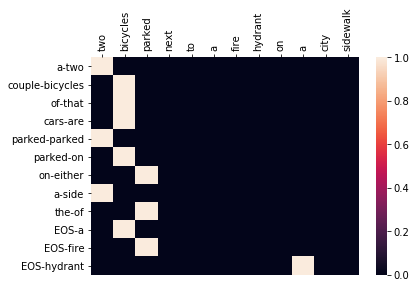

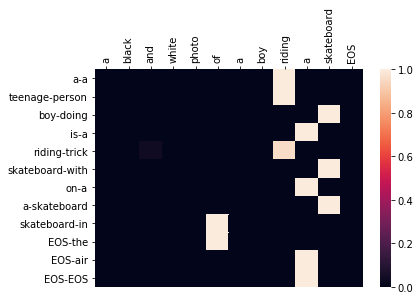

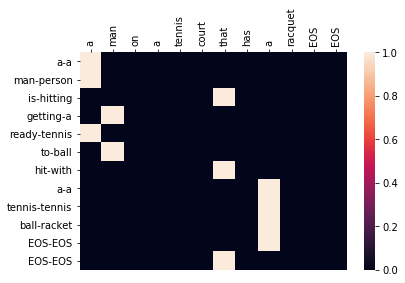

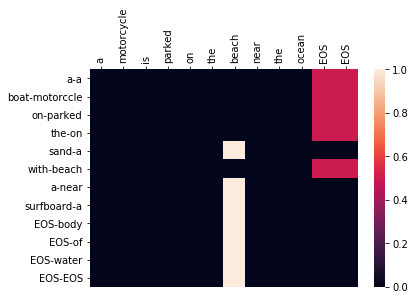

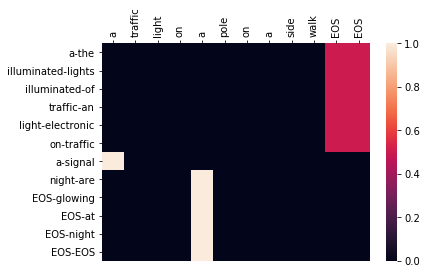



Example 1
INPUT >> two bicycles parked next to a fire hydrant on a city sidewalk
PRED >> a couple of cars parked parked on a the
TRUE >> two bicycles that are parked on either side of a fire hydrant
[BLEU] 0.08

Example 2
INPUT >> a black and white photo of a boy riding a skateboard
PRED >> a teenage boy is riding skateboard on a skateboard
TRUE >> a person doing a trick with a skateboard in the air
[BLEU] 0.08

Example 3
INPUT >> a man on a tennis court that has a racquet
PRED >> a man is getting ready to hit a tennis ball
TRUE >> a person hitting a tennis ball with a tennis racket
[BLEU] 0.17

Example 4
INPUT >> a motorcycle is parked on the beach near the ocean
PRED >> a boat on the sand with a surfboard
TRUE >> a motorccle parked on a beach near a body of water
[BLEU] 0.05

Example 5
INPUT >> a traffic light on a pole on a side walk
PRED >> a illuminated illuminated traffic light on a night
TRUE >> the lights of an electronic traffic signal are glowing at night
[BLEU] 0.05

Step 

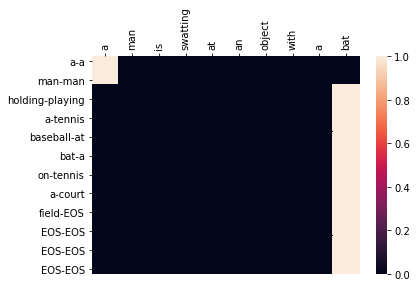

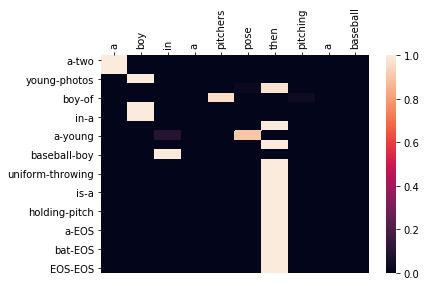

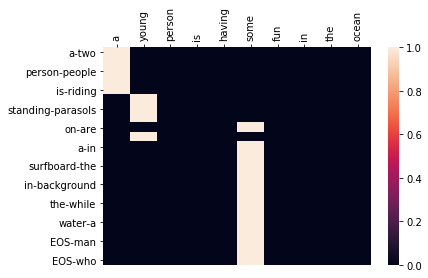

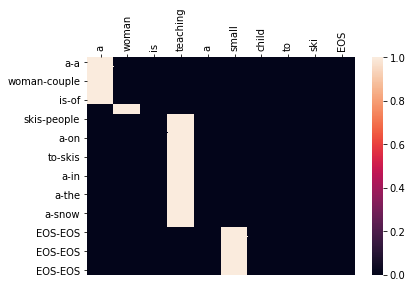

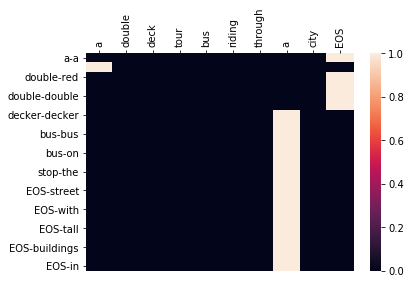



Example 1
INPUT >> a man is swatting at an object with a bat
PRED >> a man holding a baseball bat on a field
TRUE >> a man playing tennis at a tennis court
[BLEU] 0.11

Example 2
INPUT >> a boy in a pitchers pose then pitching a baseball
PRED >> a young boy in a baseball uniform is holding a bat
TRUE >> two photos of a young boy throwing a pitch
[BLEU] 0.15

Example 3
INPUT >> a young person is having some fun in the ocean
PRED >> a person is standing on a surfboard in the water
TRUE >> two people riding parasols are in the background while a man who is riding a jet ski is holding on to a rope
[BLEU] 0.03

Example 4
INPUT >> a woman is teaching a small child to ski
PRED >> a woman is skis a to a a a
TRUE >> a couple of people on skis in the snow
[BLEU] 0.06

Example 5
INPUT >> a double deck tour bus riding through a city
PRED >> a double double decker bus bus stop
TRUE >> a red double decker bus on the street with tall buildings in the background
[BLEU] 0.10

Step 50 average loss = 0

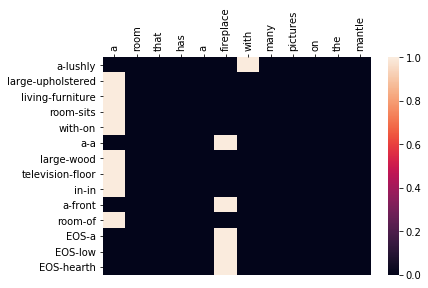

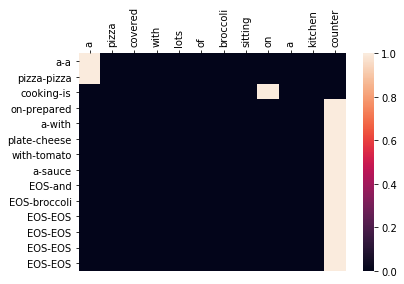

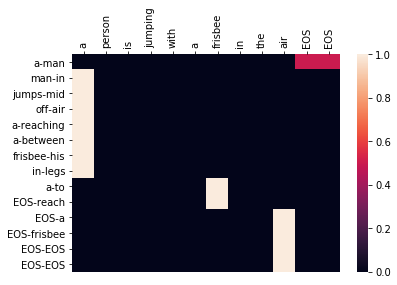

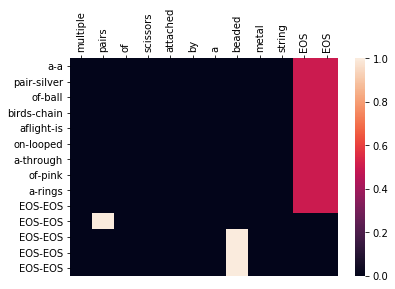

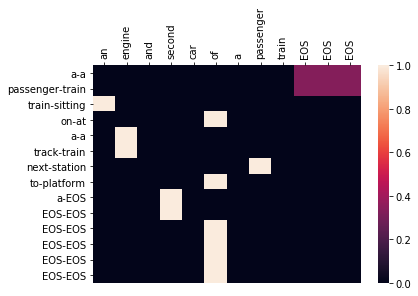



Example 1
INPUT >> a room that has a fireplace with many pictures on the mantle
PRED >> a large living room with a large television in a room
TRUE >> lushly upholstered furniture sits on a wood floor in front of a low hearth
[BLEU] 0.04

Example 2
INPUT >> a pizza covered with lots of broccoli sitting on a kitchen counter
PRED >> a pizza cooking on a plate with a
TRUE >> a pizza is prepared with cheese tomato sauce and broccoli
[BLEU] 0.10

Example 3
INPUT >> a person is jumping with a frisbee in the air
PRED >> a man jumps off a a frisbee in a
TRUE >> man in mid air reaching between his legs to reach a frisbee
[BLEU] 0.08

Example 4
INPUT >> multiple pairs of scissors attached by a beaded metal string
PRED >> a pair of birds aflight on a of a
TRUE >> a silver ball chain is looped through pink rings
[BLEU] 0.05

Example 5
INPUT >> an engine and second car of a passenger train
PRED >> a passenger train on a track next to a
TRUE >> a train sitting at a train station platform
[BLEU] 0.0

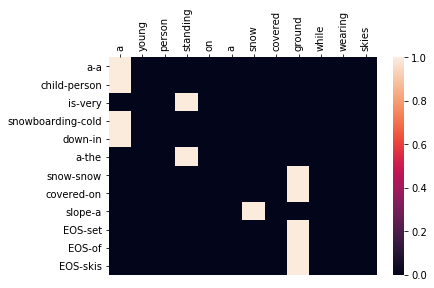

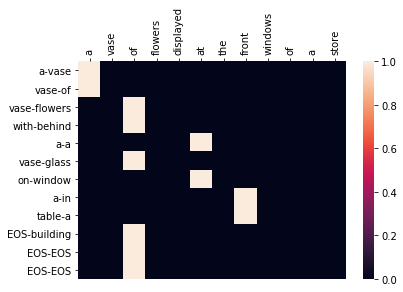

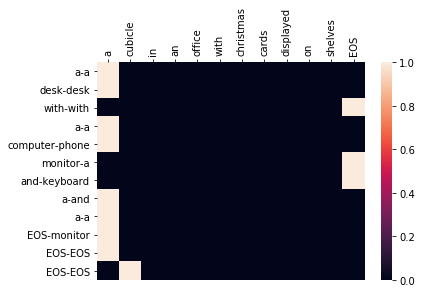

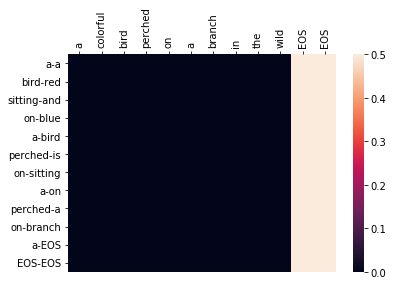

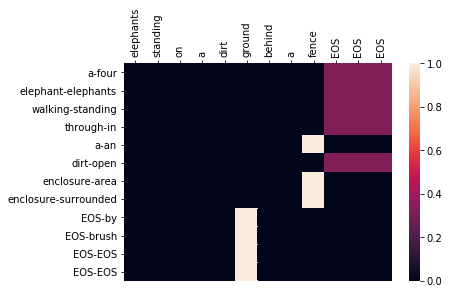



Example 1
INPUT >> a young person standing on a snow covered ground while wearing skies
PRED >> a child is snowboarding down a snow covered slope
TRUE >> a person very cold in the snow on a set of skis
[BLEU] 0.04

Example 2
INPUT >> a vase of flowers displayed at the front windows of a store
PRED >> a vase vase with a vase on a table
TRUE >> vase of flowers behind a glass window in a building
[BLEU] 0.06

Example 3
INPUT >> a cubicle in an office with christmas cards displayed on shelves
PRED >> a desk with a computer monitor and a a
TRUE >> a desk with a phone a keyboard and a monitor
[BLEU] 0.34

Example 4
INPUT >> a colorful bird perched on a branch in the wild
PRED >> a bird sitting on a perched on a perched on a
TRUE >> a red and blue bird is sitting on a branch
[BLEU] 0.16

Example 5
INPUT >> elephants standing on a dirt ground behind a fence
PRED >> a elephant walking through a dirt enclosure enclosure
TRUE >> four elephants standing in an open area surrounded by brush
[BLEU]

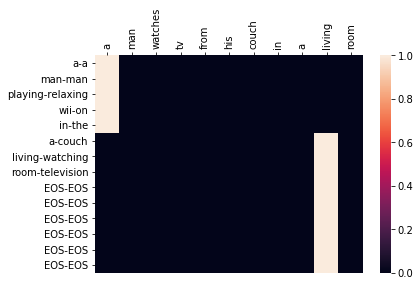

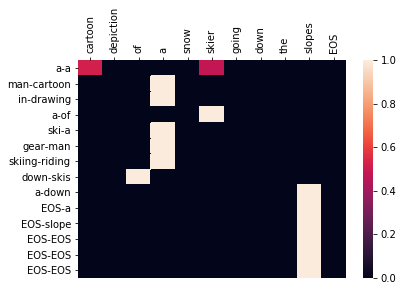

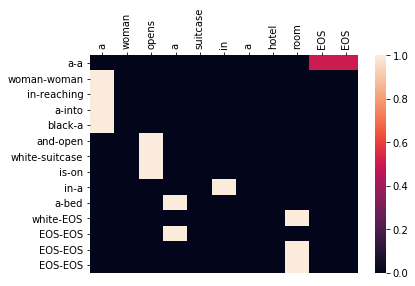

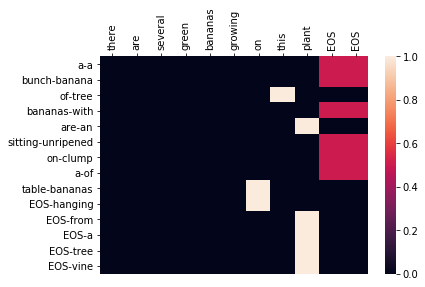

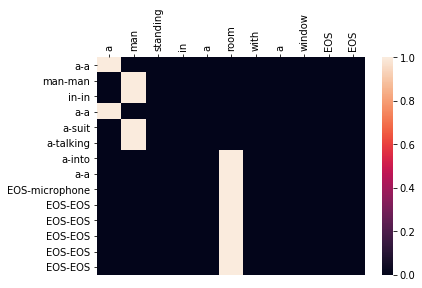



Example 1
INPUT >> a man watches tv from his couch in a living room
PRED >> a man playing wii in a living room
TRUE >> a man relaxing on the couch watching television
[BLEU] 0.11

Example 2
INPUT >> cartoon depiction of a snow skier going down the slopes
PRED >> a man in a ski gear skiing down a
TRUE >> a cartoon drawing of a man riding skis down a slope
[BLEU] 0.11

Example 3
INPUT >> a woman opens a suitcase in a hotel room
PRED >> a woman in a black and white is in a white
TRUE >> a woman reaching into a open suitcase on a bed
[BLEU] 0.09

Example 4
INPUT >> there are several green bananas growing on this plant
PRED >> a bunch of bananas are sitting on a table
TRUE >> a banana tree with an unripened clump of bananas hanging from a tree vine
[BLEU] 0.07

Example 5
INPUT >> a man standing in a room with a window
PRED >> a man in a a a a a
TRUE >> a man in a suit talking into a microphone
[BLEU] 0.32

Step 50 average loss = 0.006727 (time: 20.22)
Step 100 average loss = 0.012190 (tim

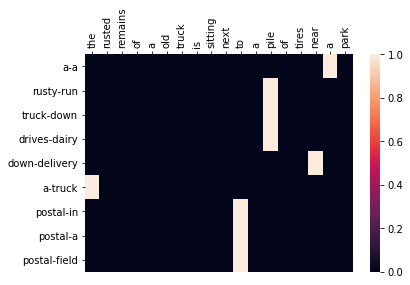

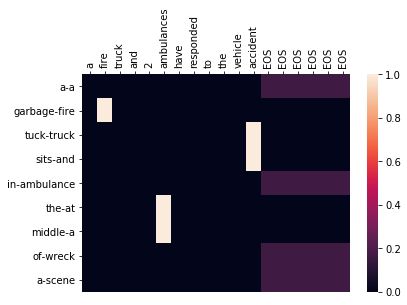

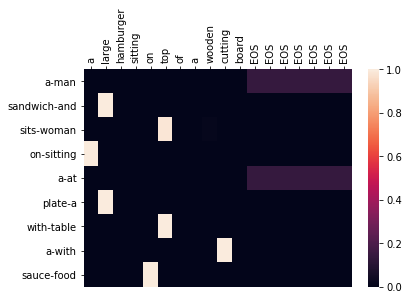

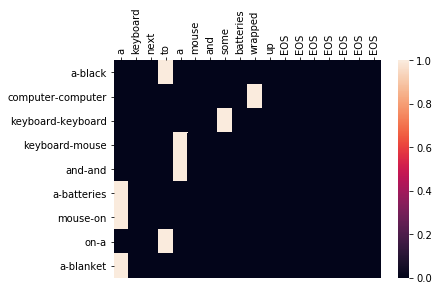

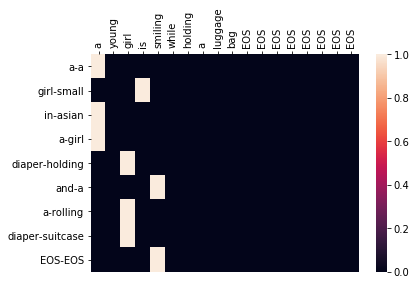



Example 1
INPUT >> the rusted remains of a old truck is sitting next to a pile of tires near a park
PRED >> a rusty truck drives down a postal postal postal
TRUE >> a run down dairy delivery truck in a field
[BLEU] 0.07

Example 2
INPUT >> a fire truck and 2 ambulances have responded to the vehicle accident
PRED >> a garbage tuck sits in the middle of a
TRUE >> a fire truck and ambulance at a wreck scene
[BLEU] 0.06

Example 3
INPUT >> a large hamburger sitting on top of a wooden cutting board
PRED >> a sandwich sits on a plate with a sauce
TRUE >> man and woman sitting at a table with food
[BLEU] 0.06

Example 4
INPUT >> a keyboard next to a mouse and some batteries wrapped up
PRED >> a computer keyboard keyboard and a mouse on a
TRUE >> black computer keyboard mouse and batteries on a blanket
[BLEU] 0.15

Example 5
INPUT >> a young girl is smiling while holding a luggage bag
PRED >> a girl in a diaper and a diaper
TRUE >> a small asian girl holding a rolling suitcase
[BLEU] 0.07

S

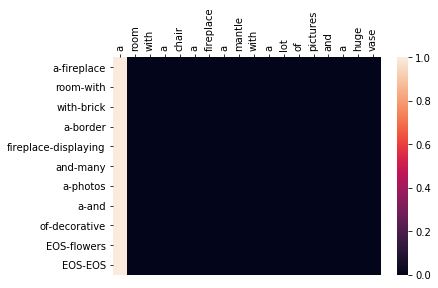

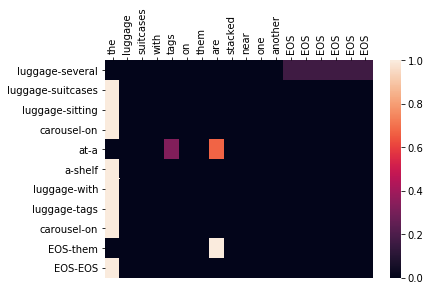

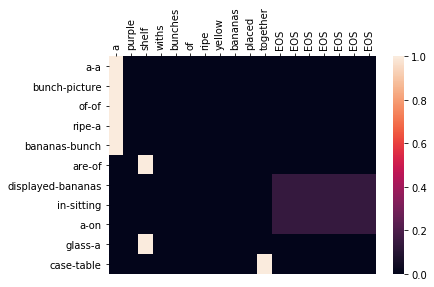

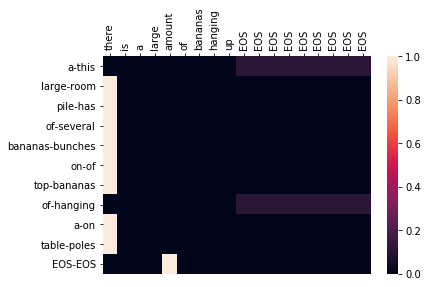

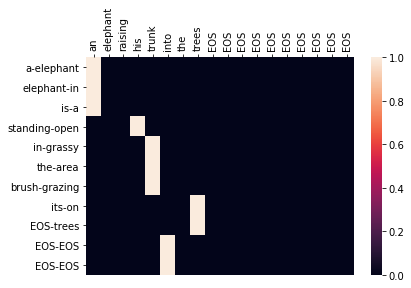



Example 1
INPUT >> a room with a chair a fireplace a mantle with a lot of pictures and a huge vase
PRED >> a room with a fireplace and a a of
TRUE >> fireplace with brick border displaying many photos and decorative flowers
[BLEU] 0.06

Example 2
INPUT >> the luggage suitcases with tags on them are stacked near one another
PRED >> luggage luggage luggage carousel at a luggage luggage carousel
TRUE >> several suitcases sitting on a shelf with tags on them
[BLEU] 0.04

Example 3
INPUT >> a purple shelf withs bunches of ripe yellow bananas placed together
PRED >> a bunch of ripe bananas are displayed in a glass case
TRUE >> a picture of a bunch of bananas sitting on a table
[BLEU] 0.16

Example 4
INPUT >> there is a large amount of bananas hanging up
PRED >> a large pile of bananas on top of a table
TRUE >> this room has several bunches of bananas hanging on poles
[BLEU] 0.09

Example 5
INPUT >> an elephant raising his trunk into the trees
PRED >> a elephant is standing in the brush its

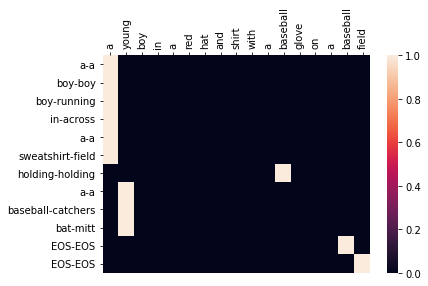

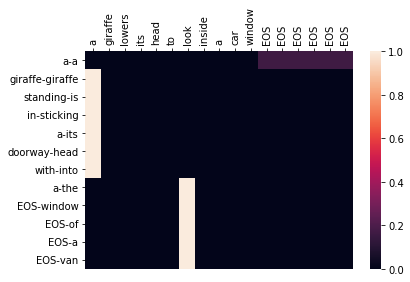

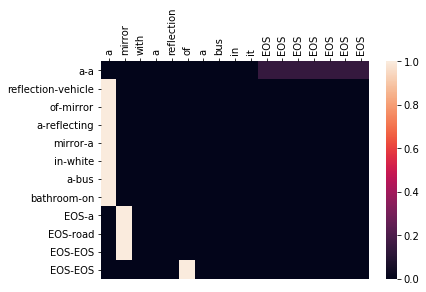

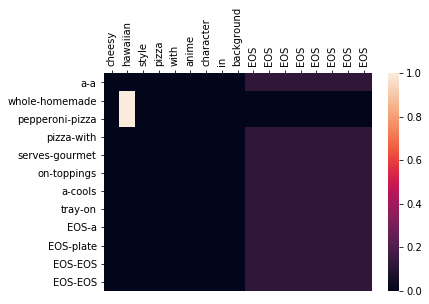

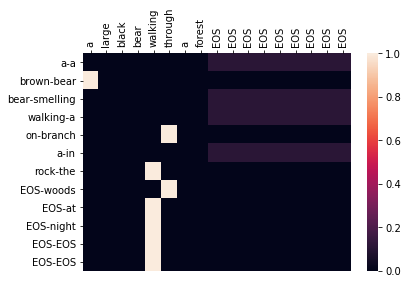



Example 1
INPUT >> a young boy in a red hat and shirt with a baseball glove on a baseball field
PRED >> a boy boy in a sweatshirt holding a baseball bat
TRUE >> a boy running across a field holding a catchers mitt
[BLEU] 0.13

Example 2
INPUT >> a giraffe lowers its head to look inside a car window
PRED >> a giraffe standing in a doorway with a
TRUE >> a giraffe is sticking its head into the window of a van
[BLEU] 0.07

Example 3
INPUT >> a mirror with a reflection of a bus in it
PRED >> a reflection of a mirror in a bathroom
TRUE >> a vehicle mirror reflecting a white bus on a road
[BLEU] 0.06

Example 4
INPUT >> cheesy hawaiian style pizza with anime character in background
PRED >> a whole pepperoni pizza serves on a tray
TRUE >> a homemade pizza with gourmet toppings cools on a plate
[BLEU] 0.10

Example 5
INPUT >> a large black bear walking through a forest
PRED >> a brown bear walking on a rock
TRUE >> a bear smelling a branch in the woods at night
[BLEU] 0.06

Step 50 average l

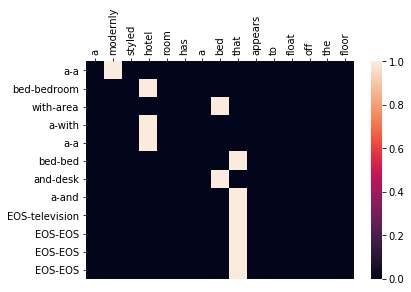

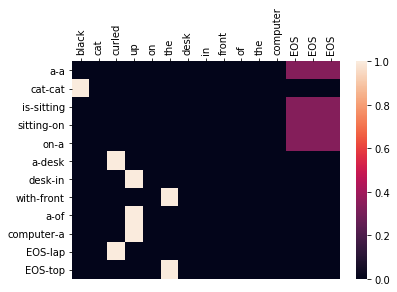

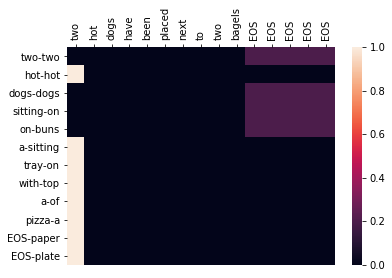

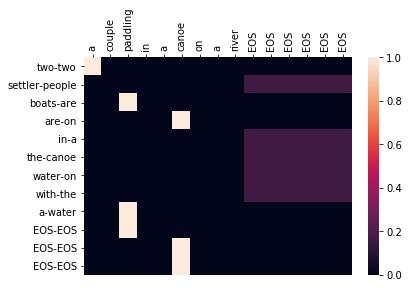

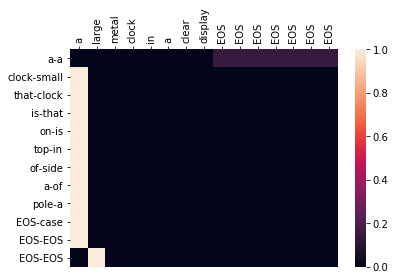



Example 1
INPUT >> a modernly styled hotel room has a bed that appears to float off the floor
PRED >> a bed with a a bed and a
TRUE >> a bedroom area with a bed desk and television
[BLEU] 0.15

Example 2
INPUT >> black cat curled up on the desk in front of the computer
PRED >> a cat is sitting on a desk with a computer
TRUE >> a cat sitting on a desk in front of a lap top
[BLEU] 0.27

Example 3
INPUT >> two hot dogs have been placed next to two bagels
PRED >> two hot dogs sitting on a tray with a pizza
TRUE >> two hot dogs on buns sitting on top of a paper plate
[BLEU] 0.17

Example 4
INPUT >> a couple paddling in a canoe on a river
PRED >> two settler boats are in the water with a
TRUE >> two people are on a canoe on the water
[BLEU] 0.12

Example 5
INPUT >> a large metal clock in a clear display
PRED >> a clock that is on top of a pole
TRUE >> a small clock that is in side of a case
[BLEU] 0.21

Step 50 average loss = 0.006535 (time: 20.18)
Step 100 average loss = 0.013763 (time: 9

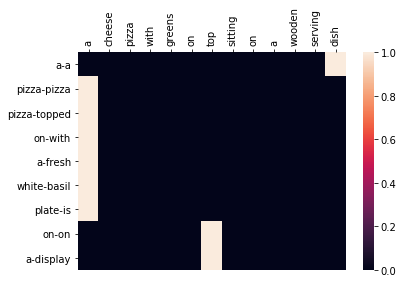

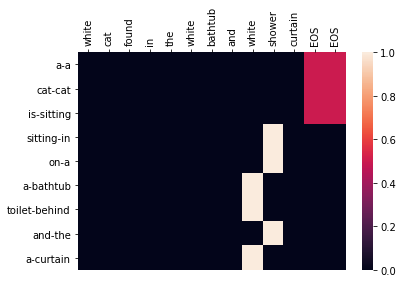

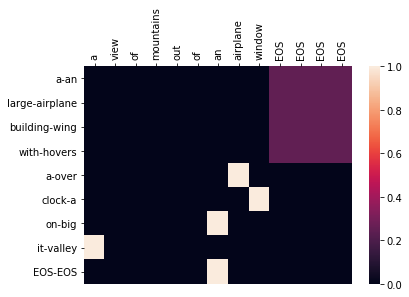

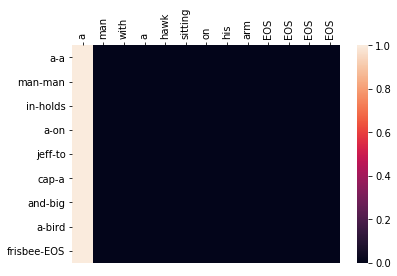

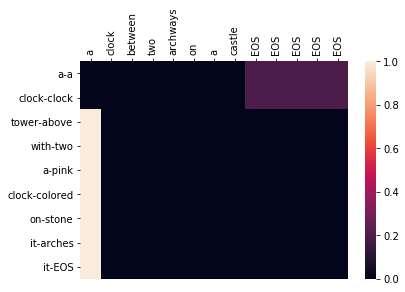



Example 1
INPUT >> a cheese pizza with greens on top sitting on a wooden serving dish
PRED >> a pizza pizza on a white plate on a
TRUE >> a pizza topped with fresh basil is on display
[BLEU] 0.11

Example 2
INPUT >> white cat found in the white bathtub and white shower curtain
PRED >> a cat is sitting on a toilet and a
TRUE >> a cat sitting in a bathtub behind the curtain
[BLEU] 0.11

Example 3
INPUT >> a view of mountains out of an airplane window
PRED >> a large building with a clock on it
TRUE >> an airplane wing hovers over a big valley
[BLEU] 0.06

Example 4
INPUT >> a man with a hawk sitting on his arm
PRED >> a man in a jeff cap and a frisbee
TRUE >> a man holds on to a big bird
[BLEU] 0.11

Example 5
INPUT >> a clock between two archways on a castle
PRED >> a clock tower with a clock on it it
TRUE >> a clock above two pink colored stone arches
[BLEU] 0.10

Step 50 average loss = 0.005750 (time: 20.79)
Step 100 average loss = 0.006718 (time: 9.90)
Step 150 average loss = 0.005

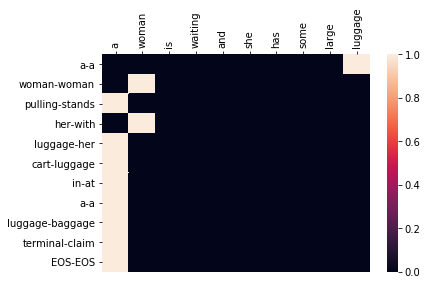

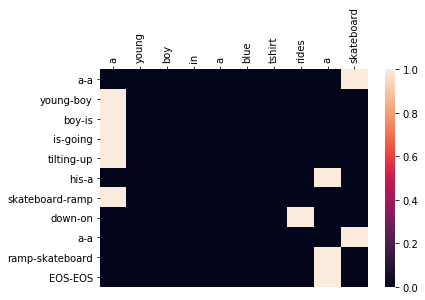

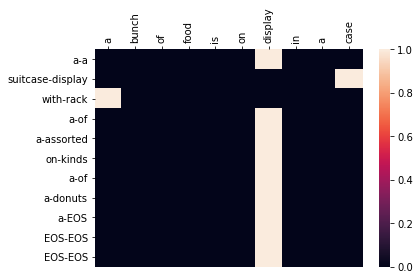

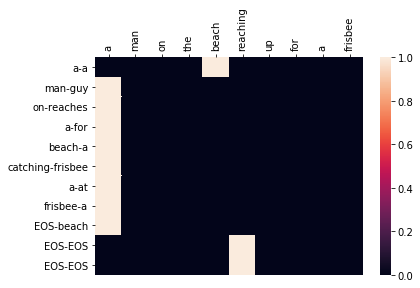

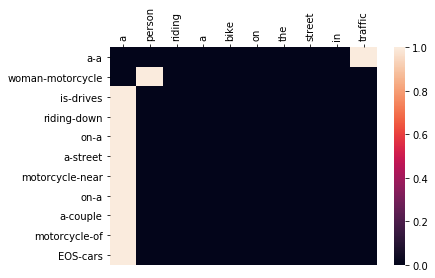



Example 1
INPUT >> a woman is waiting and she has some large luggage
PRED >> a woman pulling her luggage cart in a luggage terminal
TRUE >> a woman stands with her luggage at a baggage claim
[BLEU] 0.13

Example 2
INPUT >> a young boy in a blue tshirt rides a skateboard
PRED >> a young boy is tilting his skateboard down a ramp
TRUE >> a boy is going up a ramp on a skateboard
[BLEU] 0.13

Example 3
INPUT >> a bunch of food is on display in a case
PRED >> a suitcase with a a on a a a
TRUE >> a display rack of assorted kinds of donuts
[BLEU] 0.05

Example 4
INPUT >> a man on the beach reaching up for a frisbee
PRED >> a man on a beach catching a frisbee
TRUE >> a guy reaches for a frisbee at a beach
[BLEU] 0.15

Example 5
INPUT >> a person riding a bike on the street in traffic
PRED >> a woman is riding on a motorcycle on a motorcycle
TRUE >> a motorcycle drives down a street near a couple of cars
[BLEU] 0.09

Step 50 average loss = 0.007743 (time: 21.00)
Step 100 average loss = 0.00659

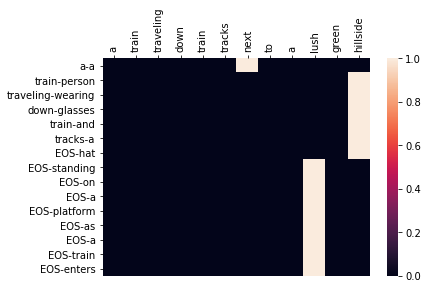

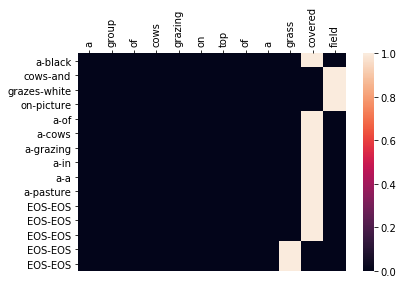

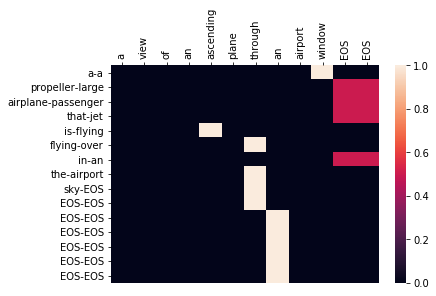

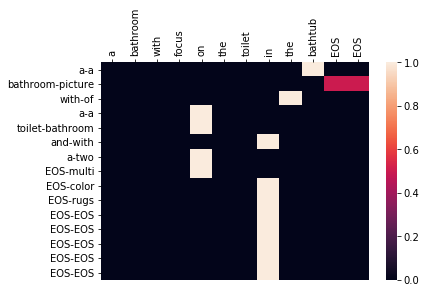

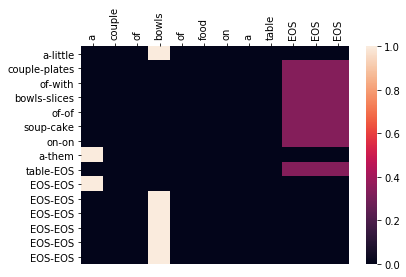



Example 1
INPUT >> a train traveling down train tracks next to a lush green hillside
PRED >> a train traveling down train tracks
TRUE >> a person wearing glasses and a hat standing on a platform as a train enters
[BLEU] 0.04

Example 2
INPUT >> a group of cows grazing on top of a grass covered field
PRED >> a cows grazes on a a a a a a
TRUE >> black and white picture of cows grazing in a pasture
[BLEU] 0.05

Example 3
INPUT >> a view of an ascending plane through an airport window
PRED >> a propeller airplane that is flying in the sky
TRUE >> a large passenger jet flying over an airport
[BLEU] 0.06

Example 4
INPUT >> a bathroom with focus on the toilet in the bathtub
PRED >> a bathroom with a toilet and a
TRUE >> a picture of a bathroom with two multi color rugs
[BLEU] 0.17

Example 5
INPUT >> a couple of bowls of food on a table
PRED >> a couple of bowls of soup on a table
TRUE >> little plates with slices of cake on them
[BLEU] 0.06

Step 50 average loss = 0.007484 (time: 20.54)
S

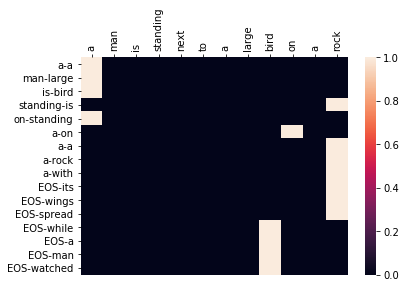

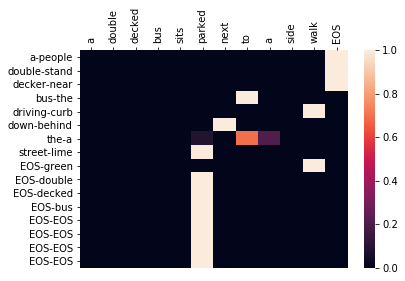

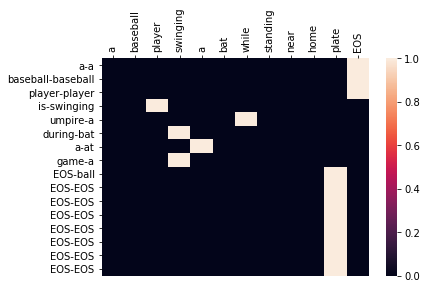

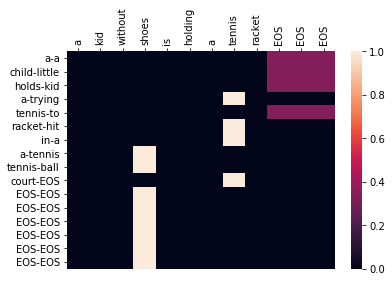

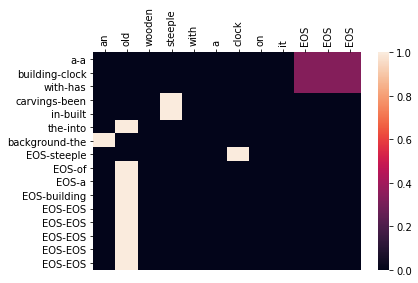



Example 1
INPUT >> a man is standing next to a large bird on a rock
PRED >> a man is standing on a a a a
TRUE >> a large bird is standing on a rock with its wings spread while a man watched
[BLEU] 0.17

Example 2
INPUT >> a double decked bus sits parked next to a side walk
PRED >> a double decker bus driving down the street
TRUE >> people stand near the curb behind a lime green double decked bus
[BLEU] 0.05

Example 3
INPUT >> a baseball player swinging a bat while standing near home plate
PRED >> a baseball player is umpire during a game
TRUE >> a baseball player swinging a bat at a ball
[BLEU] 0.19

Example 4
INPUT >> a kid without shoes is holding a tennis racket
PRED >> a child holds a tennis racket in a tennis court
TRUE >> a little kid trying to hit a tennis ball
[BLEU] 0.09

Example 5
INPUT >> an old wooden steeple with a clock on it
PRED >> a building with carvings in the background
TRUE >> a clock has been built into the steeple of a building
[BLEU] 0.08

Step 50 average los

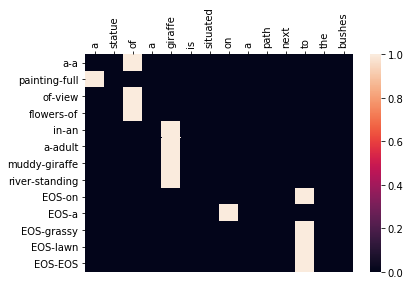

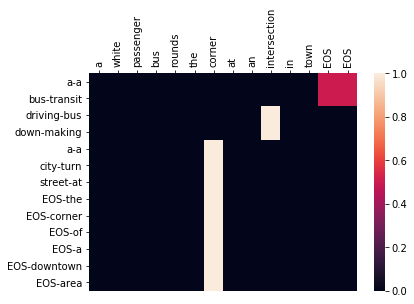

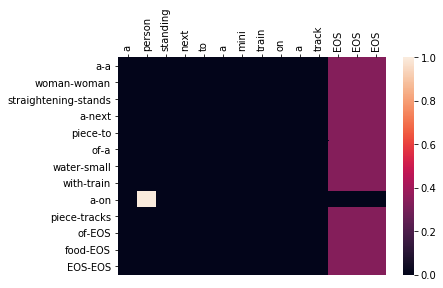

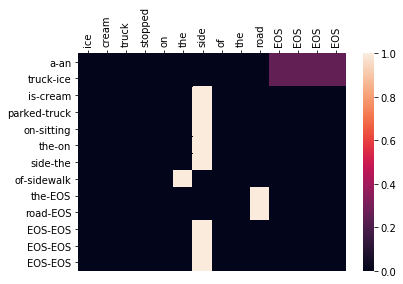

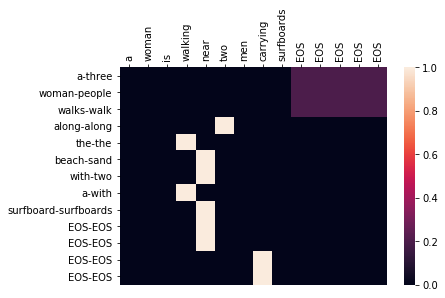



Example 1
INPUT >> a statue of a giraffe is situated on a path next to the bushes
PRED >> a painting of flowers in a muddy river
TRUE >> a full view of an adult giraffe standing on a grassy lawn
[BLEU] 0.04

Example 2
INPUT >> a white passenger bus rounds the corner at an intersection in town
PRED >> a bus driving down a city street
TRUE >> a transit bus making a turn at the corner of a downtown area
[BLEU] 0.04

Example 3
INPUT >> a person standing next to a mini train on a track
PRED >> a woman straightening a piece of water with a piece of food
TRUE >> a woman stands next to a small train on tracks
[BLEU] 0.07

Example 4
INPUT >> ice cream truck stopped on the side of the road
PRED >> a truck is parked on the side of the road
TRUE >> an ice cream truck sitting on the sidewalk
[BLEU] 0.09

Example 5
INPUT >> a woman is walking near two men carrying surfboards
PRED >> a woman walks along the beach with a surfboard
TRUE >> three people walk along the sand two with surfboards
[BLEU] 0

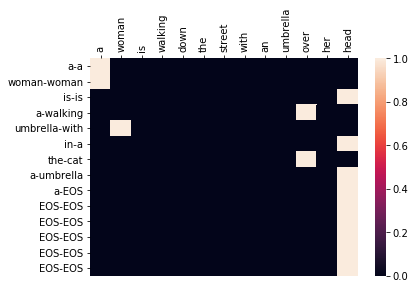

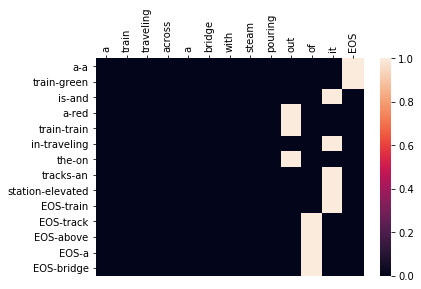

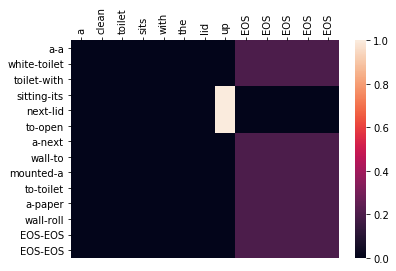

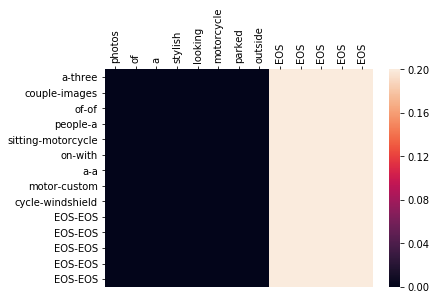

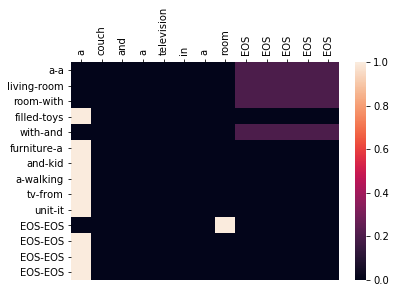



Example 1
INPUT >> a woman is walking down the street with an umbrella over her head
PRED >> a woman is a umbrella in the a a
TRUE >> a woman is walking with a cat umbrella
[BLEU] 0.20

Example 2
INPUT >> a train traveling across a bridge with steam pouring out of it
PRED >> a train is a train in the tracks station
TRUE >> a green and red train traveling on an elevated train track above a bridge
[BLEU] 0.04

Example 3
INPUT >> a clean toilet sits with the lid up
PRED >> a white toilet sitting next to a wall mounted to a wall
TRUE >> a toilet with its lid open next to a toilet paper roll
[BLEU] 0.14

Example 4
INPUT >> photos of a stylish looking motorcycle parked outside
PRED >> a couple of people sitting on a motor cycle
TRUE >> three images of a motorcycle with a custom windshield
[BLEU] 0.06

Example 5
INPUT >> a couch and a television in a room
PRED >> a living room filled with furniture and a tv unit
TRUE >> a room with toys and a kid walking from it
[BLEU] 0.11

Step 50 average

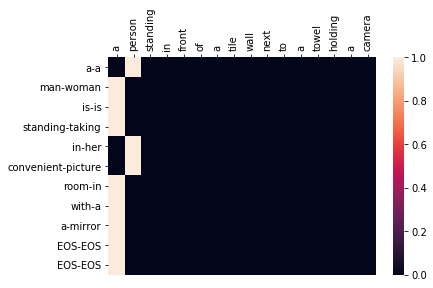

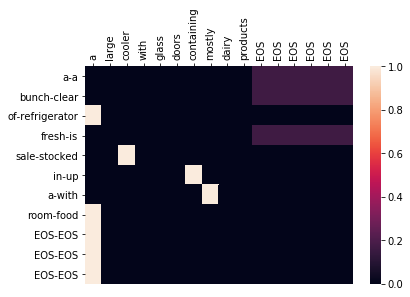

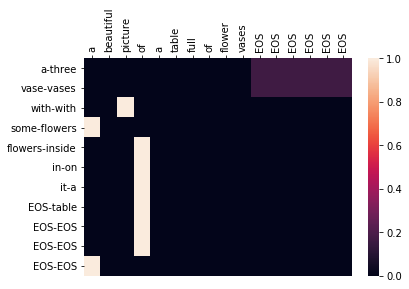

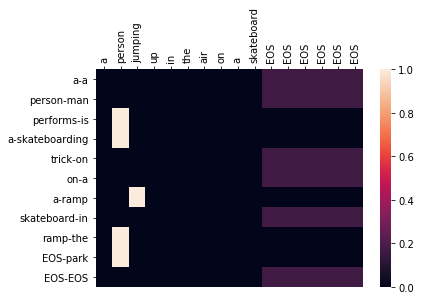

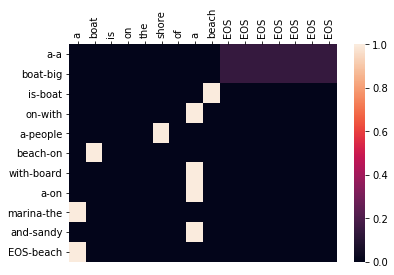



Example 1
INPUT >> a person standing in front of a tile wall next to a towel holding a camera
PRED >> a man is standing in convenient room with a
TRUE >> a woman is taking her picture in a mirror
[BLEU] 0.07

Example 2
INPUT >> a large cooler with glass doors containing mostly dairy products
PRED >> a bunch of fresh sale in a room
TRUE >> a clear refrigerator is stocked up with food
[BLEU] 0.06

Example 3
INPUT >> a beautiful picture of a table full of flower vases
PRED >> a vase with some flowers in it
TRUE >> three vases with flowers inside on a table
[BLEU] 0.07

Example 4
INPUT >> a person jumping up in the air on a skateboard
PRED >> a person performs a trick on a skateboard ramp
TRUE >> a man is skateboarding on a ramp in the park
[BLEU] 0.10

Example 5
INPUT >> a boat is on the shore of a beach
PRED >> a boat is on a beach with a marina and
TRUE >> a big boat with people on board on the sandy beach
[BLEU] 0.06

Step 50 average loss = 0.007998 (time: 20.59)
Step 100 average los

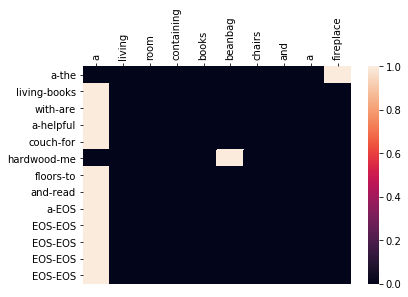

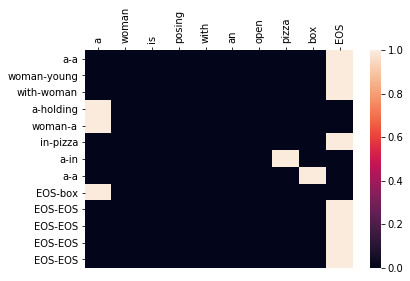

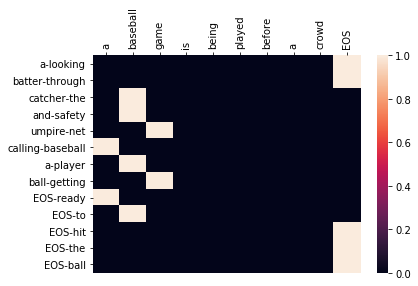

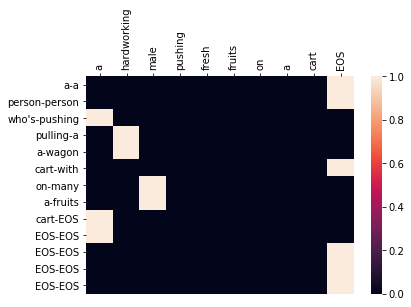

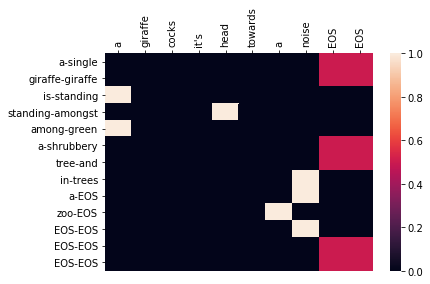



Example 1
INPUT >> a living room containing books beanbag chairs and a fireplace
PRED >> a living with a couch hardwood floors and a
TRUE >> the books are helpful for me to read
[BLEU] 0.00

Example 2
INPUT >> a woman is posing with an open pizza box
PRED >> a woman with a woman in a a
TRUE >> a young woman holding a pizza in a box
[BLEU] 0.12

Example 3
INPUT >> a baseball game is being played before a crowd
PRED >> a batter catcher and umpire calling a ball
TRUE >> looking through the safety net baseball player getting ready to hit the ball
[BLEU] 0.03

Example 4
INPUT >> a hardworking male pushing fresh fruits on a cart
PRED >> a person who's pulling a cart on a cart
TRUE >> a person pushing a wagon with many fruits
[BLEU] 0.11

Example 5
INPUT >> a giraffe cocks it's head towards a noise
PRED >> a giraffe is standing among a tree in a zoo
TRUE >> single giraffe standing amongst green shrubbery and trees
[BLEU] 0.05

Step 50 average loss = 0.006371 (time: 20.22)
Step 100 average l

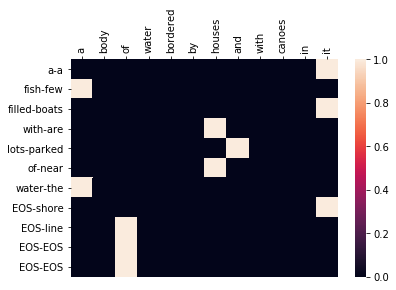

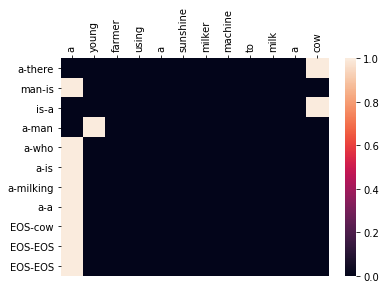

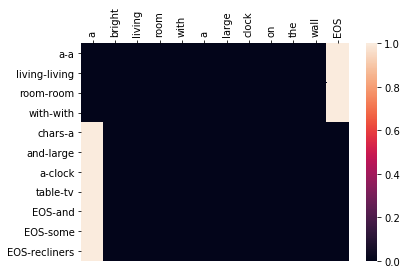

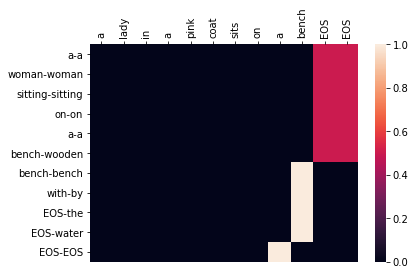

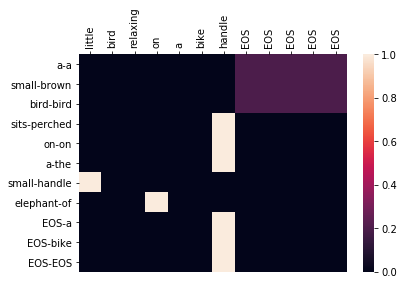



Example 1
INPUT >> a body of water bordered by houses and with canoes in it
PRED >> a fish filled with lots of water
TRUE >> a few boats are parked near the shore line
[BLEU] 0.05

Example 2
INPUT >> a young farmer using a sunshine milker machine to milk a cow
PRED >> a man is a a a a a
TRUE >> there is a man who is milking a cow
[BLEU] 0.14

Example 3
INPUT >> a bright living room with a large clock on the wall
PRED >> a living room with chars and a table
TRUE >> a living room with a large clock tv and some recliners
[BLEU] 0.26

Example 4
INPUT >> a lady in a pink coat sits on a bench
PRED >> a woman sitting on a bench bench with
TRUE >> a woman sitting on a wooden bench by the water
[BLEU] 0.42

Example 5
INPUT >> little bird relaxing on a bike handle
PRED >> a small bird sits on a small elephant
TRUE >> a brown bird perched on the handle of a bike
[BLEU] 0.06

Step 50 average loss = 0.004573 (time: 21.23)
Step 100 average loss = 0.005854 (time: 10.09)
Step 150 average loss = 0.00

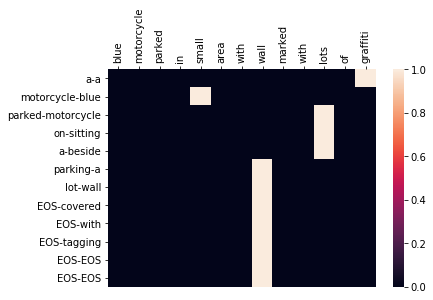

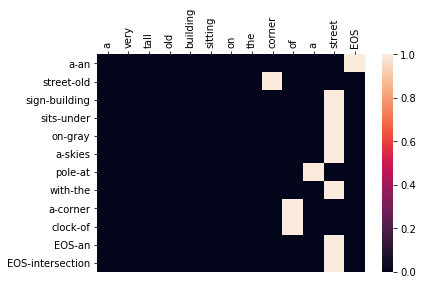

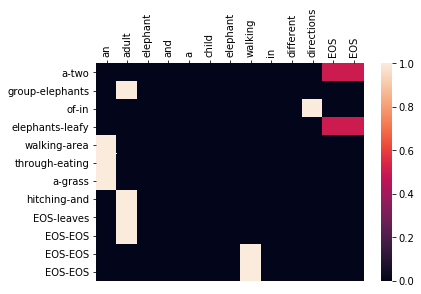

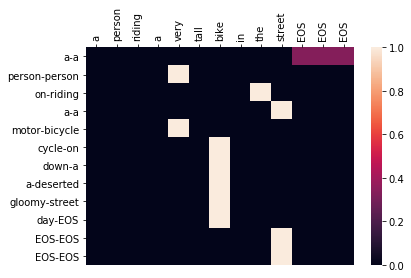

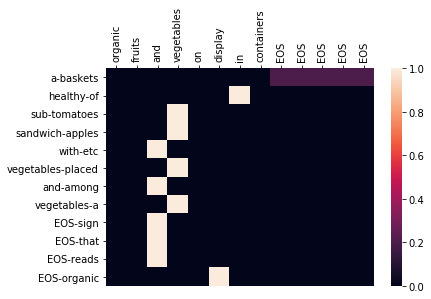



Example 1
INPUT >> blue motorcycle parked in small area with wall marked with lots of graffiti
PRED >> a motorcycle parked on a parking lot
TRUE >> a blue motorcycle sitting beside a wall covered with tagging
[BLEU] 0.06

Example 2
INPUT >> a very tall old building sitting on the corner of a street
PRED >> a street sign sits on a pole with a clock
TRUE >> an old building under gray skies at the corner of an intersection
[BLEU] 0.00

Example 3
INPUT >> an adult elephant and a child elephant walking in different directions
PRED >> a group of elephants walking through a hitching
TRUE >> two elephants in leafy area eating grass and leaves
[BLEU] 0.05

Example 4
INPUT >> a person riding a very tall bike in the street
PRED >> a person on a motor cycle down a gloomy day
TRUE >> a person riding a bicycle on a deserted street
[BLEU] 0.13

Example 5
INPUT >> organic fruits and vegetables on display in containers
PRED >> a healthy sub sandwich with vegetables and vegetables
TRUE >> baskets of t

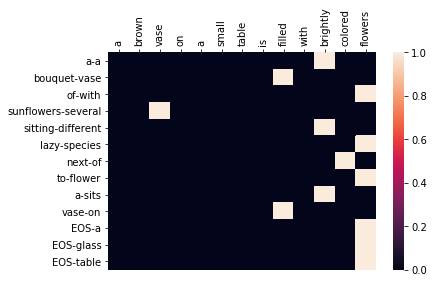

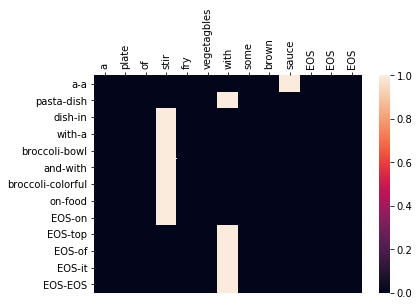

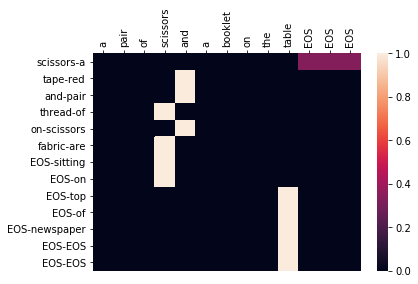

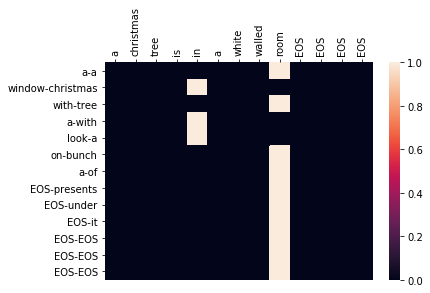

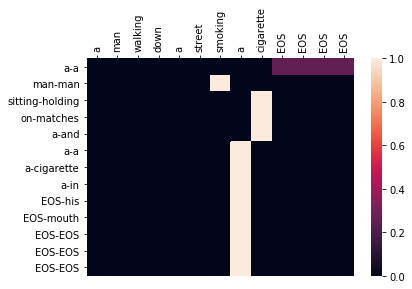



Example 1
INPUT >> a brown vase on a small table is filled with brightly colored flowers
PRED >> a bouquet of sunflowers sitting lazy next to a vase
TRUE >> a vase with several different species of flower sits on a glass table
[BLEU] 0.07

Example 2
INPUT >> a plate of stir fry vegetagbles with some brown sauce
PRED >> a pasta dish with broccoli and broccoli on
TRUE >> a dish in a bowl with colorful food on top of it
[BLEU] 0.05

Example 3
INPUT >> a pair of scissors and a booklet on the table
PRED >> scissors tape and thread on fabric
TRUE >> a red pair of scissors are sitting on top of newspaper
[BLEU] 0.04

Example 4
INPUT >> a christmas tree is in a white walled room
PRED >> a window with a look on a
TRUE >> a christmas tree with a bunch of presents under it
[BLEU] 0.09

Example 5
INPUT >> a man walking down a street smoking a cigarette
PRED >> a man sitting on a a a a
TRUE >> a man holding matches and a cigarette in his mouth
[BLEU] 0.10

Step 50 average loss = 0.005639 (time: 2

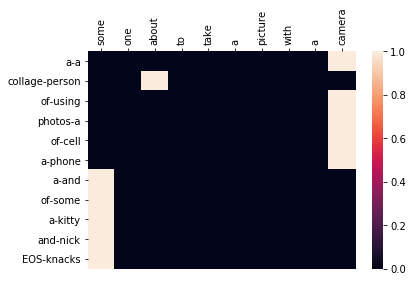

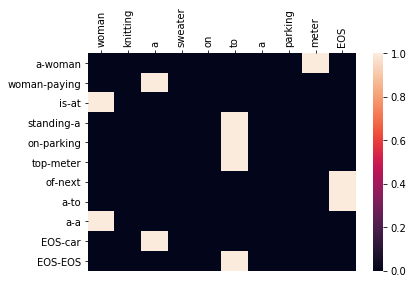

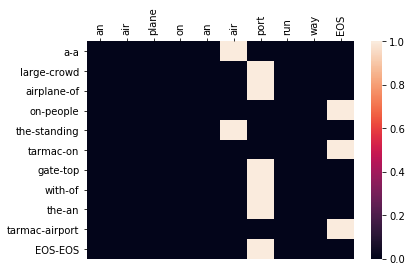

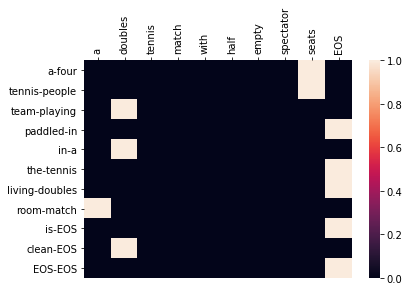

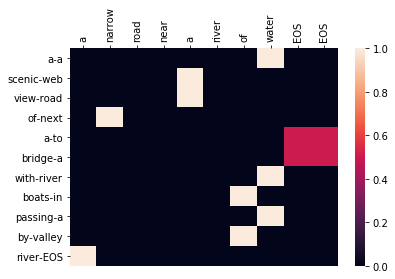



Example 1
INPUT >> some one about to take a picture with a camera
PRED >> a collage of photos of a a of a and
TRUE >> a person using a cell phone and some kitty nick knacks
[BLEU] 0.05

Example 2
INPUT >> woman knitting a sweater on to a parking meter
PRED >> a woman is standing on top of a a
TRUE >> woman paying at a parking meter next to a car
[BLEU] 0.06

Example 3
INPUT >> an air plane on an air port run way
PRED >> a large airplane on the tarmac gate with the tarmac
TRUE >> a crowd of people standing on top of an airport
[BLEU] 0.05

Example 4
INPUT >> a doubles tennis match with half empty spectator seats
PRED >> a tennis team paddled in the living room is clean
TRUE >> four people playing in a tennis doubles match
[BLEU] 0.09

Example 5
INPUT >> a narrow road near a river of water
PRED >> a scenic view of a bridge with boats passing by river
TRUE >> a web road next to a river in a valley
[BLEU] 0.05

Step 50 average loss = 0.005955 (time: 20.92)
Step 100 average loss = 0.00548

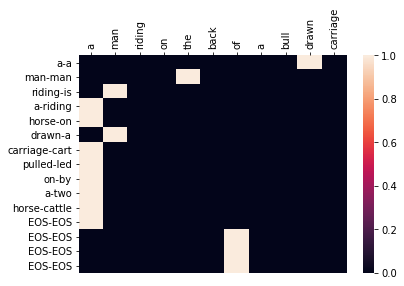

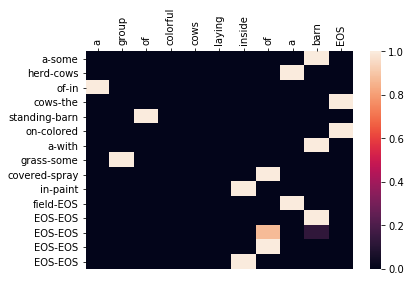

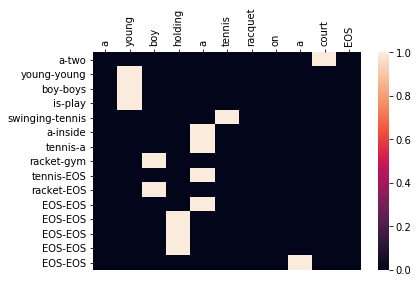

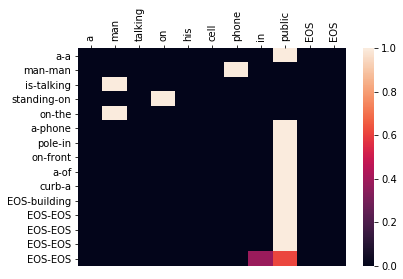

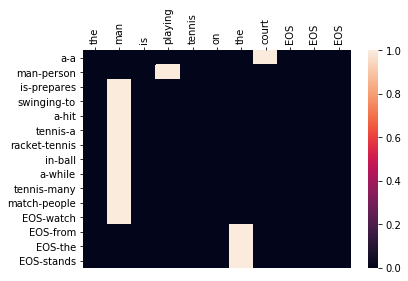



Example 1
INPUT >> a man riding on the back of a bull drawn carriage
PRED >> a man riding a horse drawn carriage pulled on a horse
TRUE >> a man is riding on a cart led by two cattle
[BLEU] 0.11

Example 2
INPUT >> a group of colorful cows laying inside of a barn
PRED >> a herd of cows standing on a grass covered in field
TRUE >> some cows in the barn colored with some spray paint
[BLEU] 0.04

Example 3
INPUT >> a young boy holding a tennis racquet on a court
PRED >> a young boy is swinging a tennis racket tennis racket
TRUE >> two young boys play tennis inside a gym
[BLEU] 0.06

Example 4
INPUT >> a man talking on his cell phone in public
PRED >> a man is standing on a pole on a curb
TRUE >> a man talking on the phone in front of a building
[BLEU] 0.09

Example 5
INPUT >> the man is playing tennis on the court
PRED >> a man is swinging a tennis racket in a tennis match
TRUE >> a person prepares to hit a tennis ball while many people watch from the stands
[BLEU] 0.06

Step 50 average

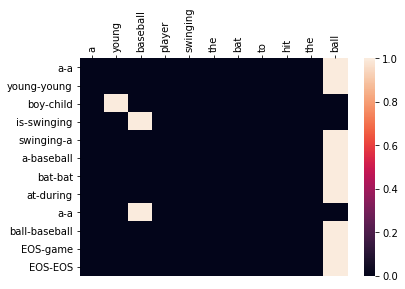

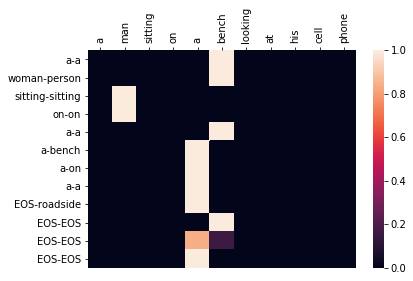

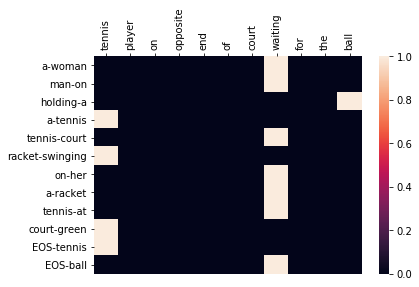

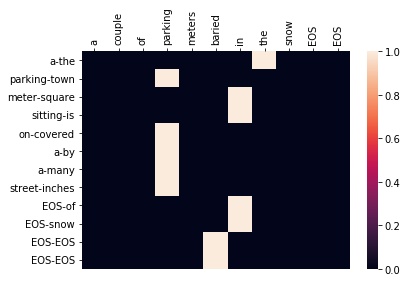

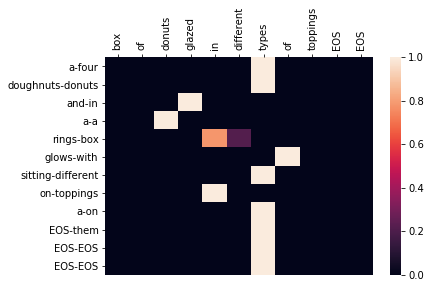



Example 1
INPUT >> a young baseball player swinging the bat to hit the ball
PRED >> a young boy is swinging a bat at a ball
TRUE >> a young child swinging a baseball bat during a baseball game
[BLEU] 0.12

Example 2
INPUT >> a man sitting on a bench looking at his cell phone
PRED >> a woman sitting on a a a a
TRUE >> a person sitting on a bench on a roadside
[BLEU] 0.21

Example 3
INPUT >> tennis player on opposite end of court waiting for the ball
PRED >> a man holding a tennis racket on a tennis court
TRUE >> woman on a tennis court swinging her racket at green tennis ball
[BLEU] 0.24

Example 4
INPUT >> a couple of parking meters baried in the snow
PRED >> a parking meter sitting on a a street
TRUE >> the town square is covered by many inches of snow
[BLEU] 0.00

Example 5
INPUT >> box of donuts glazed in different types of toppings
PRED >> a doughnuts and a rings glows sitting on a
TRUE >> four donuts in a box with different toppings on them
[BLEU] 0.05

Step 50 average loss = 0.

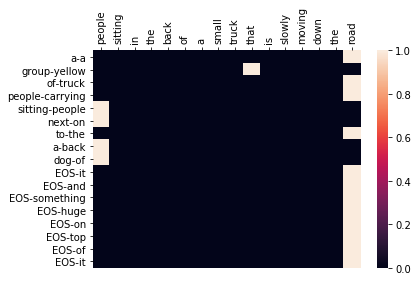

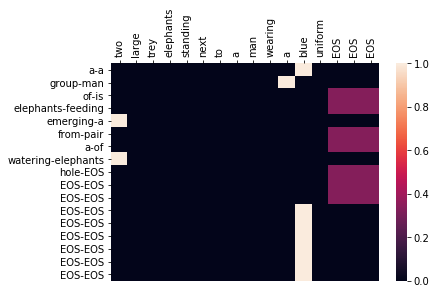

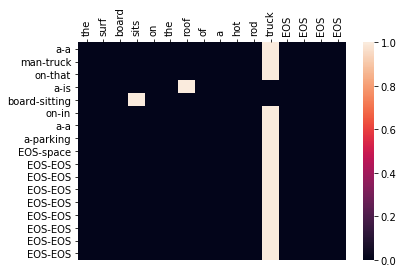

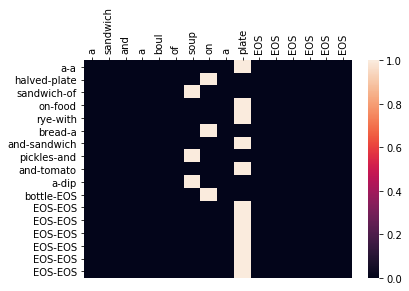

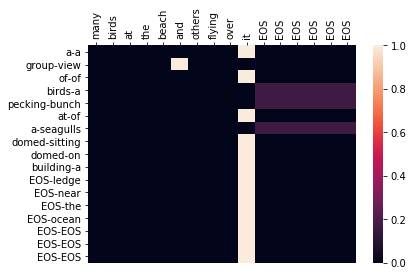



Example 1
INPUT >> people sitting in the back of a small truck that is slowly moving down the road
PRED >> a group of people sitting next to a dog
TRUE >> a yellow truck carrying people on the back of it and something huge on top of it
[BLEU] 0.03

Example 2
INPUT >> two large trey elephants standing next to a man wearing a blue uniform
PRED >> a group of elephants emerging from a watering hole
TRUE >> a man is feeding a pair of elephants
[BLEU] 0.11

Example 3
INPUT >> the surf board sits on the roof of a hot rod truck
PRED >> a man on a board on a a
TRUE >> a truck that is sitting in a parking space
[BLEU] 0.06

Example 4
INPUT >> a sandwich and a boul of soup on a plate
PRED >> a halved sandwich on rye bread and pickles and a bottle
TRUE >> a plate of food with a sandwich and tomato dip
[BLEU] 0.05

Example 5
INPUT >> many birds at the beach and others flying over it
PRED >> a group of birds pecking at a domed domed building
TRUE >> a view of a bunch of seagulls sitting on a ledge

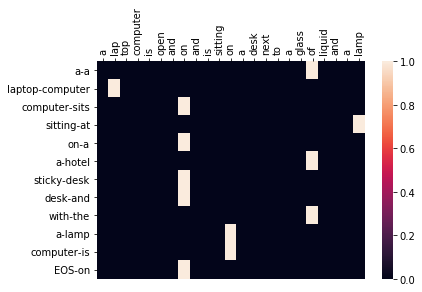

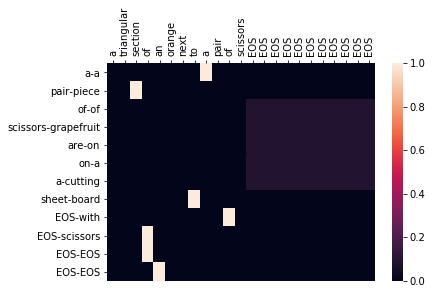

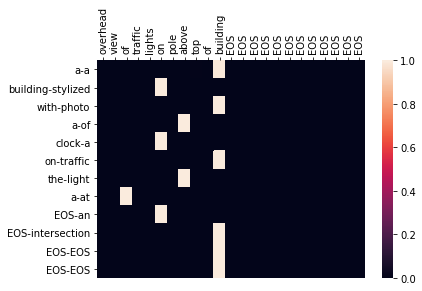

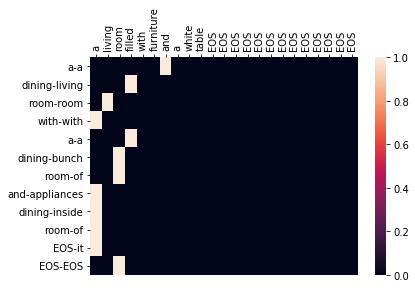

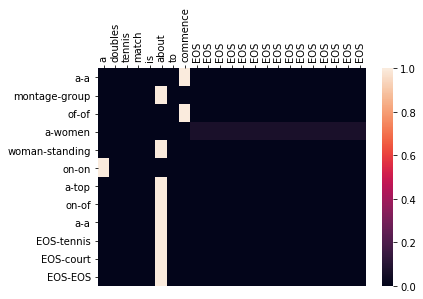



Example 1
INPUT >> a lap top computer is open and on and is sitting on a desk next to a glass of liquid and a lamp
PRED >> a laptop computer sitting on a sticky desk with a computer
TRUE >> a computer sits at a hotel desk and the lamp is on
[BLEU] 0.09

Example 2
INPUT >> a triangular section of an orange next to a pair of scissors
PRED >> a pair of scissors are on a sheet
TRUE >> a piece of grapefruit on a cutting board with scissors
[BLEU] 0.11

Example 3
INPUT >> overhead view of traffic lights on pole above top of building
PRED >> a building with a clock on the a
TRUE >> a stylized photo of a traffic light at an intersection
[BLEU] 0.05

Example 4
INPUT >> a living room filled with furniture and a white table
PRED >> a dining room with a dining room and dining room
TRUE >> a living room with a bunch of appliances inside of it
[BLEU] 0.15

Example 5
INPUT >> a doubles tennis match is about to commence
PRED >> a montage of a woman on a on a
TRUE >> a group of women standing on top 

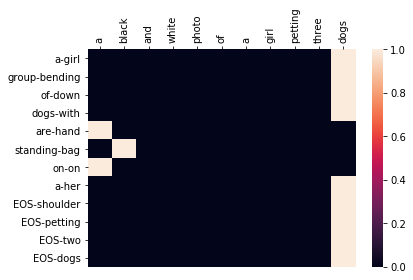

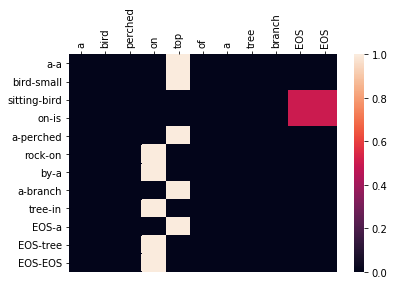

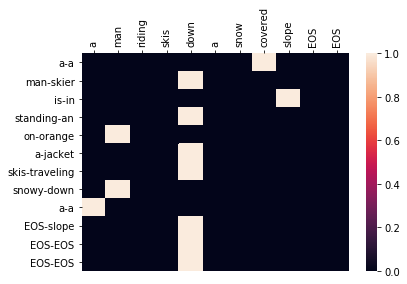

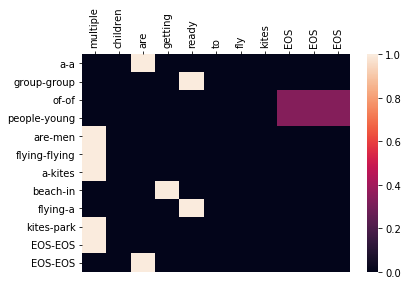

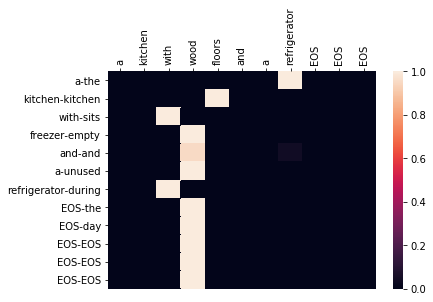



Example 1
INPUT >> a black and white photo of a girl petting three dogs
PRED >> a group of dogs are standing on a
TRUE >> girl bending down with hand bag on her shoulder petting two dogs
[BLEU] 0.04

Example 2
INPUT >> a bird perched on top of a tree branch
PRED >> a bird sitting on a rock by a tree
TRUE >> a small bird is perched on a branch in a tree
[BLEU] 0.12

Example 3
INPUT >> a man riding skis down a snow covered slope
PRED >> a man is standing on a skis snowy a
TRUE >> a skier in an orange jacket traveling down a slope
[BLEU] 0.05

Example 4
INPUT >> multiple children are getting ready to fly kites
PRED >> a group of people are flying a beach flying kites
TRUE >> a group of young men flying kites in a park
[BLEU] 0.21

Example 5
INPUT >> a kitchen with wood floors and a refrigerator
PRED >> a kitchen with freezer and a refrigerator
TRUE >> the kitchen sits empty and unused during the day
[BLEU] 0.06

Step 50 average loss = 0.005734 (time: 20.88)
Step 100 average loss = 0.006

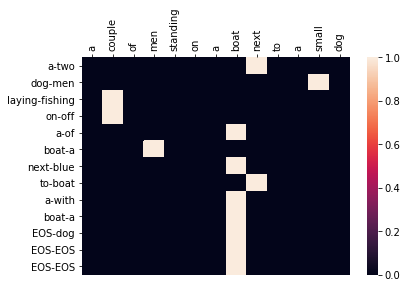

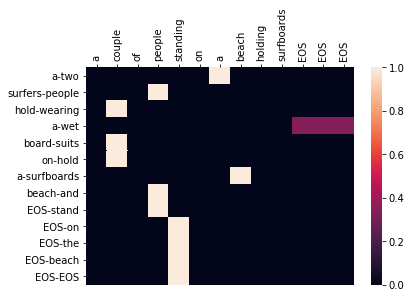

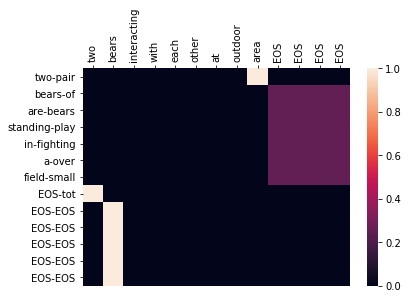

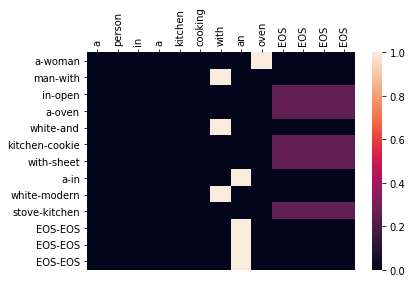

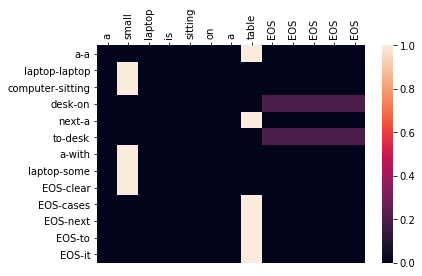



Example 1
INPUT >> a couple of men standing on a boat next to a small dog
PRED >> a dog laying on a boat next to a boat
TRUE >> two men fishing off of a blue boat with a dog
[BLEU] 0.09

Example 2
INPUT >> a couple of people standing on a beach holding surfboards
PRED >> a surfers hold a board on a beach
TRUE >> two people wearing wet suits hold surfboards and stand on the beach
[BLEU] 0.04

Example 3
INPUT >> two bears interacting with each other at outdoor area
PRED >> two bears are standing in a field
TRUE >> pair of bears play fighting over small tot
[BLEU] 0.06

Example 4
INPUT >> a person in a kitchen cooking with an oven
PRED >> a man in a white kitchen with a white stove
TRUE >> woman with open oven and cookie sheet in modern kitchen
[BLEU] 0.06

Example 5
INPUT >> a small laptop is sitting on a table
PRED >> a laptop computer desk next to a laptop
TRUE >> a laptop sitting on a desk with some clear cases next to it
[BLEU] 0.09

Step 50 average loss = 0.003834 (time: 20.46)
St

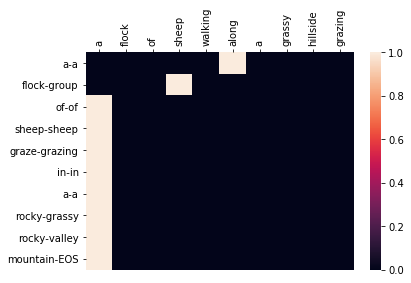

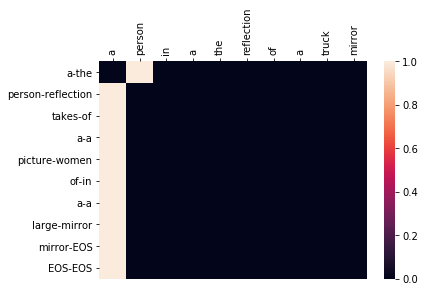

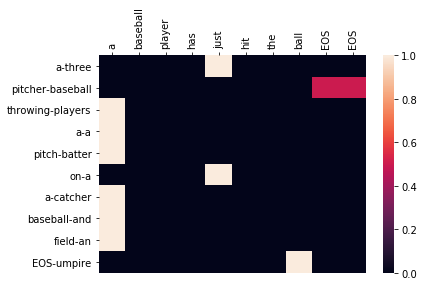

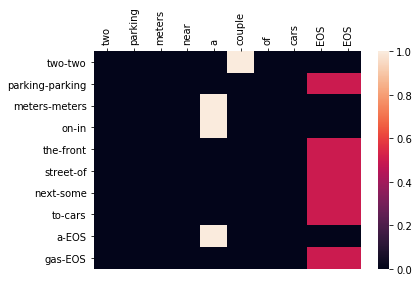

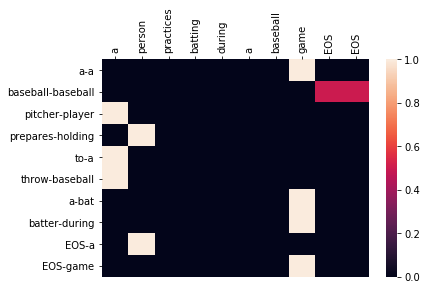



Example 1
INPUT >> a flock of sheep walking along a grassy hillside grazing
PRED >> a flock of sheep graze in a rocky rocky mountain
TRUE >> a group of sheep grazing in a grassy valley
[BLEU] 0.13

Example 2
INPUT >> a person in a the reflection of a truck mirror
PRED >> a person takes a picture of a large mirror
TRUE >> the reflection of a women in a mirror
[BLEU] 0.11

Example 3
INPUT >> a baseball player has just hit the ball
PRED >> a pitcher throwing a pitch on a baseball field
TRUE >> three baseball players a batter a catcher and an umpire
[BLEU] 0.06

Example 4
INPUT >> two parking meters near a couple of cars
PRED >> two parking meters on the street next to a gas
TRUE >> two parking meters in front of some cars
[BLEU] 0.16

Example 5
INPUT >> a person practices batting during a baseball game
PRED >> a baseball pitcher prepares to throw a batter
TRUE >> a baseball player holding a baseball bat during a game
[BLEU] 0.10

Step 50 average loss = 0.004478 (time: 20.49)
Step 100 av

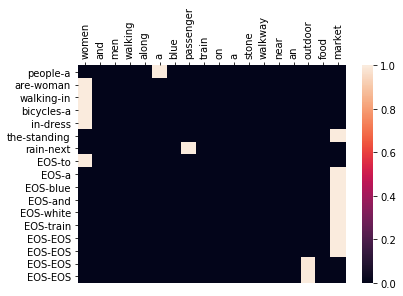

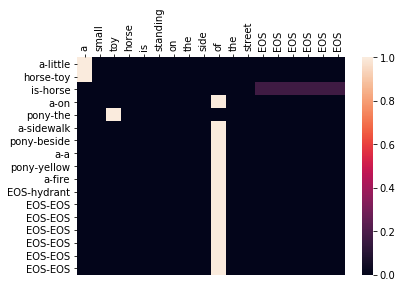

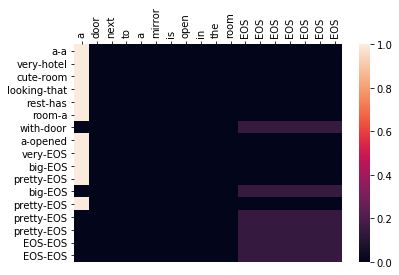

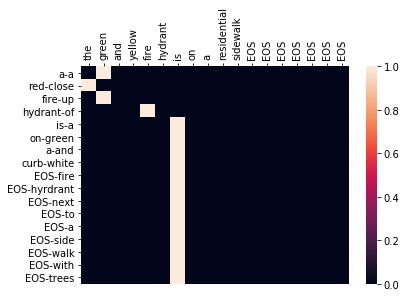

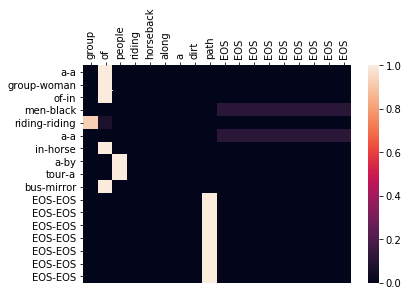



Example 1
INPUT >> women and men walking along a blue passenger train on a stone walkway near an outdoor food market
PRED >> people are walking bicycles in the rain
TRUE >> a woman in a dress standing next to a blue and white train
[BLEU] 0.03

Example 2
INPUT >> a small toy horse is standing on the side of the street
PRED >> a horse is a pony a pony a pony a
TRUE >> little toy horse on the sidewalk beside a yellow fire hydrant
[BLEU] 0.05

Example 3
INPUT >> a door next to a mirror is open in the room
PRED >> a very cute looking rest room with a very big pretty big pretty pretty pretty
TRUE >> a hotel room that has a door opened
[BLEU] 0.03

Example 4
INPUT >> the green and yellow fire hydrant is on a residential sidewalk
PRED >> a red fire hydrant is on a curb
TRUE >> a close up of a green and white fire hyrdrant next to a side walk with trees
[BLEU] 0.02

Example 5
INPUT >> group of people riding horseback along a dirt path
PRED >> a group of men riding a in a tour bus
TRUE >> a w

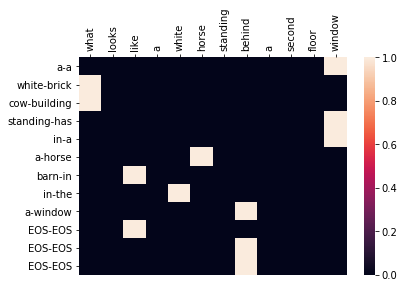

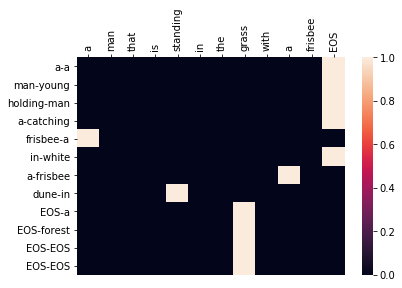

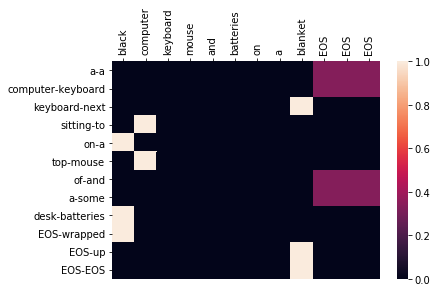

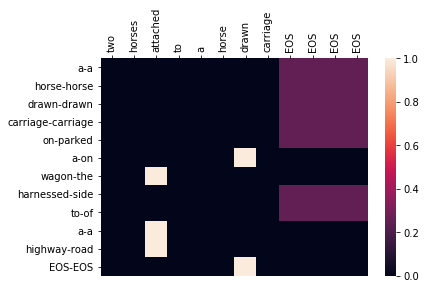

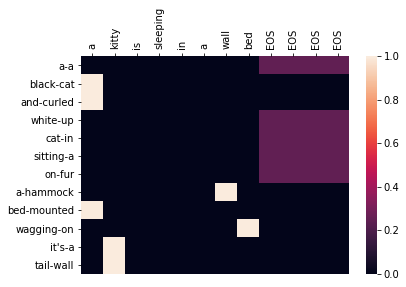



Example 1
INPUT >> what looks like a white horse standing behind a second floor window
PRED >> a white cow standing in a barn in a
TRUE >> a brick building has a horse in the window
[BLEU] 0.06

Example 2
INPUT >> a man that is standing in the grass with a frisbee
PRED >> a man holding a frisbee in a dune
TRUE >> a young man catching a white frisbee in a forest
[BLEU] 0.19

Example 3
INPUT >> black computer keyboard mouse and batteries on a blanket
PRED >> a computer keyboard sitting on top of a desk
TRUE >> a keyboard next to a mouse and some batteries wrapped up
[BLEU] 0.05

Example 4
INPUT >> two horses attached to a horse drawn carriage
PRED >> a horse drawn carriage on a wagon harnessed to a highway
TRUE >> a horse drawn carriage parked on the side of a road
[BLEU] 0.26

Example 5
INPUT >> a kitty is sleeping in a wall bed
PRED >> a black and white cat sitting on a bed wagging it's tail
TRUE >> a cat curled up in a fur hammock mounted on a wall
[BLEU] 0.08

Step 50 average loss 

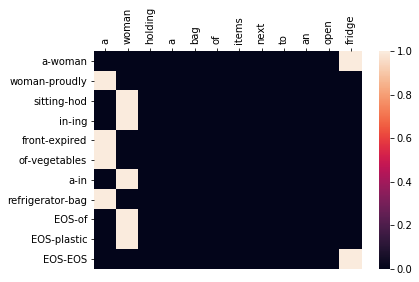

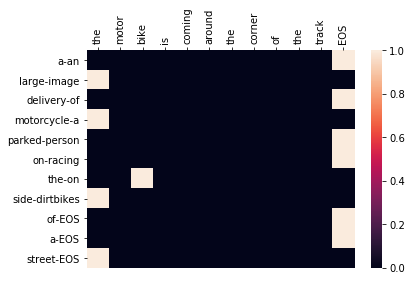

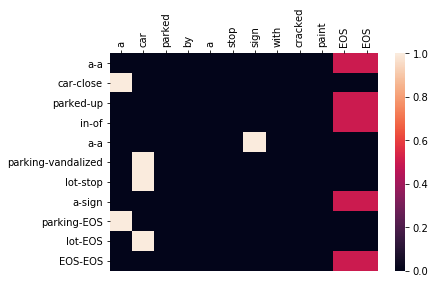

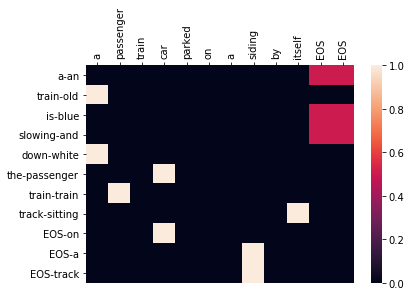

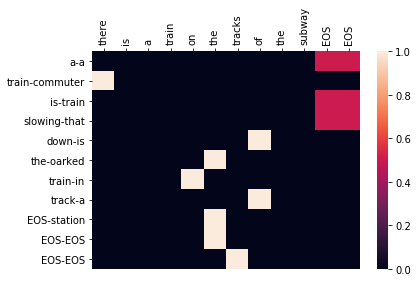



Example 1
INPUT >> a woman holding a bag of items next to an open fridge
PRED >> a woman sitting in front of a refrigerator
TRUE >> woman proudly hod ing expired vegetables in bag of plastic
[BLEU] 0.06

Example 2
INPUT >> the motor bike is coming around the corner of the track
PRED >> a large delivery motorcycle parked on the side of a street
TRUE >> an image of a person racing on dirtbikes
[BLEU] 0.08

Example 3
INPUT >> a car parked by a stop sign with cracked paint
PRED >> a car parked in a parking lot a parking lot
TRUE >> a close up of a vandalized stop sign
[BLEU] 0.05

Example 4
INPUT >> a passenger train car parked on a siding by itself
PRED >> a train is slowing down the train track
TRUE >> an old blue and white passenger train sitting on a track
[BLEU] 0.05

Example 5
INPUT >> there is a train on the tracks of the subway
PRED >> a train is slowing down the train track
TRUE >> a commuter train that is oarked in a station
[BLEU] 0.06

Step 50 average loss = 0.007586 (time: 2

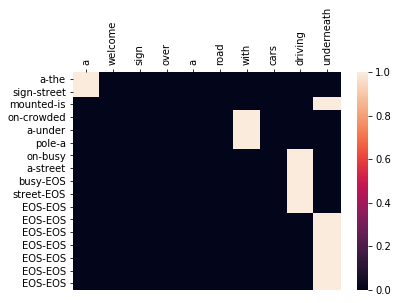

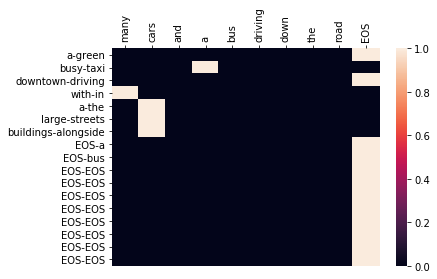

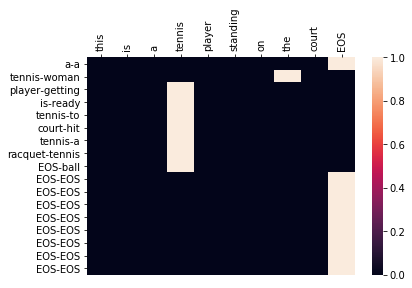

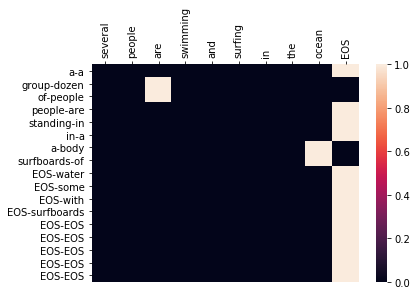

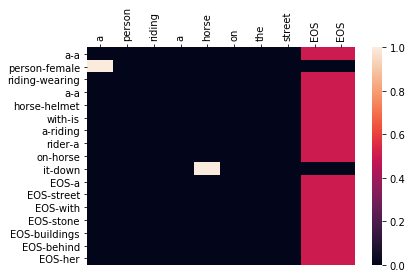



Example 1
INPUT >> a welcome sign over a road with cars driving underneath
PRED >> a sign mounted on a pole on a busy street
TRUE >> the street is crowded under a busy street
[BLEU] 0.16

Example 2
INPUT >> many cars and a bus driving down the road
PRED >> a busy downtown with a large buildings
TRUE >> green taxi driving in the streets alongside a bus
[BLEU] 0.05

Example 3
INPUT >> this is a tennis player standing on the court
PRED >> a tennis player is tennis court tennis racquet
TRUE >> a woman getting ready to hit a tennis ball
[BLEU] 0.10

Example 4
INPUT >> several people are swimming and surfing in the ocean
PRED >> a group of people standing in a surfboards
TRUE >> a dozen people are in a body of water some with surfboards
[BLEU] 0.09

Example 5
INPUT >> a person riding a horse on the street
PRED >> a person riding a horse with a rider on it
TRUE >> a female wearing a helmet is riding a horse down a street with stone buildings behind her
[BLEU] 0.09

Step 50 average loss = 0.

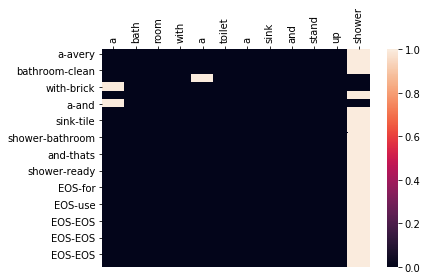

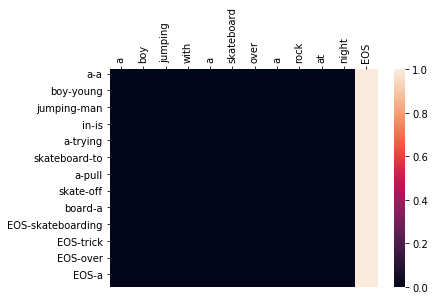

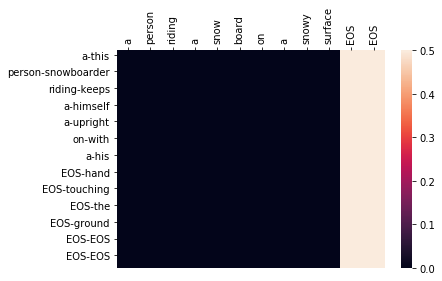

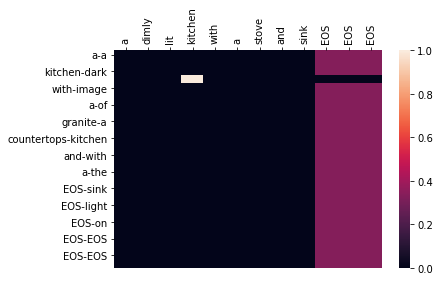

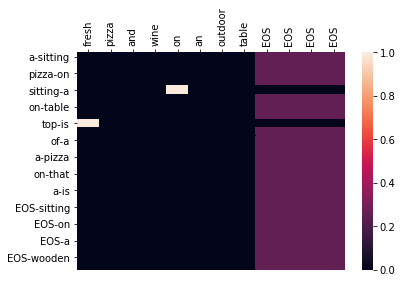



Example 1
INPUT >> a bath room with a toilet a sink and stand up shower
PRED >> a bathroom with a sink shower and shower
TRUE >> avery clean brick and tile bathroom thats ready for use
[BLEU] 0.05

Example 2
INPUT >> a boy jumping with a skateboard over a rock at night
PRED >> a boy jumping in a skateboard a skate board
TRUE >> a young man is trying to pull off a skateboarding trick over a large rock
[BLEU] 0.03

Example 3
INPUT >> a person riding a snow board on a snowy surface
PRED >> a person riding a a on a
TRUE >> this snowboarder keeps himself upright with his hand touching the ground
[BLEU] 0.00

Example 4
INPUT >> a dimly lit kitchen with a stove and sink
PRED >> a kitchen with a granite countertops and a
TRUE >> a dark image of a kitchen with the sink light on
[BLEU] 0.15

Example 5
INPUT >> fresh pizza and wine on an outdoor table
PRED >> a pizza sitting on top of a on a
TRUE >> sitting on a table is a pizza that is sitting on a wooden pot holder along with a bottle of wine

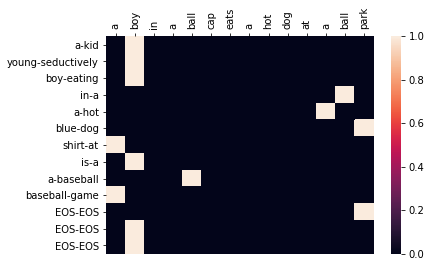

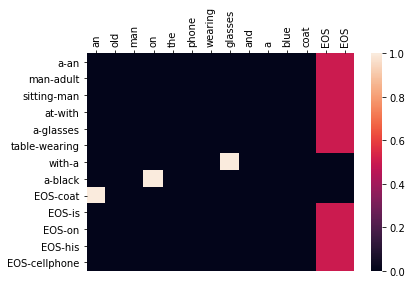

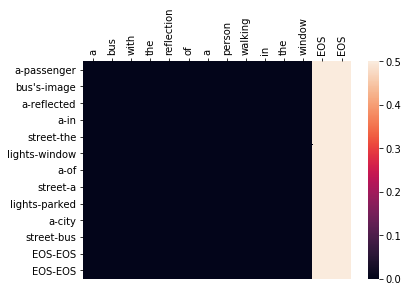

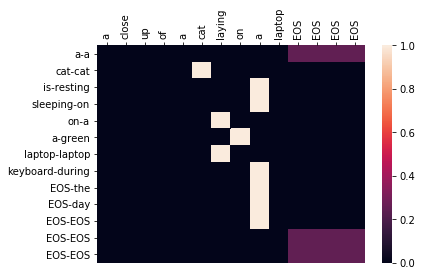

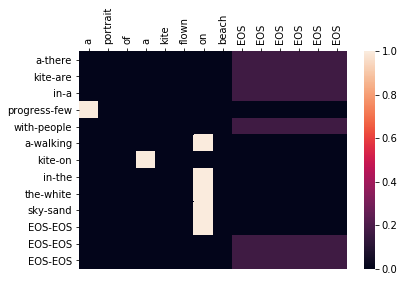



Example 1
INPUT >> a boy in a ball cap eats a hot dog at a ball park
PRED >> a young boy in a blue shirt is a baseball
TRUE >> kid seductively eating a hot dog at a baseball game
[BLEU] 0.09

Example 2
INPUT >> an old man on the phone wearing glasses and a blue coat
PRED >> a man sitting at a table with a
TRUE >> an adult man with glasses wearing a black coat is on his cellphone
[BLEU] 0.04

Example 3
INPUT >> a bus with the reflection of a person walking in the window
PRED >> a bus's a a street lights a street lights a street
TRUE >> passenger image reflected in the window of a parked city bus
[BLEU] 0.04

Example 4
INPUT >> a close up of a cat laying on a laptop
PRED >> a cat is sleeping on a laptop keyboard
TRUE >> a cat resting on a green laptop during the day
[BLEU] 0.13

Example 5
INPUT >> a portrait of a kite flown on beach
PRED >> a kite in progress with a kite in the sky
TRUE >> there are a few people walking on the white sand
[BLEU] 0.05

Step 50 average loss = 0.006541 (ti

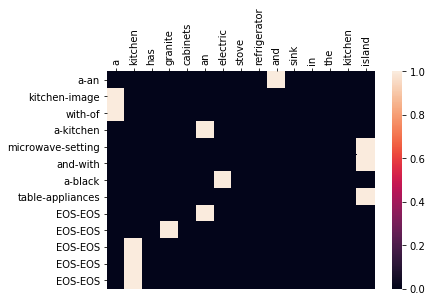

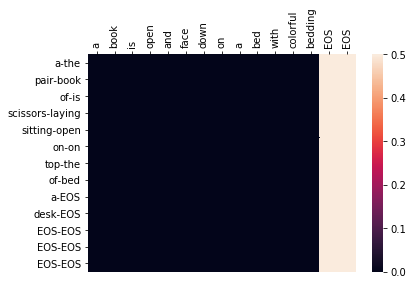

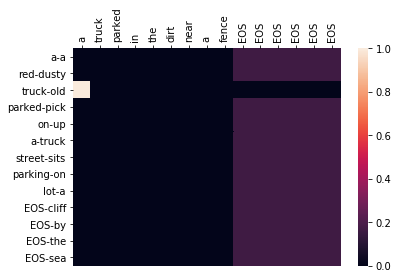

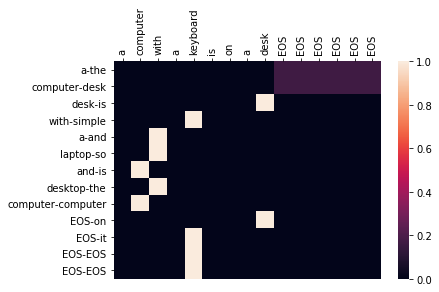

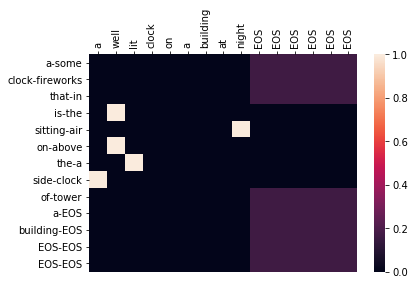



Example 1
INPUT >> a kitchen has granite cabinets an electric stove refrigerator and sink in the kitchen island
PRED >> a kitchen with a microwave and a table
TRUE >> an image of kitchen setting with black appliances
[BLEU] 0.07

Example 2
INPUT >> a book is open and face down on a bed with colorful bedding
PRED >> a pair of scissors sitting on top of a desk
TRUE >> the book is laying open on the bed
[BLEU] 0.04

Example 3
INPUT >> a truck parked in the dirt near a fence
PRED >> a red truck parked on a street parking lot
TRUE >> a dusty old pick up truck sits on a cliff by the sea
[BLEU] 0.07

Example 4
INPUT >> a computer with a keyboard is on a desk
PRED >> a computer desk with a laptop and desktop computer
TRUE >> the desk is simple and so is the computer on it
[BLEU] 0.05

Example 5
INPUT >> a well lit clock on a building at night
PRED >> a clock that is sitting on the side of a building
TRUE >> some fireworks in the air above a clock tower
[BLEU] 0.08

Step 50 average loss = 0.0

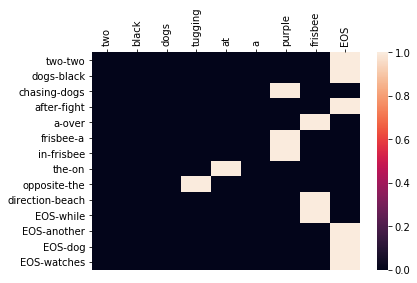

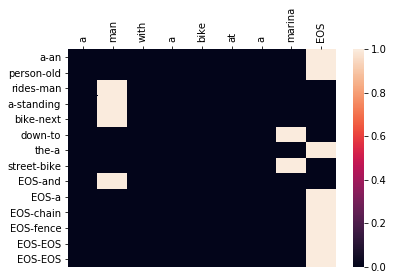

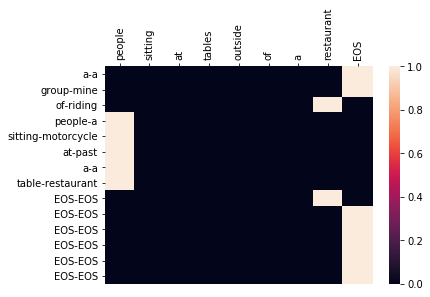

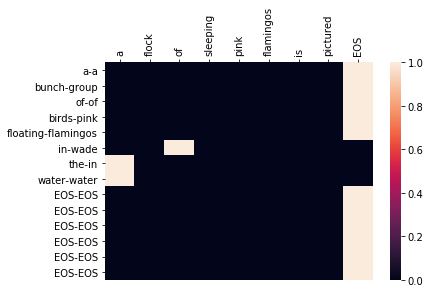



Example 1
INPUT >> a man wearing a hat and carrying a suitcase
PRED >> a man in a hat is a tie and
TRUE >> a large man is holding a black suitcase
[BLEU] 0.07

Example 2
INPUT >> two black dogs tugging at a purple frisbee
PRED >> two dogs chasing after a frisbee in the opposite direction
TRUE >> two black dogs fight over a frisbee on the beach while another dog watches
[BLEU] 0.07

Example 3
INPUT >> a man with a bike at a marina
PRED >> a person rides a bike down the street
TRUE >> an old man standing next to a bike and a chain fence
[BLEU] 0.07

Example 4
INPUT >> people sitting at tables outside of a restaurant
PRED >> a group of people sitting at a table
TRUE >> a mine riding a motorcycle past a restaurant
[BLEU] 0.07

Example 5
INPUT >> a flock of sleeping pink flamingos is pictured
PRED >> a bunch of birds floating in the water
TRUE >> a group of pink flamingos wade in water
[BLEU] 0.08

Step 50 average loss = 0.007030 (time: 21.53)
Step 100 average loss = 0.005989 (time: 9.60)

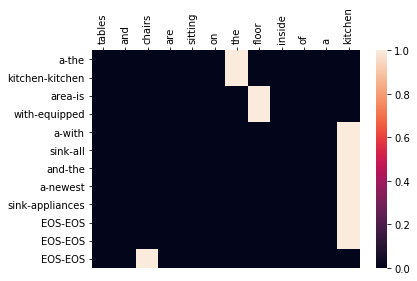

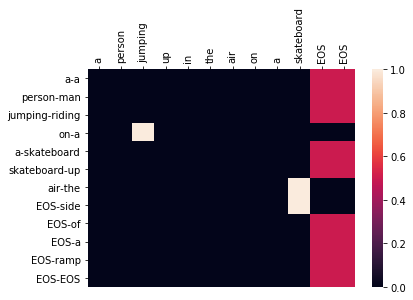

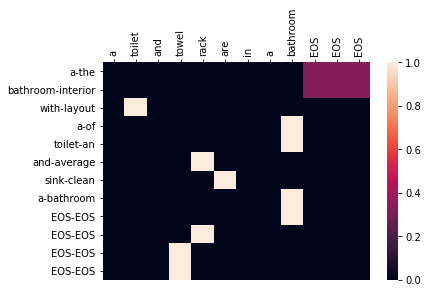

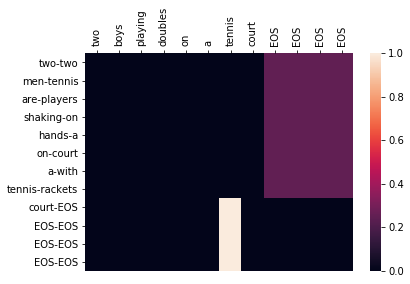

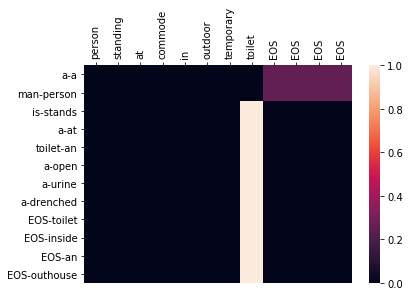



Example 1
INPUT >> tables and chairs are sitting on the floor inside of a kitchen
PRED >> a kitchen area with a sink and a sink
TRUE >> the kitchen is equipped with all the newest appliances
[BLEU] 0.06

Example 2
INPUT >> a person jumping up in the air on a skateboard
PRED >> a person jumping on a skateboard air
TRUE >> a man riding a skateboard up the side of a ramp
[BLEU] 0.08

Example 3
INPUT >> a toilet and towel rack are in a bathroom
PRED >> a bathroom with a toilet and sink a
TRUE >> the interior layout of an average clean bathroom
[BLEU] 0.06

Example 4
INPUT >> two boys playing doubles on a tennis court
PRED >> two men are shaking hands on a tennis court
TRUE >> two tennis players on a court with rackets
[BLEU] 0.12

Example 5
INPUT >> person standing at commode in outdoor temporary toilet
PRED >> a man is a toilet a a a
TRUE >> a person stands at an open urine drenched toilet inside an outhouse
[BLEU] 0.04

Step 50 average loss = 0.012567 (time: 20.35)
Step 100 average los

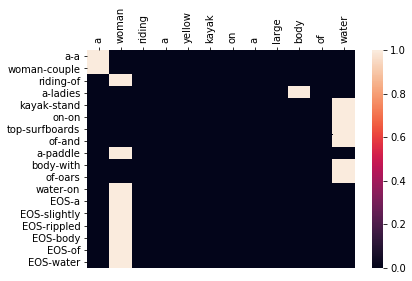

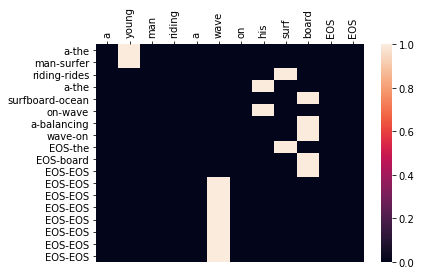

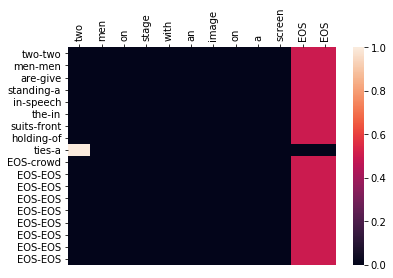

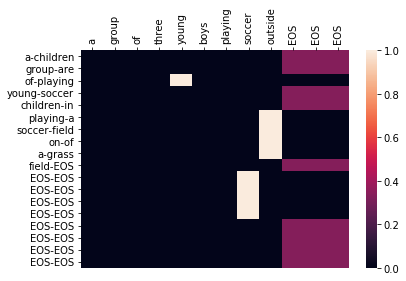

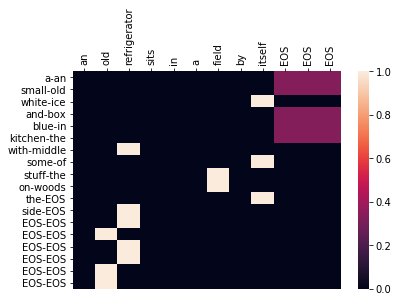



Example 1
INPUT >> a woman riding a yellow kayak on a large body of water
PRED >> a woman riding a kayak on top of a body of water
TRUE >> a couple of ladies stand on surfboards and paddle with oars on a slightly rippled body of water
[BLEU] 0.09

Example 2
INPUT >> a young man riding a wave on his surf board
PRED >> a man riding a surfboard on a wave
TRUE >> the surfer rides the ocean wave balancing on the board
[BLEU] 0.05

Example 3
INPUT >> two men on stage with an image on a screen
PRED >> two men are standing in the suits holding ties
TRUE >> two men give a speech in front of a crowd
[BLEU] 0.09

Example 4
INPUT >> a group of three young boys playing soccer outside
PRED >> a group of young children playing soccer on a field
TRUE >> children are playing soccer in a field of grass
[BLEU] 0.13

Example 5
INPUT >> an old refrigerator sits in a field by itself
PRED >> a small white and blue kitchen with some stuff on the side
TRUE >> an old ice box in the middle of the woods
[BLEU] 

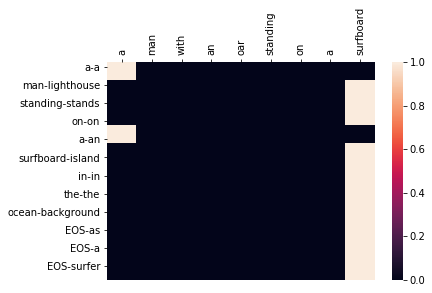

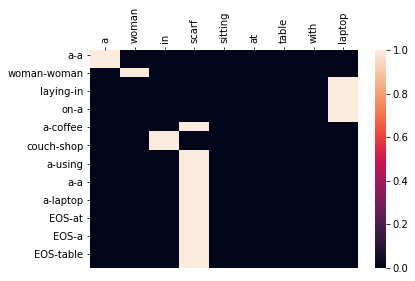

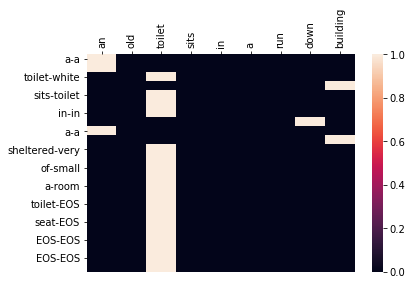

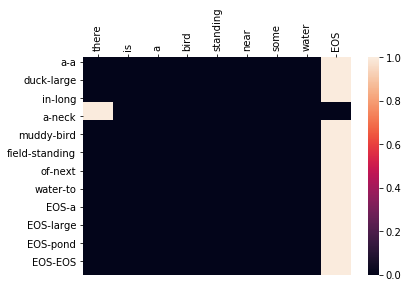

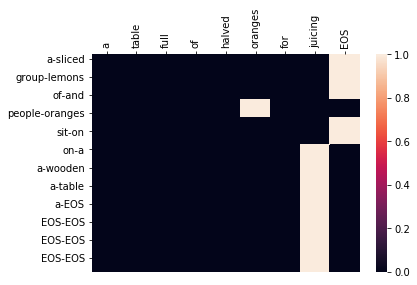



Example 1
INPUT >> a man with an oar standing on a surfboard
PRED >> a man standing on a surfboard in the ocean
TRUE >> a lighthouse stands on an island in the background as a surfer on an orange board rides the surf while holding a black pole
[BLEU] 0.02

Example 2
INPUT >> a woman in scarf sitting at table with laptop
PRED >> a woman laying on a couch a a a
TRUE >> a woman in a coffee shop using a laptop at a table
[BLEU] 0.09

Example 3
INPUT >> an old toilet sits in a run down building
PRED >> a toilet sits in a sheltered of a toilet seat
TRUE >> a white toilet in a very small room
[BLEU] 0.10

Example 4
INPUT >> there is a bird standing near some water
PRED >> a duck in a muddy field of water
TRUE >> a large long neck bird standing next to a large pond
[BLEU] 0.05

Example 5
INPUT >> a table full of halved oranges for juicing
PRED >> a group of people sit on a a a
TRUE >> sliced lemons and oranges on a wooden table
[BLEU] 0.10

Step 50 average loss = 0.006592 (time: 20.85)
Step 

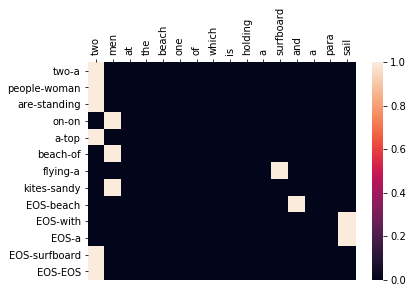

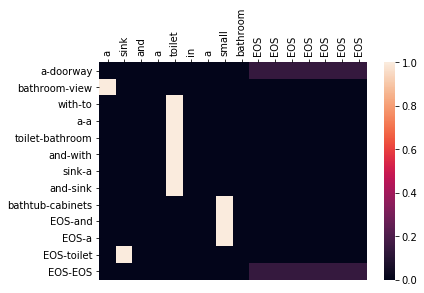

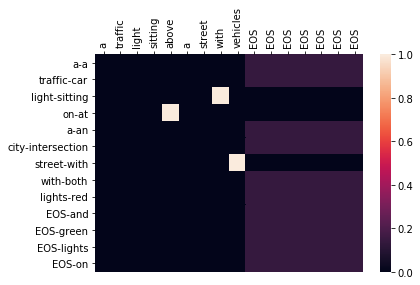

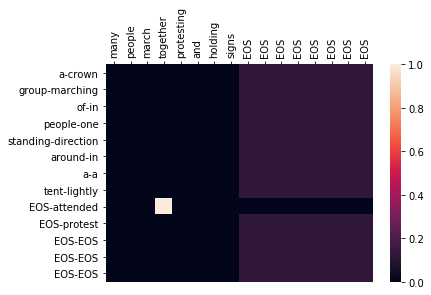

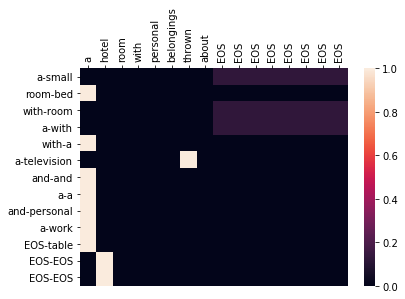



Example 1
INPUT >> two men at the beach one of which is holding a surfboard and a para sail
PRED >> two people are on a beach flying kites
TRUE >> a woman standing on top of a sandy beach with a surfboard
[BLEU] 0.04

Example 2
INPUT >> a sink and a toilet in a small bathroom
PRED >> a bathroom with a toilet and sink and bathtub
TRUE >> doorway view to a bathroom with a sink cabinets and a toilet
[BLEU] 0.26

Example 3
INPUT >> a traffic light sitting above a street with vehicles
PRED >> a traffic light on a city street with lights
TRUE >> a car sitting at an intersection with both red and green lights on
[BLEU] 0.04

Example 4
INPUT >> many people march together protesting and holding signs
PRED >> a group of people standing around a tent
TRUE >> crown marching in one direction in a lightly attended protest
[BLEU] 0.04

Example 5
INPUT >> a hotel room with personal belongings thrown about
PRED >> a room with a with a and a and a
TRUE >> small bed room with a television and a persona

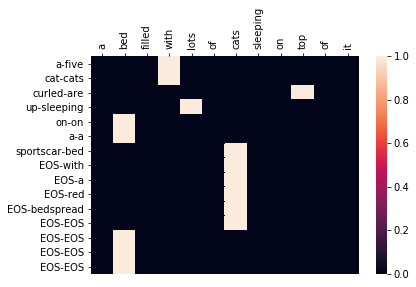

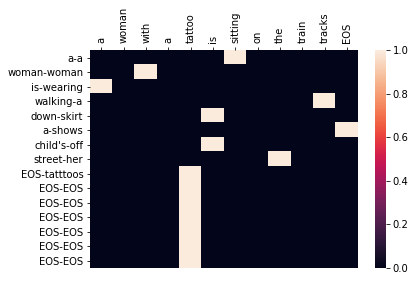

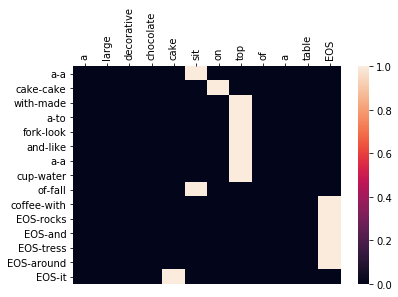

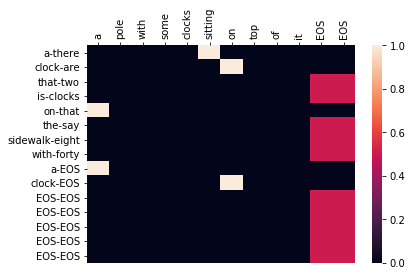

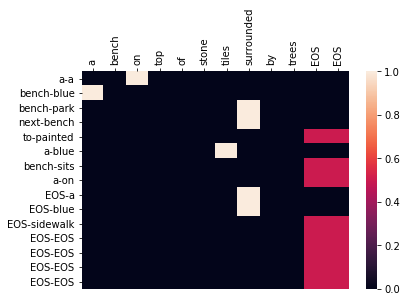



Example 1
INPUT >> a bed filled with lots of cats sleeping on top of it
PRED >> a cat curled up on a sportscar
TRUE >> five cats are sleeping on a bed with a red bedspread
[BLEU] 0.08

Example 2
INPUT >> a woman with a tattoo is sitting on the train tracks
PRED >> a woman is walking down a child's street
TRUE >> a woman wearing a skirt shows off her tatttoos
[BLEU] 0.11

Example 3
INPUT >> a large decorative chocolate cake sit on top of a table
PRED >> a cake with a fork and a cup of coffee
TRUE >> a cake made to look like a water fall with rocks and tress around it
[BLEU] 0.06

Example 4
INPUT >> a pole with some clocks sitting on top of it
PRED >> a clock that is on the sidewalk with a clock
TRUE >> there are two clocks that say eight forty
[BLEU] 0.04

Example 5
INPUT >> a bench on top of stone tiles surrounded by trees
PRED >> a bench bench next to a bench a
TRUE >> a blue park bench painted blue sits on a blue sidewalk
[BLEU] 0.05

Step 50 average loss = 0.003237 (time: 20.16)
S

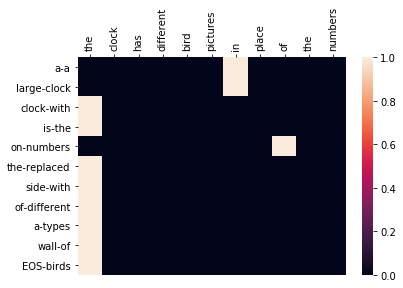

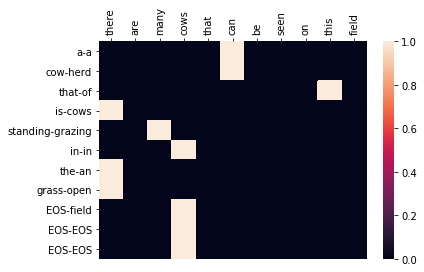

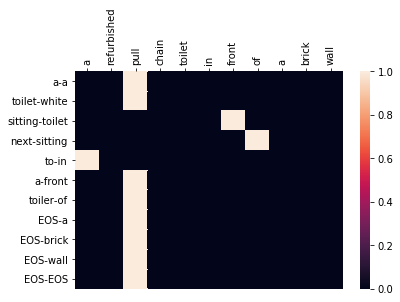

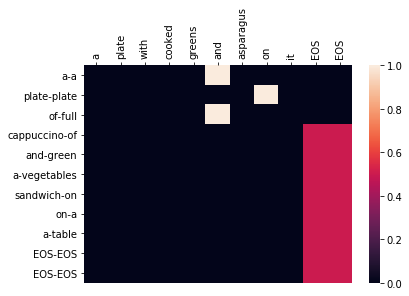

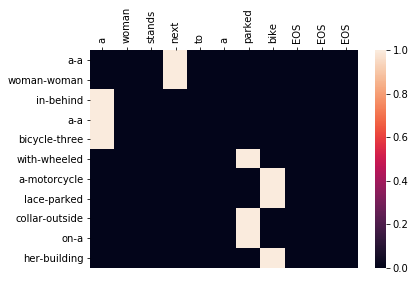



Example 1
INPUT >> the clock has different bird pictures in place of the numbers
PRED >> a large clock is on the side of a wall
TRUE >> a clock with the numbers replaced with different types of birds
[BLEU] 0.05

Example 2
INPUT >> there are many cows that can be seen on this field
PRED >> a cow that is standing in the grass
TRUE >> a herd of cows grazing in an open field
[BLEU] 0.06

Example 3
INPUT >> a refurbished pull chain toilet in front of a brick wall
PRED >> a toilet sitting next to a toiler
TRUE >> a white toilet sitting in front of a brick wall
[BLEU] 0.10

Example 4
INPUT >> a plate with cooked greens and asparagus on it
PRED >> a plate of cappuccino and a sandwich on a
TRUE >> a plate full of green vegetables on a table
[BLEU] 0.14

Example 5
INPUT >> a woman stands next to a parked bike
PRED >> a woman in a bicycle with a lace collar on her
TRUE >> a woman behind a three wheeled motorcycle parked outside a building
[BLEU] 0.09

Step 50 average loss = 0.006081 (time: 20.

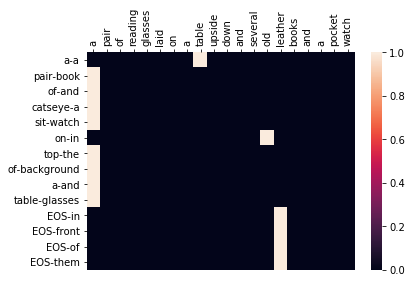

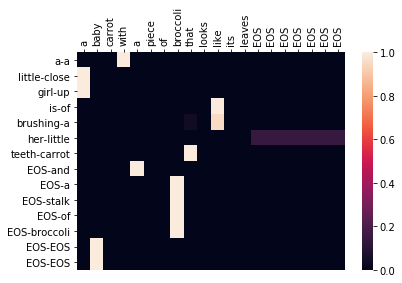

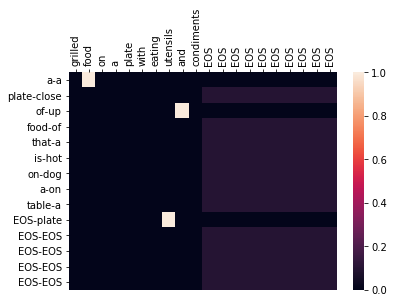

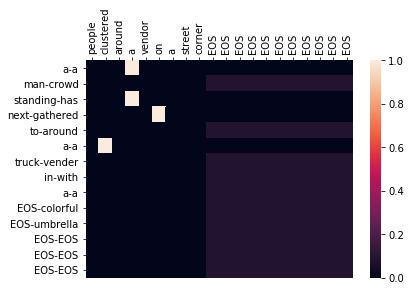

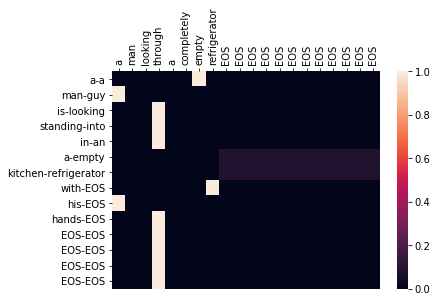



Example 1
INPUT >> a pair of reading glasses laid on a table upside down and several old leather books and a pocket watch
PRED >> a pair of catseye sit on top of a table
TRUE >> a book and a watch in the background and glasses in front of them
[BLEU] 0.04

Example 2
INPUT >> a baby carrot with a piece of broccoli that looks like its leaves
PRED >> a little girl is brushing her teeth
TRUE >> a close up of a little carrot and a stalk of broccoli
[BLEU] 0.06

Example 3
INPUT >> grilled food on a plate with eating utensils and condiments
PRED >> a plate of food that is on a table
TRUE >> a close up of a hot dog on a plate
[BLEU] 0.13

Example 4
INPUT >> people clustered around a vendor on a street corner
PRED >> a man standing next to a truck in a
TRUE >> a crowd has gathered around a vender with a colorful umbrella
[BLEU] 0.05

Example 5
INPUT >> a man looking through a completely empty refrigerator
PRED >> a man is standing in a kitchen with his hands
TRUE >> a guy looking into an empt

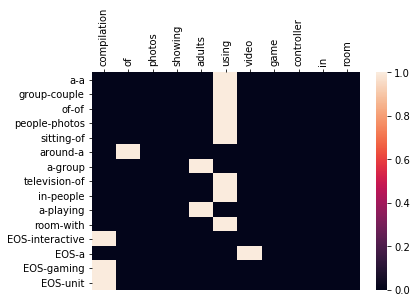

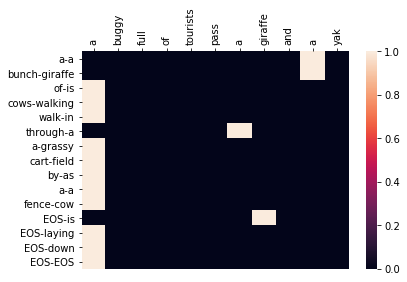

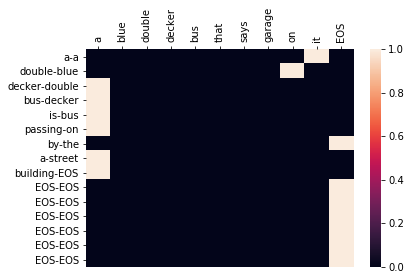

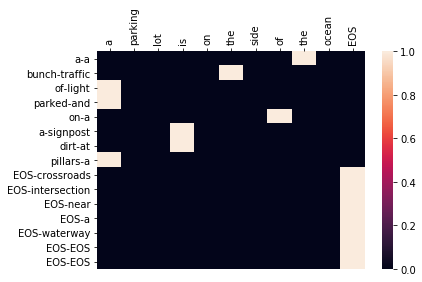

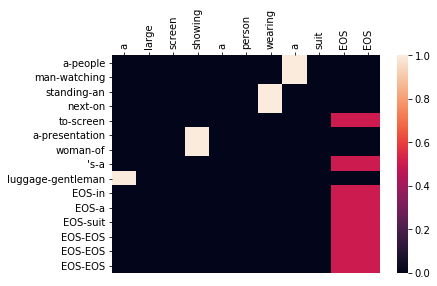



Example 1
INPUT >> compilation of photos showing adults using video game controller in room
PRED >> a group of people sitting around a television in a room
TRUE >> a couple of photos of a group of people playing with interactive a gaming unit
[BLEU] 0.18

Example 2
INPUT >> a buggy full of tourists pass a giraffe and a yak
PRED >> a bunch of cows walk through a cart by a fence
TRUE >> a giraffe is walking in a grassy field as a cow is laying down
[BLEU] 0.04

Example 3
INPUT >> a blue double decker bus that says garage on it
PRED >> a double decker bus is passing by a building
TRUE >> a blue double decker bus on the street
[BLEU] 0.19

Example 4
INPUT >> a parking lot is on the side of the ocean
PRED >> a bunch of parked on a dirt pillars
TRUE >> a traffic light and a signpost at a crossroads intersection near a waterway
[BLEU] 0.04

Example 5
INPUT >> a large screen showing a person wearing a suit
PRED >> a man standing next to a woman 's luggage
TRUE >> people watching an on screen

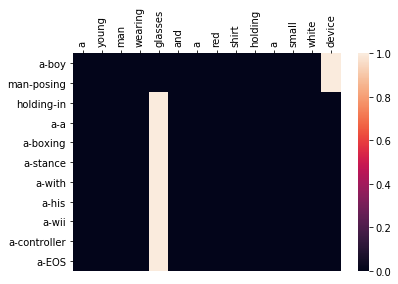

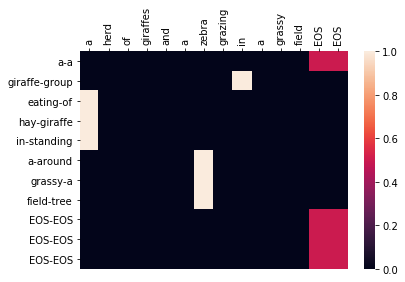

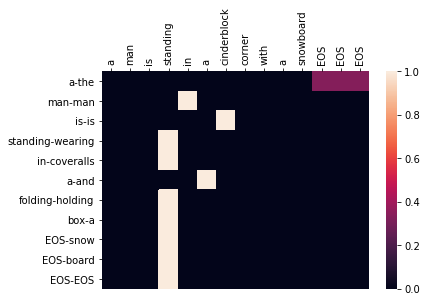

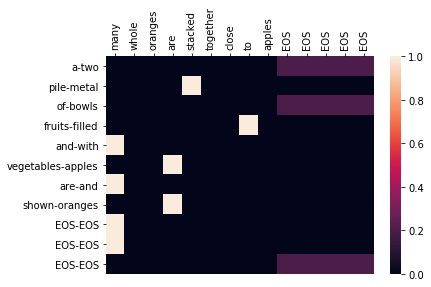

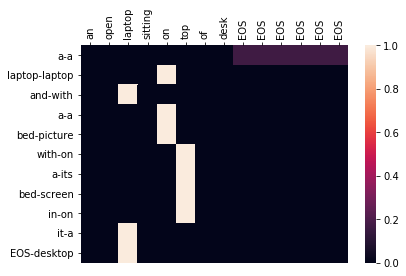



Example 1
INPUT >> a young man wearing glasses and a red shirt holding a small white device
PRED >> a man holding a a a a a a a a
TRUE >> boy posing in a boxing stance with his wii controller
[BLEU] 0.04

Example 2
INPUT >> a herd of giraffes and a zebra grazing in a grassy field
PRED >> a giraffe eating hay in a grassy field
TRUE >> a group of giraffe standing around a tree
[BLEU] 0.07

Example 3
INPUT >> a man is standing in a cinderblock corner with a snowboard
PRED >> a man is standing in a folding box
TRUE >> the man is wearing coveralls and holding a snow board
[BLEU] 0.10

Example 4
INPUT >> many whole oranges are stacked together close to apples
PRED >> a pile of fruits and vegetables are shown
TRUE >> two metal bowls filled with apples and oranges
[BLEU] 0.06

Example 5
INPUT >> an open laptop sitting on top of desk
PRED >> a laptop and a bed with a bed in it
TRUE >> a laptop with a picture on its screen on a desktop
[BLEU] 0.11

Step 50 average loss = 0.008549 (time: 20.92)

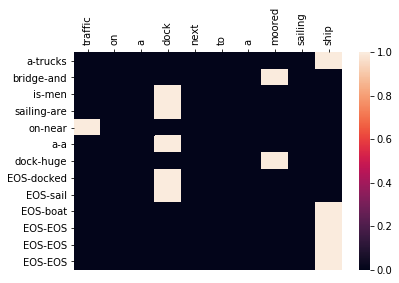

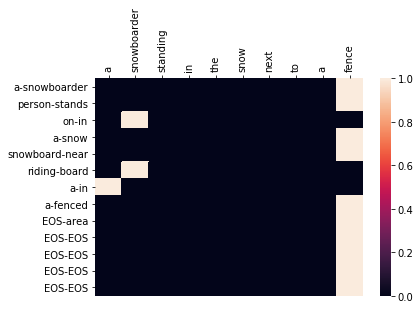

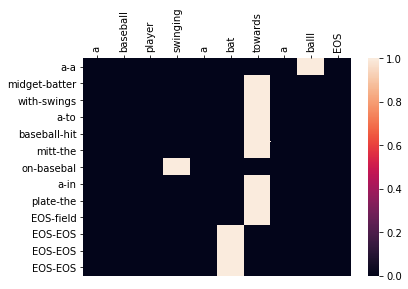

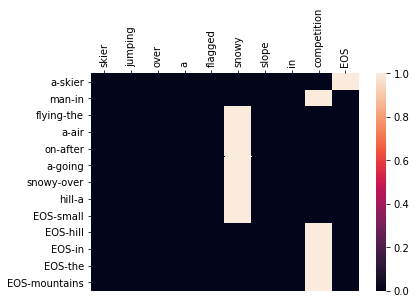

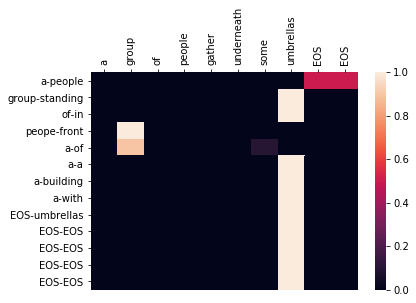



Example 1
INPUT >> traffic on a dock next to a moored sailing ship
PRED >> a bridge is sailing on a dock
TRUE >> trucks and men are near a huge docked sail boat
[BLEU] 0.04

Example 2
INPUT >> a snowboarder standing in the snow next to a fence
PRED >> a person on a snowboard riding a a
TRUE >> snowboarder stands in snow near board in fenced area
[BLEU] 0.00

Example 3
INPUT >> a baseball player swinging a bat towards a balll
PRED >> a midget with a baseball mitt on a plate
TRUE >> a batter swings to hit the basebal in the field
[BLEU] 0.04

Example 4
INPUT >> skier jumping over a flagged snowy slope in competition
PRED >> a man flying a on a snowy hill
TRUE >> skier in the air after going over a small hill in the mountains
[BLEU] 0.04

Example 5
INPUT >> a group of people gather underneath some umbrellas
PRED >> a group of peope a a a a
TRUE >> people standing in front of a building with umbrellas
[BLEU] 0.06

Step 50 average loss = 0.006485 (time: 20.72)
Step 100 average loss = 0.00

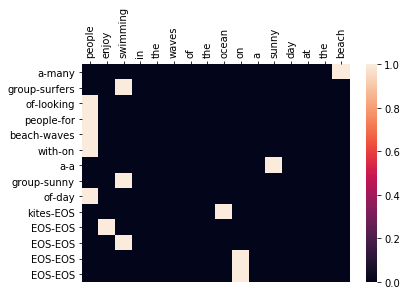

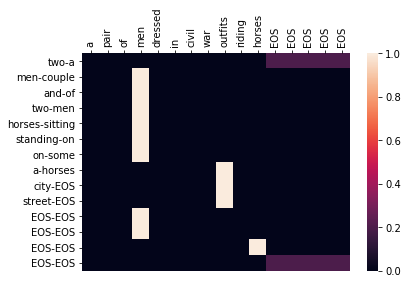

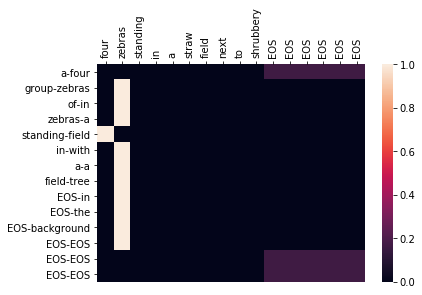

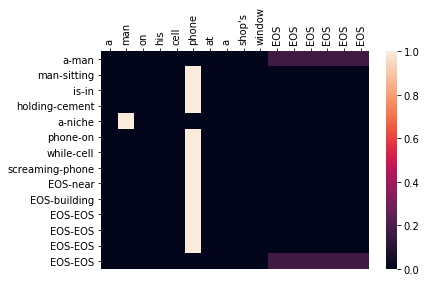

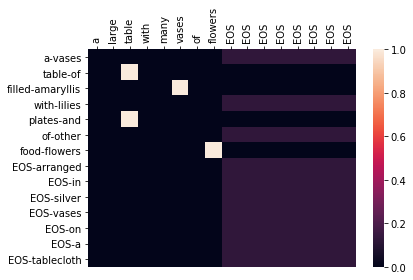



Example 1
INPUT >> people enjoy swimming in the waves of the ocean on a sunny day at the beach
PRED >> a group of people beach with a group of kites
TRUE >> many surfers looking for waves on a sunny day
[BLEU] 0.04

Example 2
INPUT >> a pair of men dressed in civil war outfits riding horses
PRED >> two men and two horses standing on a city street
TRUE >> a couple of men sitting on some horses
[BLEU] 0.06

Example 3
INPUT >> four zebras standing in a straw field next to shrubbery
PRED >> a group of zebras standing in a field
TRUE >> four zebras in a field with a tree in the background
[BLEU] 0.16

Example 4
INPUT >> a man on his cell phone at a shop's window
PRED >> a man is holding a phone while screaming
TRUE >> man sitting in cement niche on cell phone near building
[BLEU] 0.05

Example 5
INPUT >> a large table with many vases of flowers
PRED >> a table filled with plates of food
TRUE >> vases of amaryllis lilies and other flowers arranged in silver vases on a tablecloth
[BLEU] 0.0

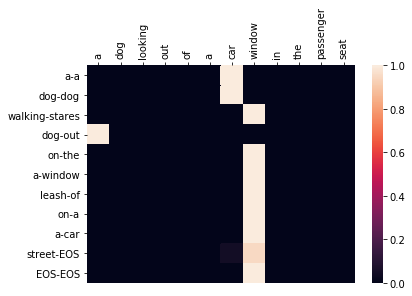

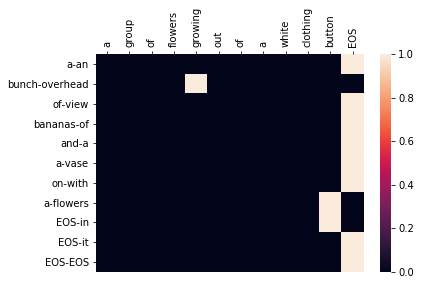

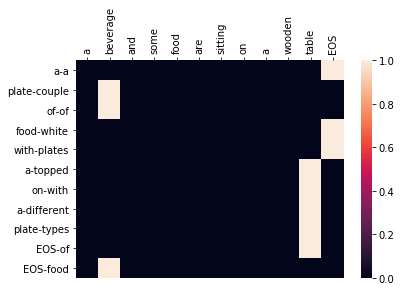

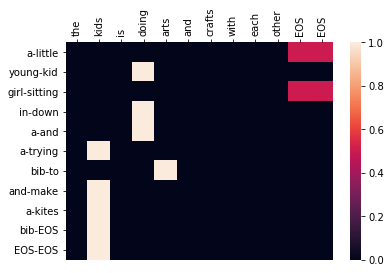

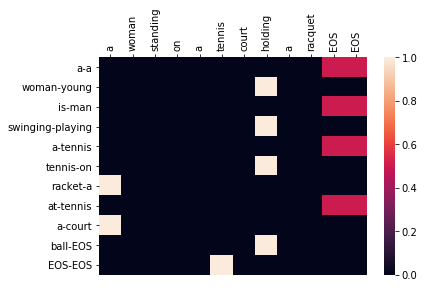



Example 1
INPUT >> a dog looking out of a car window in the passenger seat
PRED >> a dog walking dog on a leash on a street
TRUE >> a dog stares out the window of a car
[BLEU] 0.09

Example 2
INPUT >> a group of flowers growing out of a white clothing button
PRED >> a bunch of bananas and a on a
TRUE >> an overhead view of a vase with flowers in it
[BLEU] 0.05

Example 3
INPUT >> a beverage and some food are sitting on a wooden table
PRED >> a plate of food with a on a plate
TRUE >> a couple of white plates topped with different types of food
[BLEU] 0.09

Example 4
INPUT >> the kids is doing arts and crafts with each other
PRED >> a young girl in a a bib and a bib
TRUE >> little kid sitting down and trying to make kites
[BLEU] 0.04

Example 5
INPUT >> a woman standing on a tennis court holding a racquet
PRED >> a woman is swinging a tennis racket at a ball
TRUE >> a young man playing tennis on a tennis court
[BLEU] 0.09

Step 50 average loss = 0.005064 (time: 19.95)
Step 100 average 

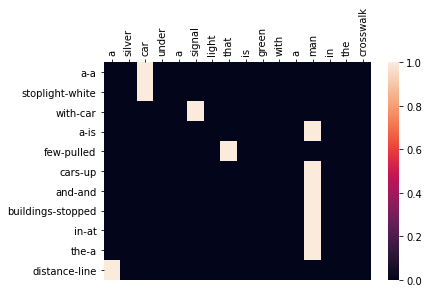

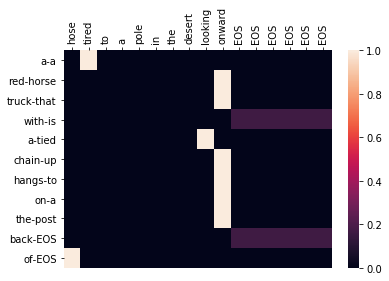

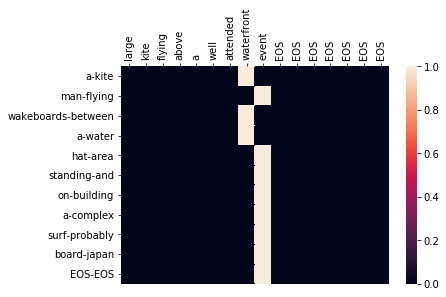

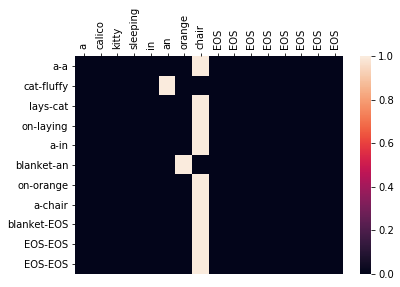

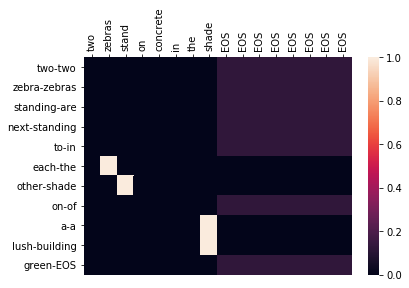



Example 1
INPUT >> a silver car under a signal light that is green with a man in the crosswalk
PRED >> a stoplight with a few cars and buildings in the distance
TRUE >> a white car is pulled up and stopped at a line
[BLEU] 0.05

Example 2
INPUT >> hose tired to a pole in the desert looking onward
PRED >> a red truck with a chain hangs on the back of
TRUE >> a horse that is tied up to a post
[BLEU] 0.04

Example 3
INPUT >> large kite flying above a well attended waterfront event
PRED >> a man wakeboards a hat standing on a surf board
TRUE >> kite flying between water area and building complex probably japan
[BLEU] 0.00

Example 4
INPUT >> a calico kitty sleeping in an orange chair
PRED >> a cat lays on a blanket on a blanket
TRUE >> a fluffy cat laying in an orange chair
[BLEU] 0.06

Example 5
INPUT >> two zebras stand on concrete in the shade
PRED >> two zebra standing next to each other on a lush green
TRUE >> two zebras are standing in the shade of a building
[BLEU] 0.05

Step 50 a

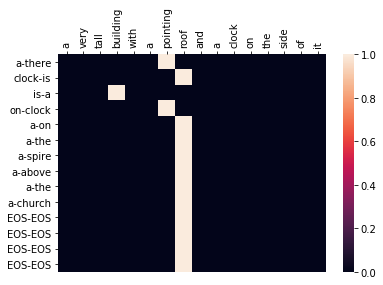

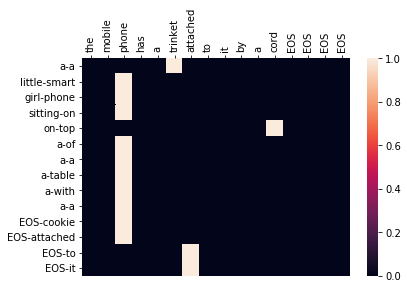

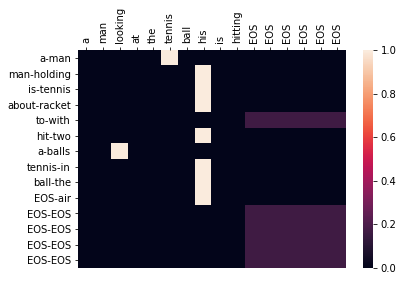

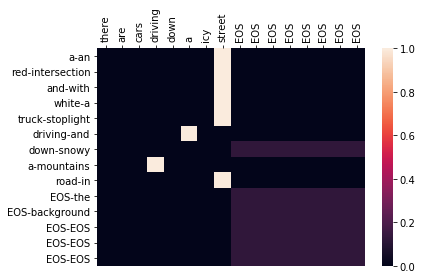

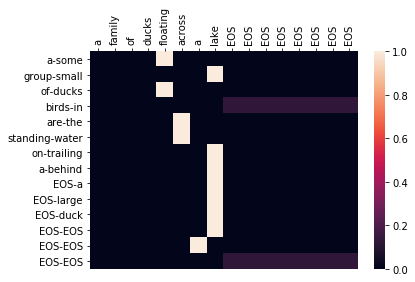



Example 1
INPUT >> a very tall building with a pointing roof and a clock on the side of it
PRED >> a clock is on a a a a a a
TRUE >> there is a clock on the spire above the church
[BLEU] 0.10

Example 2
INPUT >> the mobile phone has a trinket attached to it by a cord
PRED >> a little girl sitting on a a a a a
TRUE >> a smart phone on top of a table with a cookie attached to it
[BLEU] 0.04

Example 3
INPUT >> a man looking at the tennis ball his is hitting
PRED >> a man is about to hit a tennis ball
TRUE >> man holding tennis racket with two balls in the air
[BLEU] 0.05

Example 4
INPUT >> there are cars driving down a icy street
PRED >> a red and white truck driving down a road
TRUE >> an intersection with a stoplight and snowy mountains in the background
[BLEU] 0.05

Example 5
INPUT >> a family of ducks floating across a lake
PRED >> a group of birds are standing on a
TRUE >> some small ducks in the water trailing behind a large duck
[BLEU] 0.04

Step 50 average loss = 0.013364 (tim

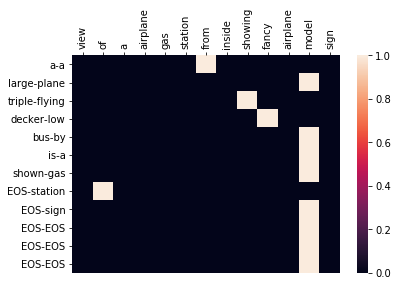

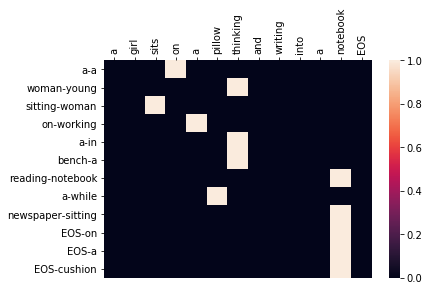

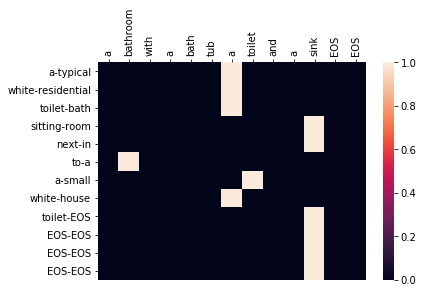

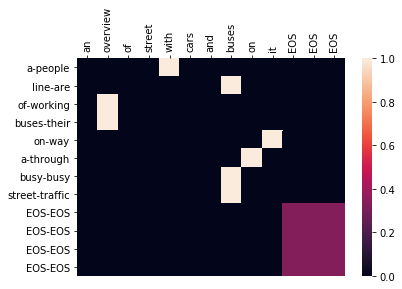

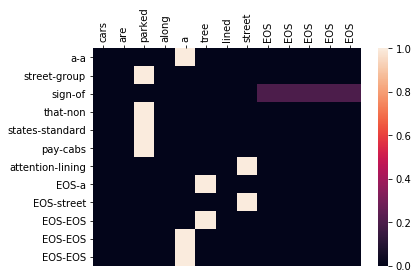



Example 1
INPUT >> view of a airplane gas station from inside showing fancy airplane model sign
PRED >> a large triple decker bus is shown
TRUE >> a plane flying low by a gas station sign
[BLEU] 0.05

Example 2
INPUT >> a girl sits on a pillow thinking and writing into a notebook
PRED >> a woman sitting on a bench reading a newspaper
TRUE >> a young woman working in a notebook while sitting on a cushion
[BLEU] 0.15

Example 3
INPUT >> a bathroom with a bath tub a toilet and a sink
PRED >> a white toilet sitting next to a white toilet
TRUE >> typical residential bath room in a small house
[BLEU] 0.05

Example 4
INPUT >> an overview of street with cars and buses on it
PRED >> a line of buses on a busy street
TRUE >> people are working their way through busy traffic
[BLEU] 0.06

Example 5
INPUT >> cars are parked along a tree lined street
PRED >> a street sign that states pay attention
TRUE >> a group of non standard cabs lining a street
[BLEU] 0.10

Step 50 average loss = 0.009492 (tim

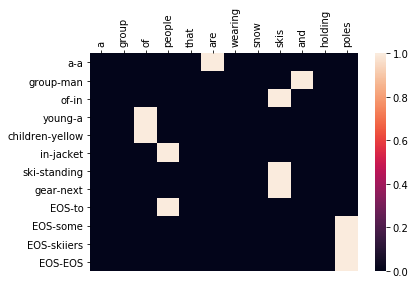

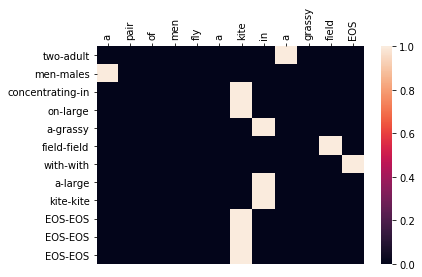

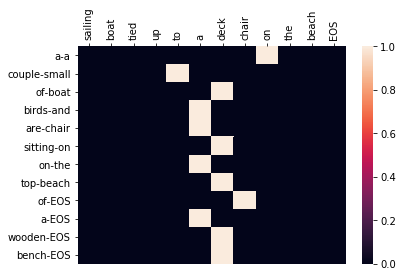

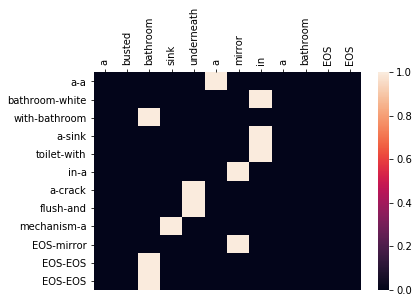

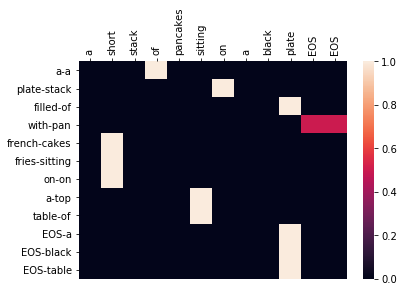



Example 1
INPUT >> a group of people that are wearing snow skis and holding poles
PRED >> a group of young children in ski gear
TRUE >> a man in a yellow jacket standing next to some skiiers
[BLEU] 0.05

Example 2
INPUT >> a pair of men fly a kite in a grassy field
PRED >> two men concentrating on a field with a kite
TRUE >> adult males in large grassy field with large kite
[BLEU] 0.11

Example 3
INPUT >> sailing boat tied up to a deck chair on the beach
PRED >> a couple of birds are sitting on top of a wooden bench
TRUE >> a small boat and chair on the beach
[BLEU] 0.04

Example 4
INPUT >> a busted bathroom sink underneath a mirror in a bathroom
PRED >> a bathroom with a toilet in a flush mechanism
TRUE >> a white bathroom sink with a crack and a mirror
[BLEU] 0.11

Example 5
INPUT >> a short stack of pancakes sitting on a black plate
PRED >> a plate filled with french fries on a table
TRUE >> a stack of pan cakes sitting on top of a black table
[BLEU] 0.05

Step 50 average loss = 0

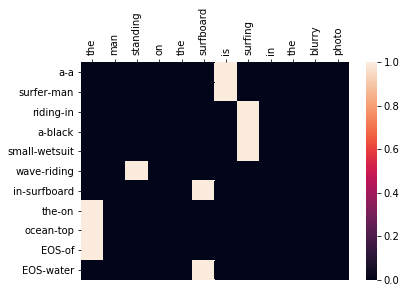

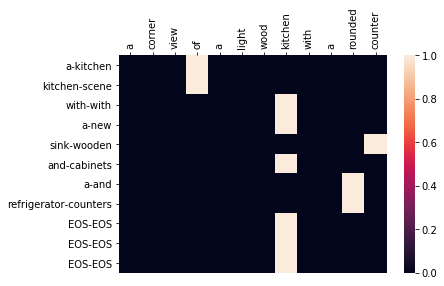

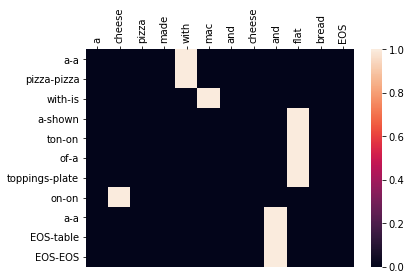

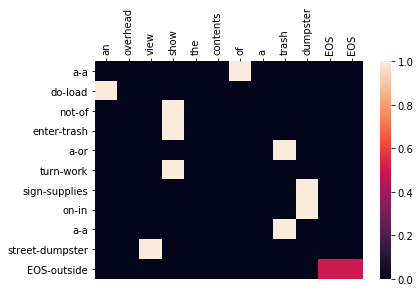

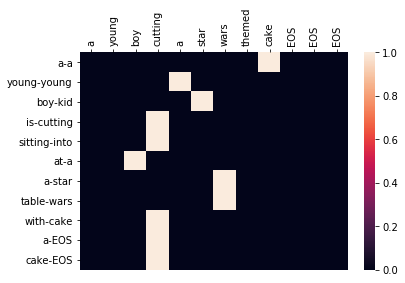



Example 1
INPUT >> the man standing on the surfboard is surfing in the blurry photo
PRED >> a surfer riding a small wave in the ocean
TRUE >> a man in black wetsuit riding surfboard on top of water
[BLEU] 0.05

Example 2
INPUT >> a corner view of a light wood kitchen with a rounded counter
PRED >> a kitchen with a sink and a refrigerator
TRUE >> kitchen scene with new wooden cabinets and counters
[BLEU] 0.07

Example 3
INPUT >> a cheese pizza made with mac and cheese and flat bread
PRED >> a pizza with a ton of toppings on a
TRUE >> a pizza is shown on a plate on a table
[BLEU] 0.13

Example 4
INPUT >> an overhead view show the contents of a trash dumpster
PRED >> a do not enter a turn sign on a street
TRUE >> a load of trash or work supplies in a dumpster outside
[BLEU] 0.05

Example 5
INPUT >> a young boy cutting a star wars themed cake
PRED >> a young boy is sitting at a table with a cake
TRUE >> a young kid cutting into a star wars cake
[BLEU] 0.09

Step 50 average loss = 0.01187

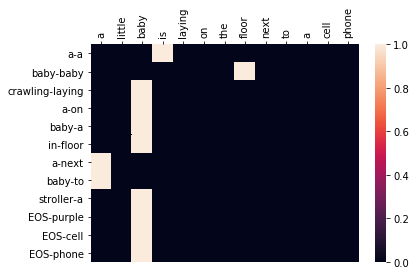

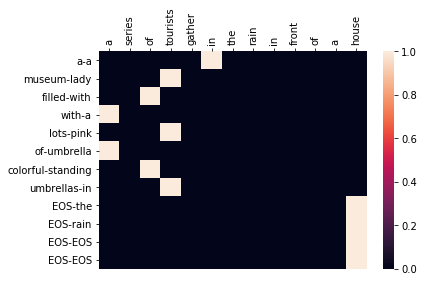

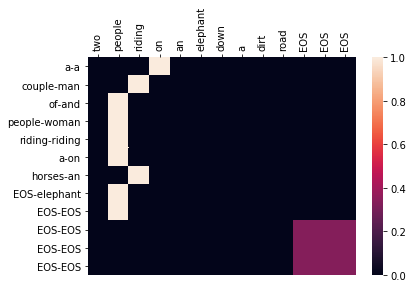

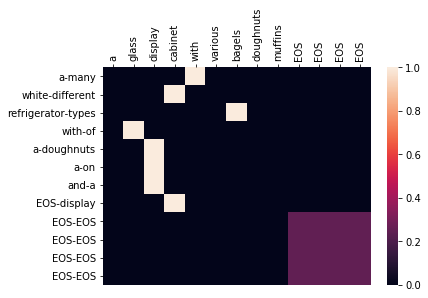

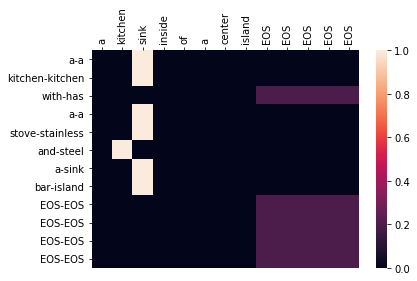



Example 1
INPUT >> a little baby is laying on the floor next to a cell phone
PRED >> a baby crawling a baby in a baby stroller
TRUE >> a baby laying on a floor next to a purple cell phone
[BLEU] 0.08

Example 2
INPUT >> a series of tourists gather in the rain in front of a house
PRED >> a museum filled with lots of colorful umbrellas
TRUE >> a lady with a pink umbrella standing in the rain
[BLEU] 0.05

Example 3
INPUT >> two people riding on an elephant down a dirt road
PRED >> a couple of people riding a horses
TRUE >> a man and woman riding on an elephant
[BLEU] 0.07

Example 4
INPUT >> a glass display cabinet with various bagels doughnuts muffins
PRED >> a white refrigerator with a a and
TRUE >> many different types of doughnuts on a display
[BLEU] 0.06

Example 5
INPUT >> a kitchen sink inside of a center island
PRED >> a kitchen with a stove and a bar
TRUE >> a kitchen has a stainless steel sink island
[BLEU] 0.12

Step 50 average loss = 0.006256 (time: 20.08)
Step 100 average l

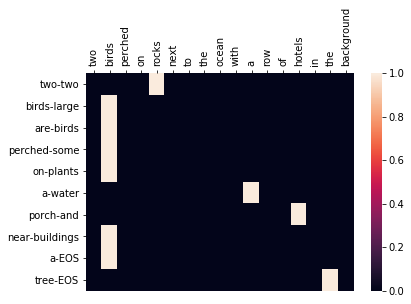

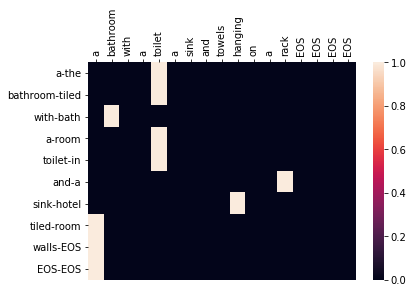

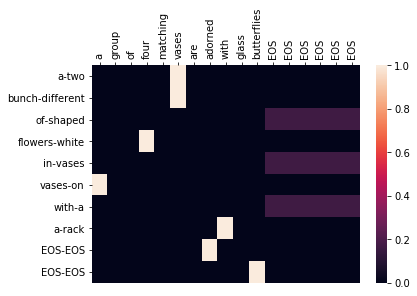

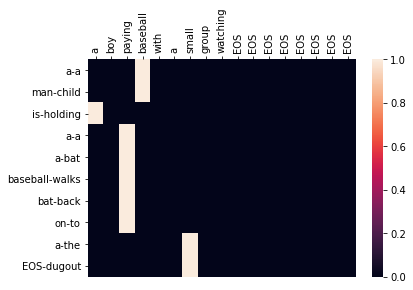

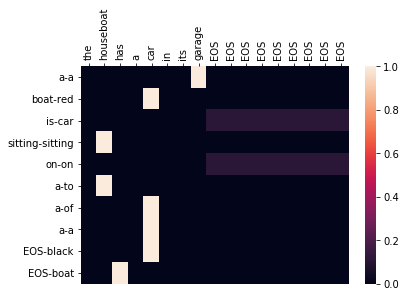



Example 1
INPUT >> two birds perched on rocks next to the ocean with a row of hotels in the background
PRED >> two birds are perched on a porch near a tree
TRUE >> two large birds some plants water and buildings
[BLEU] 0.05

Example 2
INPUT >> a bathroom with a toilet a sink and towels hanging on a rack
PRED >> a bathroom with a toilet and sink tiled walls
TRUE >> the tiled bath room in a hotel room
[BLEU] 0.06

Example 3
INPUT >> a group of four matching vases are adorned with glass butterflies
PRED >> a bunch of flowers in vases with a
TRUE >> two different shaped white vases on a rack
[BLEU] 0.07

Example 4
INPUT >> a boy paying baseball with a small group watching
PRED >> a man is a a baseball bat on a
TRUE >> a child holding a bat walks back to the dugout
[BLEU] 0.06

Example 5
INPUT >> the houseboat has a car in its garage
PRED >> a boat is sitting on a a a
TRUE >> a red car sitting on to of a black boat
[BLEU] 0.11

Step 50 average loss = 0.007955 (time: 20.47)
Step 100 averag

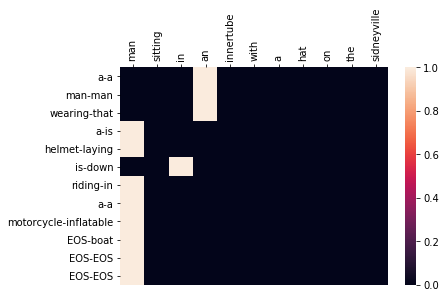

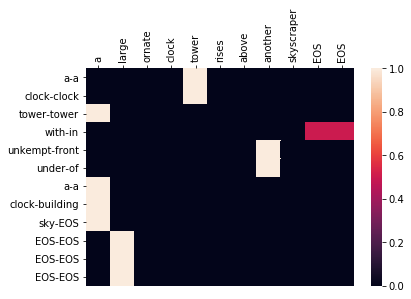

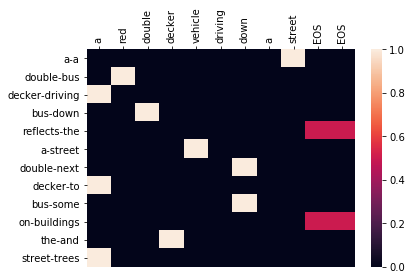

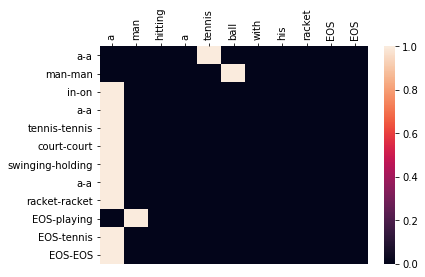

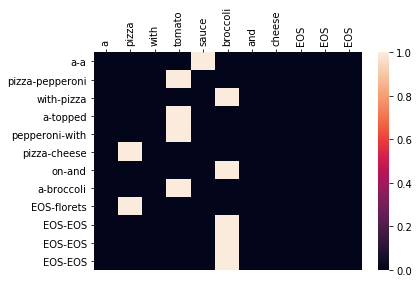



Example 1
INPUT >> man sitting in an innertube with a hat on the sidneyville
PRED >> a man wearing a helmet is riding a motorcycle
TRUE >> a man that is laying down in a inflatable boat
[BLEU] 0.10

Example 2
INPUT >> a large ornate clock tower rises above another skyscraper
PRED >> a clock tower with unkempt under a clock sky
TRUE >> a clock tower in front of a building
[BLEU] 0.19

Example 3
INPUT >> a red double decker vehicle driving down a street
PRED >> a double decker bus reflects a double decker bus on the street
TRUE >> a bus driving down the street next to some buildings and trees
[BLEU] 0.08

Example 4
INPUT >> a man hitting a tennis ball with his racket
PRED >> a man in a tennis court swinging a racket
TRUE >> a man on a tennis court holding a racket playing tennis
[BLEU] 0.21

Example 5
INPUT >> a pizza with tomato sauce broccoli and cheese
PRED >> a pizza with a pepperoni pizza on a
TRUE >> a pepperoni pizza topped with cheese and broccoli florets
[BLEU] 0.19

Step 50 a

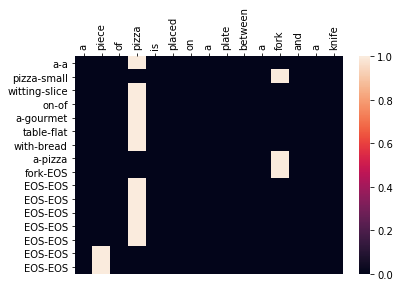

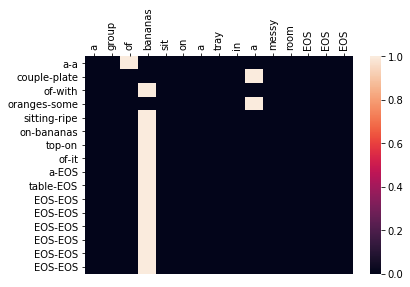

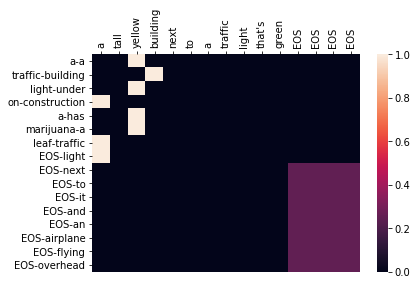

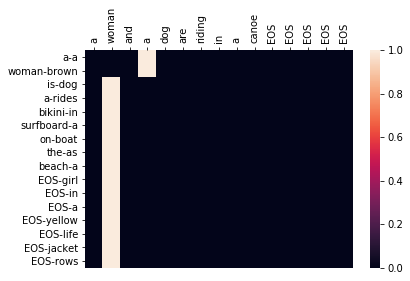

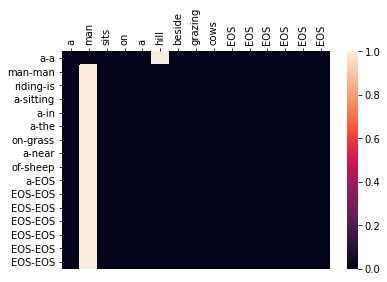



Example 1
INPUT >> a piece of pizza is placed on a plate between a fork and a knife
PRED >> a pizza witting on a table with a fork
TRUE >> a small slice of gourmet flat bread pizza
[BLEU] 0.06

Example 2
INPUT >> a group of bananas sit on a tray in a messy room
PRED >> a couple of oranges sitting on top of a table
TRUE >> a plate with some ripe bananas on it
[BLEU] 0.05

Example 3
INPUT >> a tall yellow building next to a traffic light that's green
PRED >> a traffic light on a marijuana leaf
TRUE >> a building under construction has a traffic light next to it and an airplane flying overhead
[BLEU] 0.07

Example 4
INPUT >> a woman and a dog are riding in a canoe
PRED >> a woman is a bikini surfboard on the beach
TRUE >> a brown dog rides in a boat as a girl in a yellow life jacket rows
[BLEU] 0.03

Example 5
INPUT >> a man sits on a hill beside grazing cows
PRED >> a man riding a a a on a of a
TRUE >> a man is sitting in the grass near sheep
[BLEU] 0.08

Step 50 average loss = 0.01165

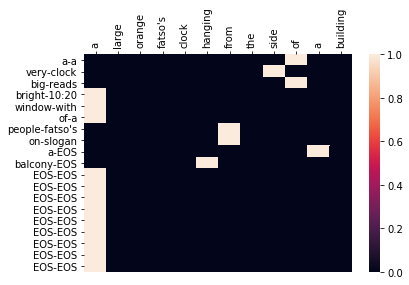

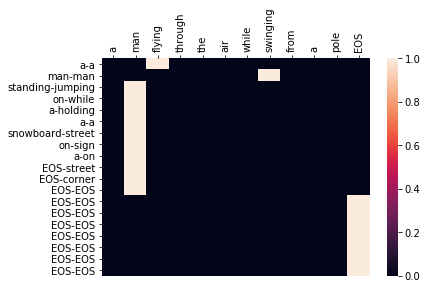

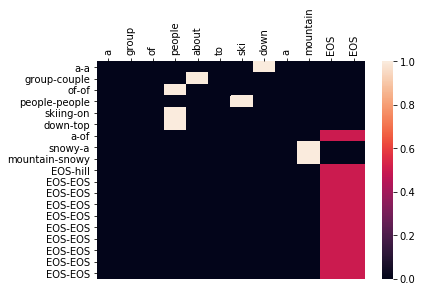

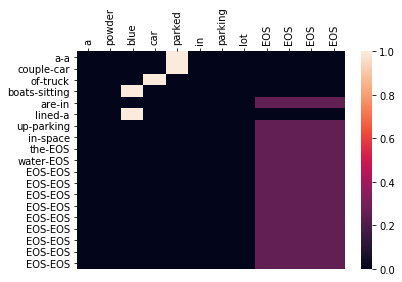

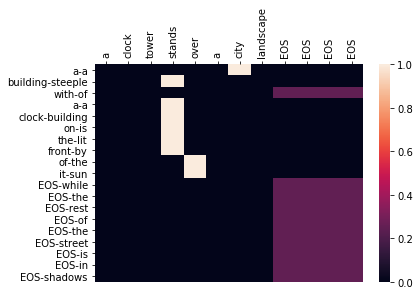



Example 1
INPUT >> a large orange fatso's clock hanging from the side of a building
PRED >> a very big bright window of people on a balcony
TRUE >> a clock reads 10:20 with a fatso's slogan
[BLEU] 0.05

Example 2
INPUT >> a man flying through the air while swinging from a pole
PRED >> a man standing on a a snowboard on a
TRUE >> a man jumping while holding a street sign on street corner
[BLEU] 0.09

Example 3
INPUT >> a group of people about to ski down a mountain
PRED >> a group of people skiing down a snowy mountain
TRUE >> a couple of people on top of a snowy hill
[BLEU] 0.13

Example 4
INPUT >> a powder blue car parked in parking lot
PRED >> a couple of boats are lined up in the water
TRUE >> a car truck sitting in a parking space
[BLEU] 0.05

Example 5
INPUT >> a clock tower stands over a city landscape
PRED >> a building with a clock on the front of it
TRUE >> a steeple of a building is lit by the sun while the rest of the street is in shadows
[BLEU] 0.04

Step 50 average loss 

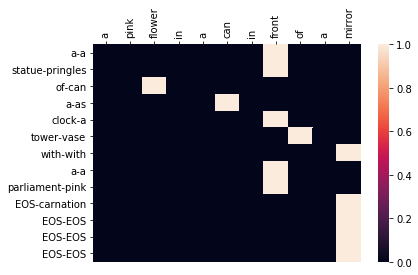

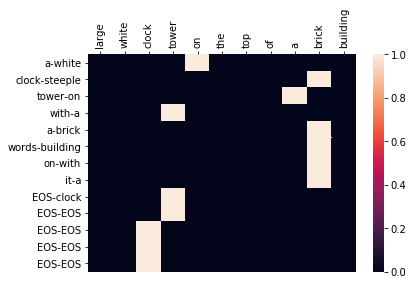

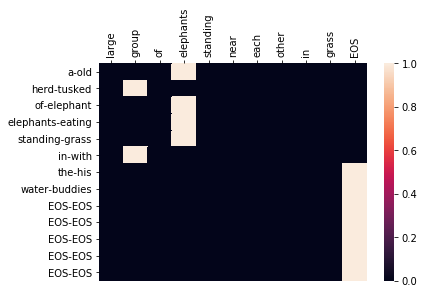

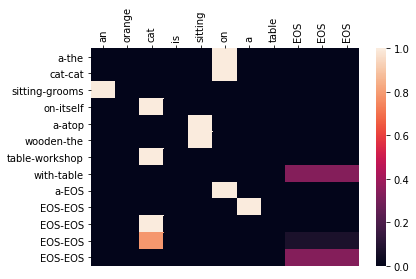

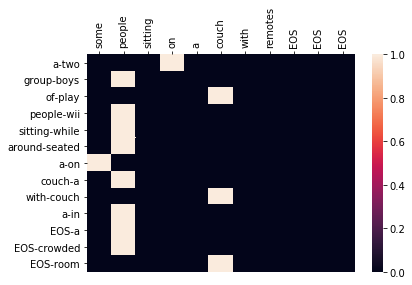



Example 1
INPUT >> a pink flower in a can in front of a mirror
PRED >> a statue of a clock tower with a parliament
TRUE >> a pringles can as a vase with a pink carnation
[BLEU] 0.10

Example 2
INPUT >> large white clock tower on the top of a brick building
PRED >> a clock tower with a words on it
TRUE >> white steeple on a brick building with a clock
[BLEU] 0.15

Example 3
INPUT >> large group of elephants standing near each other in grass
PRED >> a herd of elephants standing in the water
TRUE >> old tusked elephant eating grass with his buddies
[BLEU] 0.00

Example 4
INPUT >> an orange cat is sitting on a table
PRED >> a cat sitting on a wooden table with a
TRUE >> the cat grooms itself atop the workshop table
[BLEU] 0.06

Example 5
INPUT >> some people sitting on a couch with remotes
PRED >> a group of people sitting around a couch with a
TRUE >> two boys play wii while seated on a couch in a crowded room
[BLEU] 0.07

Step 50 average loss = 0.007675 (time: 20.57)
Step 100 average l

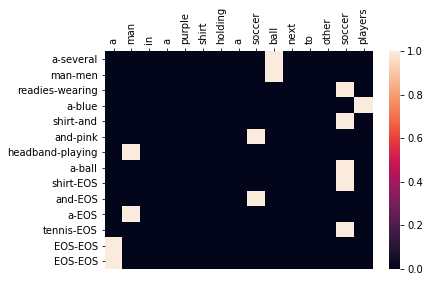

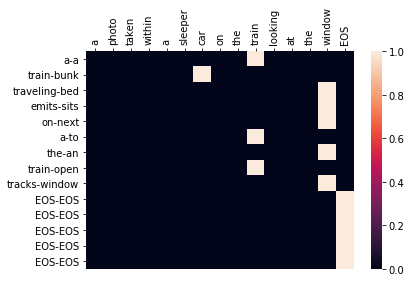

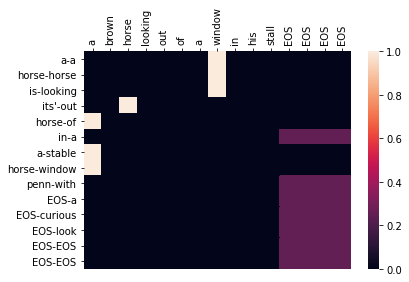

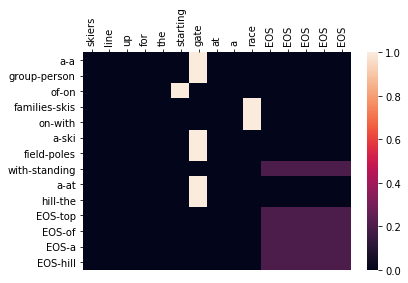

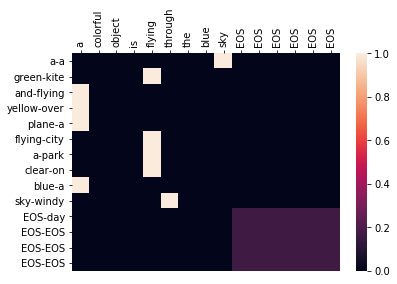



Example 1
INPUT >> a man in a purple shirt holding a soccer ball next to other soccer players
PRED >> a man readies a shirt and headband a shirt and a tennis
TRUE >> several men wearing blue and pink playing ball
[BLEU] 0.03

Example 2
INPUT >> a photo taken within a sleeper car on the train looking at the window
PRED >> a train traveling emits on a the train tracks
TRUE >> a bunk bed sits next to an open window
[BLEU] 0.05

Example 3
INPUT >> a brown horse looking out of a window in his stall
PRED >> a horse is its' horse in a horse penn
TRUE >> a horse looking out of a stable window with a curious look
[BLEU] 0.08

Example 4
INPUT >> skiers line up for the starting gate at a race
PRED >> a group of families on a field with a hill
TRUE >> a person on skis with ski poles standing at the top of a hill
[BLEU] 0.07

Example 5
INPUT >> a colorful object is flying through the blue sky
PRED >> a green and yellow plane flying a clear blue sky
TRUE >> a kite flying over a city park on a wind

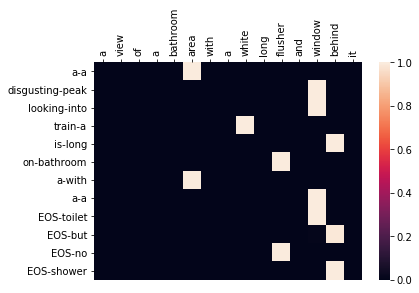

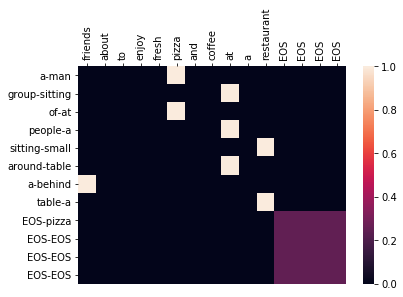

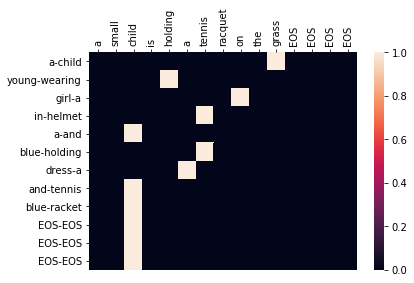

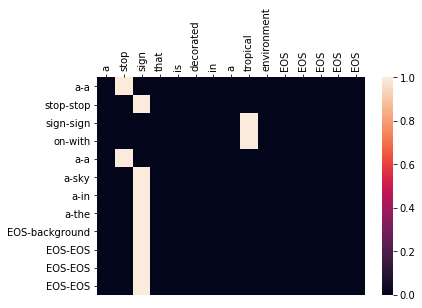

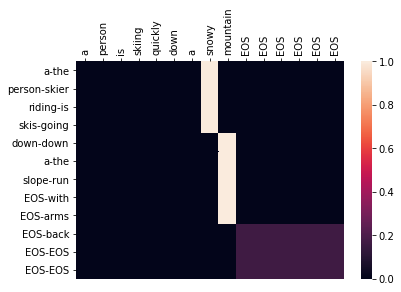



Example 1
INPUT >> a view of a bathroom area with a white long flusher and window behind it
PRED >> a disgusting looking train is on a a
TRUE >> a peak into a long bathroom with a toilet but no shower
[BLEU] 0.04

Example 2
INPUT >> friends about to enjoy fresh pizza and coffee at a restaurant
PRED >> a group of people sitting around a table
TRUE >> man sitting at a small table behind a pizza
[BLEU] 0.07

Example 3
INPUT >> a small child is holding a tennis racquet on the grass
PRED >> a young girl in a blue dress and blue
TRUE >> child wearing a helmet and holding a tennis racket
[BLEU] 0.06

Example 4
INPUT >> a stop sign that is decorated in a tropical environment
PRED >> a stop sign on a a a a
TRUE >> a stop sign with a sky in the background
[BLEU] 0.19

Example 5
INPUT >> a person is skiing quickly down a snowy mountain
PRED >> a person riding skis down a slope
TRUE >> the skier is going down the run with arms back
[BLEU] 0.04

Step 50 average loss = 0.007988 (time: 20.72)
Step 

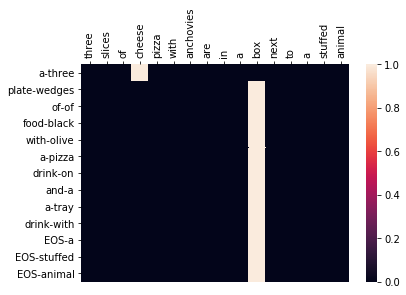

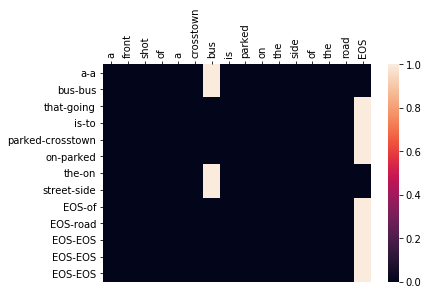

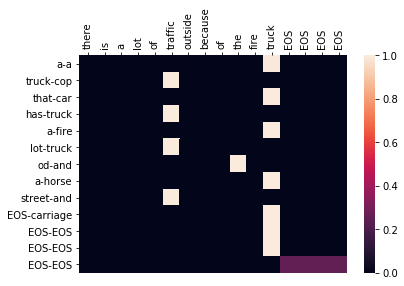

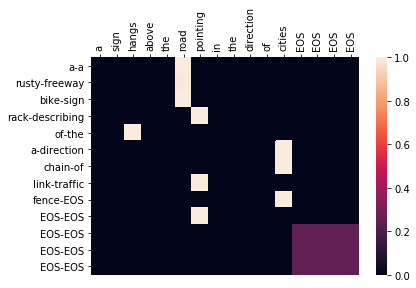

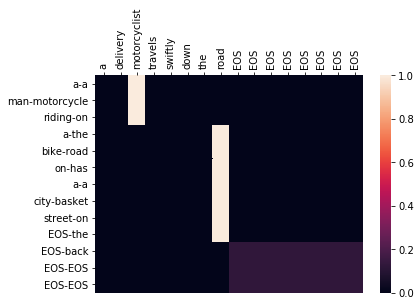



Example 1
INPUT >> three slices of cheese pizza with anchovies are in a box next to a stuffed animal
PRED >> a plate of food with a drink and a drink
TRUE >> three wedges of black olive pizza on a tray with a stuffed animal
[BLEU] 0.07

Example 2
INPUT >> a front shot of a crosstown bus is parked on the side of the road
PRED >> a bus that is parked on the street
TRUE >> a bus going to crosstown parked on side of road
[BLEU] 0.12

Example 3
INPUT >> there is a lot of traffic outside because of the fire truck
PRED >> a truck that has a lot od a street
TRUE >> a cop car truck fire truck and horse and carriage
[BLEU] 0.05

Example 4
INPUT >> a sign hangs above the road pointing in the direction of cities
PRED >> a rusty bike rack of a chain link fence
TRUE >> a freeway sign describing the direction of traffic
[BLEU] 0.06

Example 5
INPUT >> a delivery motorcyclist travels swiftly down the road
PRED >> a man riding a bike on a city street
TRUE >> a motorcycle on the road has a basket on t

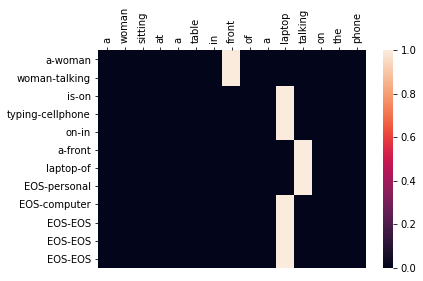

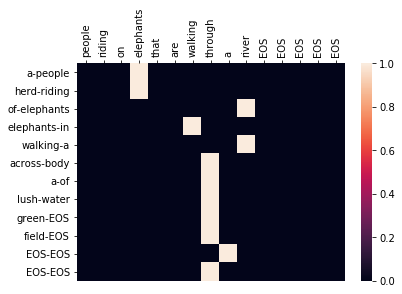

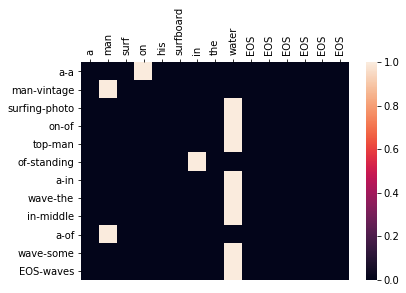

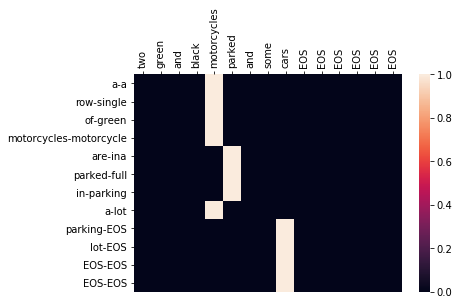

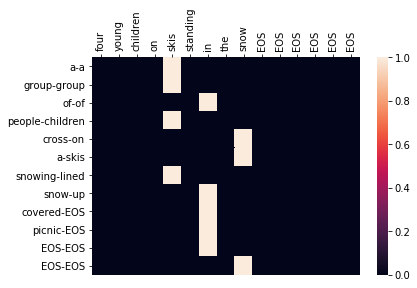



Example 1
INPUT >> a woman sitting at a table in front of a laptop talking on the phone
PRED >> a woman is typing on a laptop
TRUE >> woman talking on cellphone in front of personal computer
[BLEU] 0.06

Example 2
INPUT >> people riding on elephants that are walking through a river
PRED >> a herd of elephants walking across a lush green field
TRUE >> people riding elephants in a body of water
[BLEU] 0.06

Example 3
INPUT >> a man surf on his surfboard in the water
PRED >> a man surfing on top of a wave in a wave
TRUE >> a vintage photo of man standing in the middle of some waves
[BLEU] 0.05

Example 4
INPUT >> two green and black motorcycles parked and some cars
PRED >> a row of motorcycles are parked in a parking lot
TRUE >> a single green motorcycle ina full parking lot
[BLEU] 0.09

Example 5
INPUT >> four young children on skis standing in the snow
PRED >> a group of people cross a snowing snow covered picnic
TRUE >> a group of children on skis lined up
[BLEU] 0.16

Step 50 averag

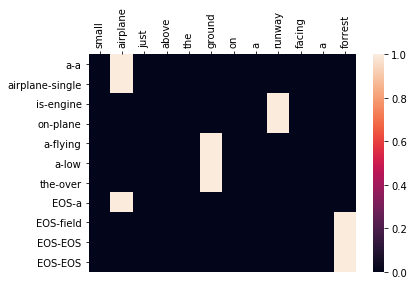

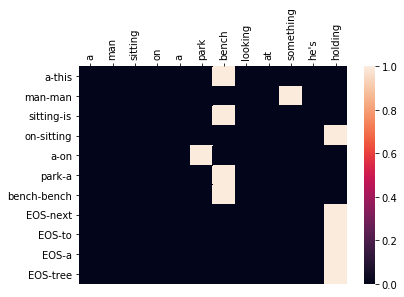

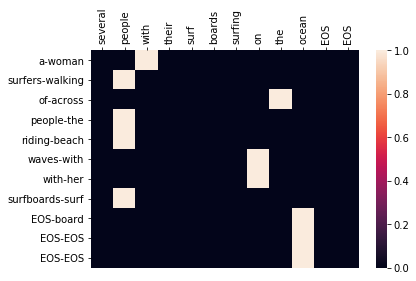

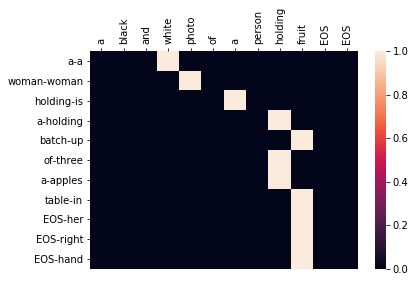

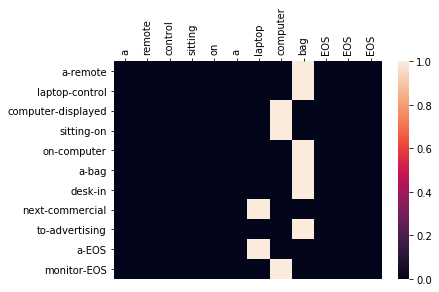



Example 1
INPUT >> small airplane just above the ground on a runway facing a forrest
PRED >> a airplane is on a a the
TRUE >> a single engine plane flying low over a field
[BLEU] 0.06

Example 2
INPUT >> a man sitting on a park bench looking at something he's holding
PRED >> a man sitting on a park bench
TRUE >> this man is sitting on a bench next to a tree
[BLEU] 0.16

Example 3
INPUT >> several people with their surf boards surfing on the ocean
PRED >> a surfers of people riding waves with surfboards
TRUE >> woman walking across the beach with her surf board
[BLEU] 0.05

Example 4
INPUT >> a black and white photo of a person holding fruit
PRED >> a woman holding a batch of a table
TRUE >> a woman is holding up three apples in her right hand
[BLEU] 0.08

Example 5
INPUT >> a remote control sitting on a laptop computer bag
PRED >> a laptop computer sitting on a desk next to a monitor
TRUE >> remote control displayed on computer bag in commercial advertising
[BLEU] 0.04

Step 50 avera

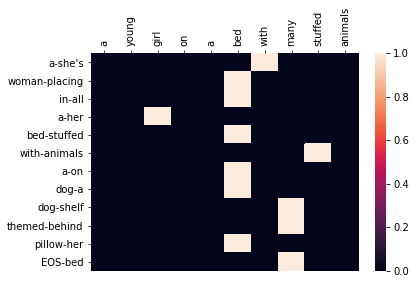

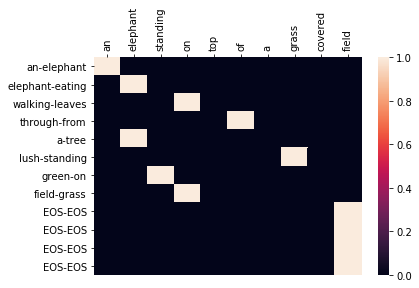

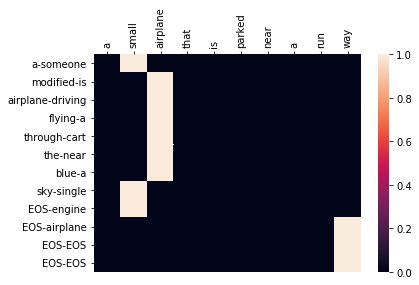

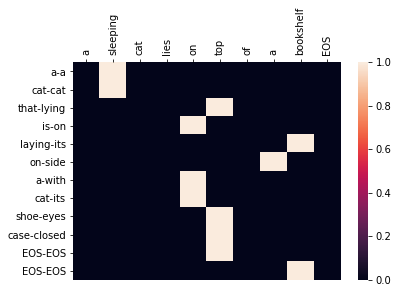

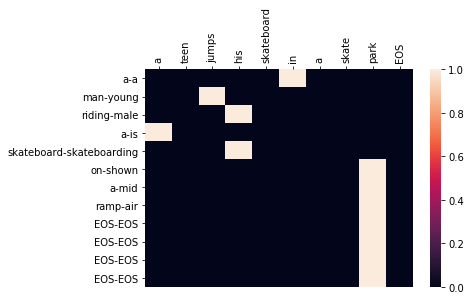



Example 1
INPUT >> a young girl on a bed with many stuffed animals
PRED >> a woman in a bed with a dog dog themed pillow
TRUE >> she's placing all her stuffed animals on a shelf behind her bed
[BLEU] 0.04

Example 2
INPUT >> an elephant standing on top of a grass covered field
PRED >> an elephant walking through a lush green field
TRUE >> elephant eating leaves from tree standing on grass
[BLEU] 0.06

Example 3
INPUT >> a small airplane that is parked near a run way
PRED >> a modified airplane flying through the blue sky
TRUE >> someone is driving a cart near a single engine airplane
[BLEU] 0.05

Example 4
INPUT >> a sleeping cat lies on top of a bookshelf
PRED >> a cat that is laying on a cat shoe case
TRUE >> a cat lying on its side with its eyes closed
[BLEU] 0.09

Example 5
INPUT >> a teen jumps his skateboard in a skate park
PRED >> a man riding a skateboard on a ramp
TRUE >> a young male is skateboarding shown mid air
[BLEU] 0.06

Step 50 average loss = 0.007480 (time: 20.96)
S

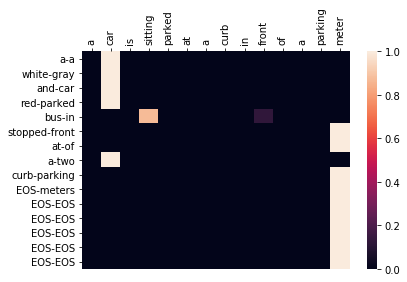

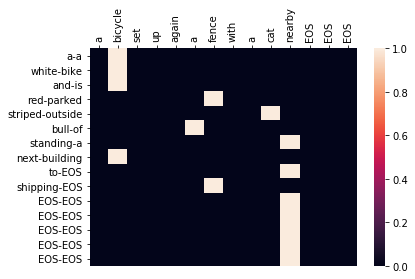

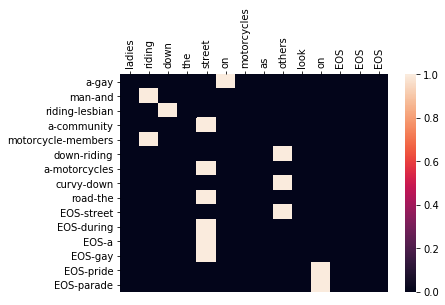

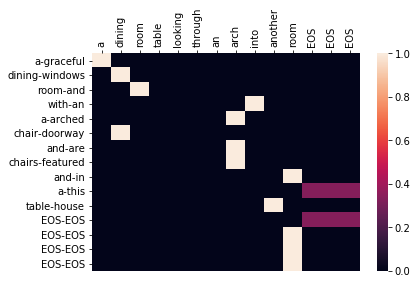

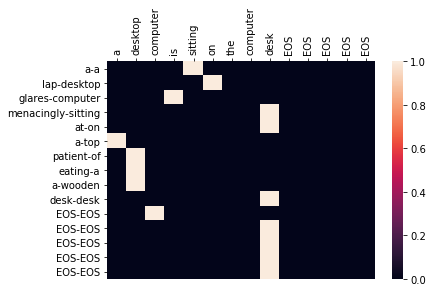



Example 1
INPUT >> a car is sitting parked at a curb in front of a parking meter
PRED >> a white and red bus stopped at a curb
TRUE >> a gray car parked in front of two parking meters
[BLEU] 0.04

Example 2
INPUT >> a bicycle set up again a fence with a cat nearby
PRED >> a white and red striped bull standing next to shipping
TRUE >> a bike is parked outside of a building
[BLEU] 0.04

Example 3
INPUT >> ladies riding down the street on motorcycles as others look on
PRED >> a man riding a motorcycle down a curvy road
TRUE >> gay and lesbian community members riding motorcycles down the street during a gay pride parade
[BLEU] 0.03

Example 4
INPUT >> a dining room table looking through an arch into another room
PRED >> a dining room with a chair and chairs and a table
TRUE >> graceful windows and an arched doorway are featured in this house
[BLEU] 0.04

Example 5
INPUT >> a desktop computer is sitting on the computer desk
PRED >> a lap glares menacingly at a patient eating a desk
TRUE 

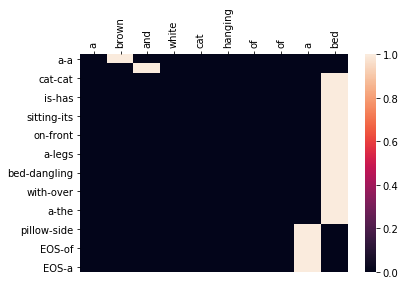

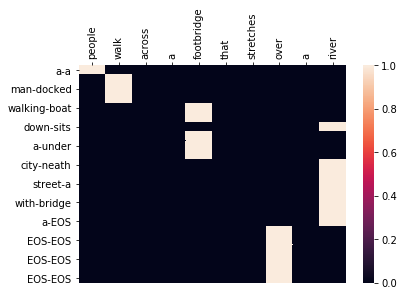

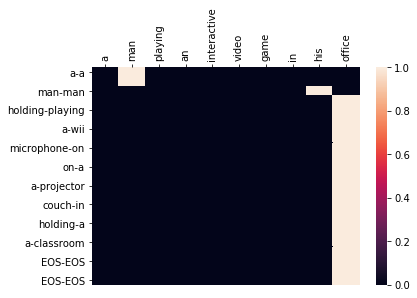

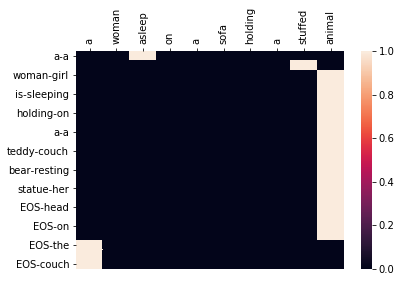

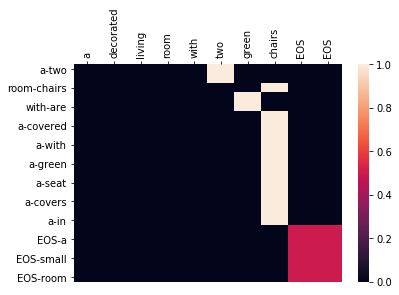



Example 1
INPUT >> a brown and white cat hanging of of a bed
PRED >> a cat is sitting on a bed with a pillow
TRUE >> a cat has its front legs dangling over the side of a bed
[BLEU] 0.09

Example 2
INPUT >> people walk across a footbridge that stretches over a river
PRED >> a man walking down a city street with a
TRUE >> a docked boat sits under neath a bridge
[BLEU] 0.06

Example 3
INPUT >> a man playing an interactive video game in his office
PRED >> a man holding a microphone on a couch holding a
TRUE >> a man playing wii on a projector in a classroom
[BLEU] 0.13

Example 4
INPUT >> a woman asleep on a sofa holding a stuffed animal
PRED >> a woman is holding a teddy bear statue
TRUE >> a girl sleeping on a couch resting her head on the couch armrest
[BLEU] 0.04

Example 5
INPUT >> a decorated living room with two green chairs
PRED >> a room with a a a a a a
TRUE >> two chairs are covered with green seat covers in a small room that also features a a dark wood table and two chairs
[B

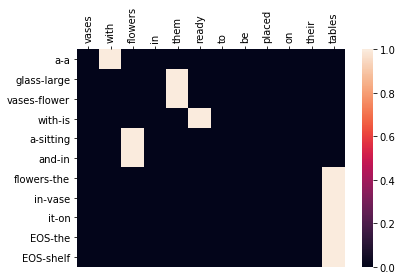

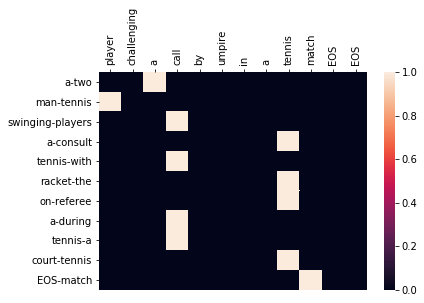

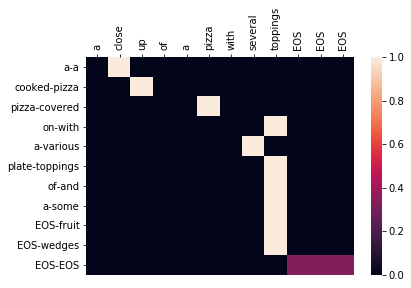

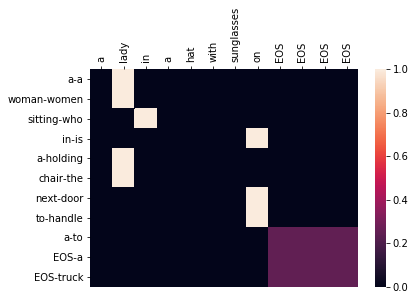

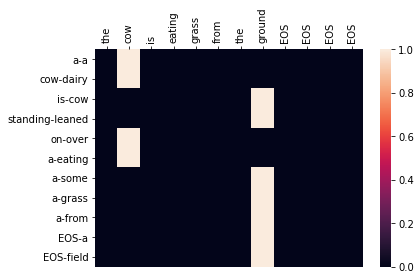



Example 1
INPUT >> vases with flowers in them ready to be placed on their tables
PRED >> a glass vases with a and flowers in it
TRUE >> a large flower is sitting in the vase on the shelf
[BLEU] 0.05

Example 2
INPUT >> player challenging a call by umpire in a tennis match
PRED >> a man swinging a tennis racket on a tennis court
TRUE >> two tennis players consult with the referee during a tennis match
[BLEU] 0.08

Example 3
INPUT >> a close up of a pizza with several toppings
PRED >> a cooked pizza on a plate of a
TRUE >> a pizza covered with various toppings and some fruit wedges
[BLEU] 0.05

Example 4
INPUT >> a lady in a hat with sunglasses on
PRED >> a woman sitting in a chair next to a
TRUE >> a women who is holding the door handle to a truck
[BLEU] 0.08

Example 5
INPUT >> the cow is eating grass from the ground
PRED >> a cow is standing on a a a a
TRUE >> a dairy cow leaned over eating some grass from a field
[BLEU] 0.05

Step 50 average loss = 0.004910 (time: 20.62)
Step 100 a

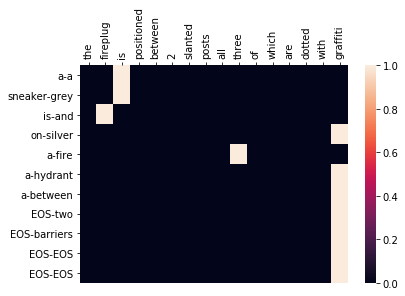

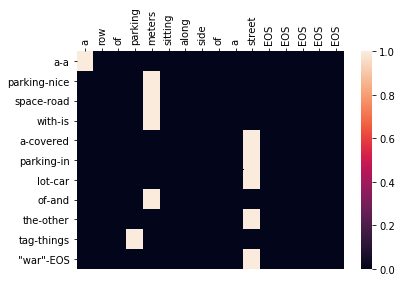

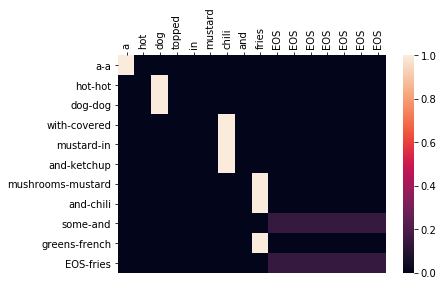

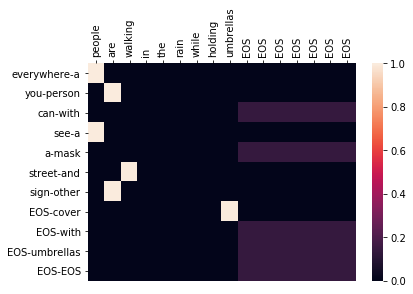

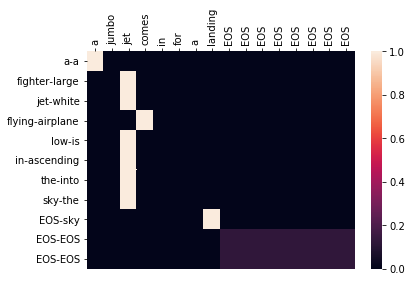



Example 1
INPUT >> the fireplug is positioned between 2 slanted posts all three of which are dotted with graffiti
PRED >> a sneaker is on a a a
TRUE >> a grey and silver fire hydrant between two barriers
[BLEU] 0.05

Example 2
INPUT >> a row of parking meters sitting along side of a street
PRED >> a parking space with a parking lot of the tag "war"
TRUE >> a nice road is covered in car and other things
[BLEU] 0.04

Example 3
INPUT >> a hot dog topped in mustard chili and fries
PRED >> a hot dog with mustard and mushrooms and some greens
TRUE >> a hot dog covered in ketchup mustard chili and french fries
[BLEU] 0.16

Example 4
INPUT >> people are walking in the rain while holding umbrellas
PRED >> everywhere you can see a street sign
TRUE >> a person with a mask and other cover with umbrellas
[BLEU] 0.04

Example 5
INPUT >> a jumbo jet comes in for a landing
PRED >> a fighter jet flying low in the sky
TRUE >> a large white airplane is ascending into the sky
[BLEU] 0.11

Step 50 averag

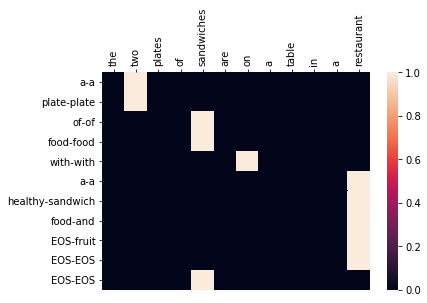

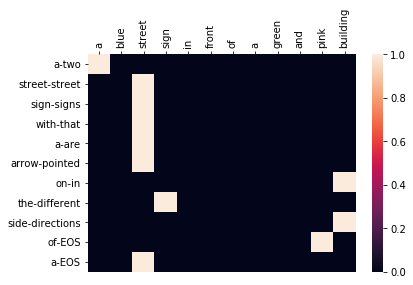

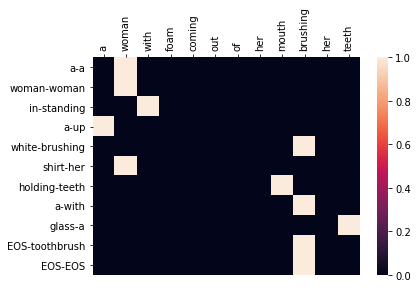

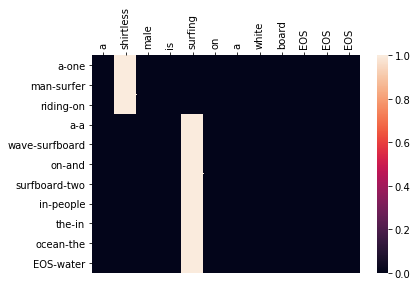

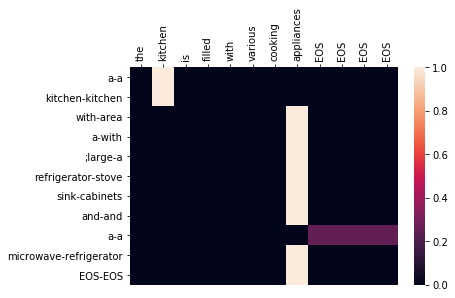



Example 1
INPUT >> the two plates of sandwiches are on a table in a restaurant
PRED >> a plate of food with a healthy food
TRUE >> a plate of food with a sandwich and fruit
[BLEU] 0.60

Example 2
INPUT >> a blue street sign in front of a green and pink building
PRED >> a street sign with a arrow on the side of a
TRUE >> two street signs that are pointed in different directions
[BLEU] 0.04

Example 3
INPUT >> a woman with foam coming out of her mouth brushing her teeth
PRED >> a woman in a white shirt holding a glass
TRUE >> a woman standing up brushing her teeth with a toothbrush
[BLEU] 0.09

Example 4
INPUT >> a shirtless male is surfing on a white board
PRED >> a man riding a wave on surfboard in the ocean
TRUE >> one surfer on a surfboard and two people in the water
[BLEU] 0.10

Example 5
INPUT >> the kitchen is filled with various cooking appliances
PRED >> a kitchen with a ;large refrigerator sink and a microwave
TRUE >> a kitchen area with a stove cabinets and a refrigerator
[B

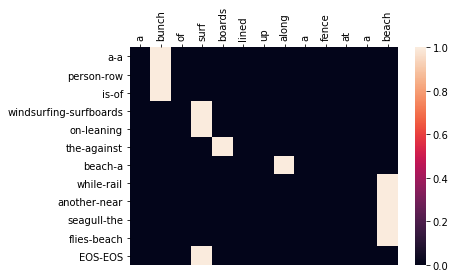

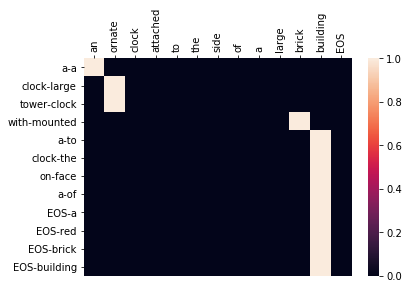

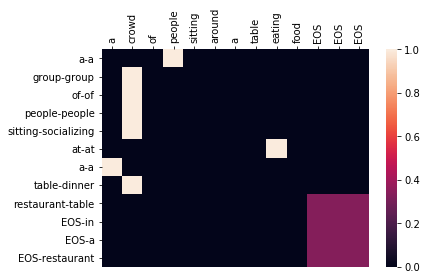

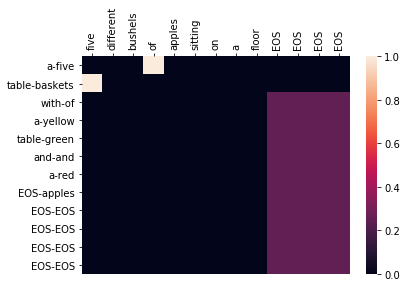

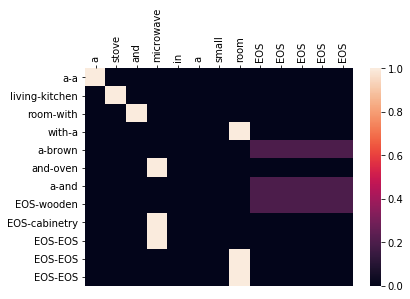



Example 1
INPUT >> a bunch of surf boards lined up along a fence at a beach
PRED >> a person is windsurfing on the beach while another seagull flies
TRUE >> a row of surfboards leaning against a rail near the beach
[BLEU] 0.08

Example 2
INPUT >> an ornate clock attached to the side of a large brick building
PRED >> a clock tower with a clock on a
TRUE >> a large clock mounted to the face of a red brick building
[BLEU] 0.04

Example 3
INPUT >> a crowd of people sitting around a table eating food
PRED >> a group of people sitting at a table restaurant
TRUE >> a group of people socializing at a dinner table in a restaurant
[BLEU] 0.27

Example 4
INPUT >> five different bushels of apples sitting on a floor
PRED >> a table with a table and a
TRUE >> five baskets of yellow green and red apples
[BLEU] 0.06

Example 5
INPUT >> a stove and microwave in a small room
PRED >> a living room with a and a
TRUE >> a kitchen with a brown oven and wooden cabinetry
[BLEU] 0.12

Step 50 average loss = 

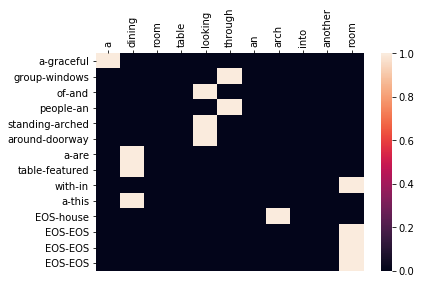

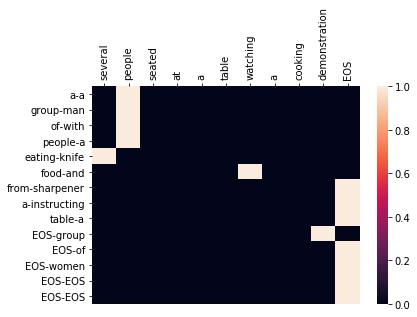

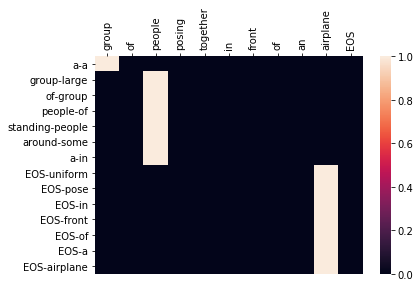

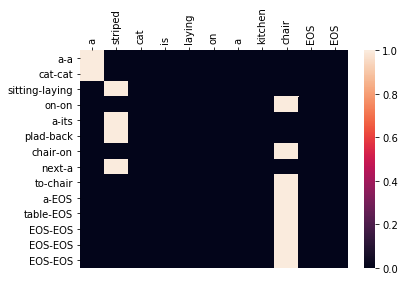

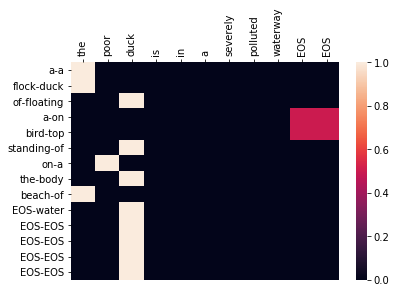



Example 1
INPUT >> a dining room table looking through an arch into another room
PRED >> a group of people standing around a table with a
TRUE >> graceful windows and an arched doorway are featured in this house
[BLEU] 0.00

Example 2
INPUT >> several people seated at a table watching a cooking demonstration
PRED >> a group of people eating food from a table
TRUE >> a man with a knife and sharpener instructing a group of women
[BLEU] 0.14

Example 3
INPUT >> group of people posing together in front of an airplane
PRED >> a group of people standing around a
TRUE >> a large group of people some in uniform pose in front of a airplane
[BLEU] 0.10

Example 4
INPUT >> a striped cat is laying on a kitchen chair
PRED >> a cat sitting on a plad chair next to a table
TRUE >> a cat laying on its back on a chair
[BLEU] 0.11

Example 5
INPUT >> the poor duck is in a severely polluted waterway
PRED >> a flock of a bird standing on the beach
TRUE >> a duck floating on top of a body of water
[BLEU] 

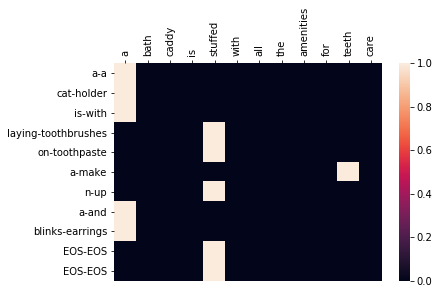

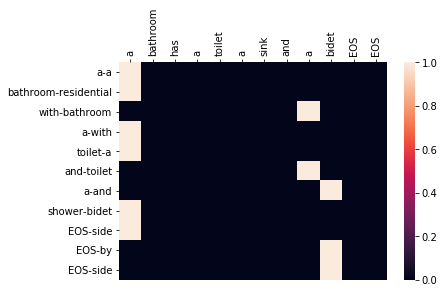

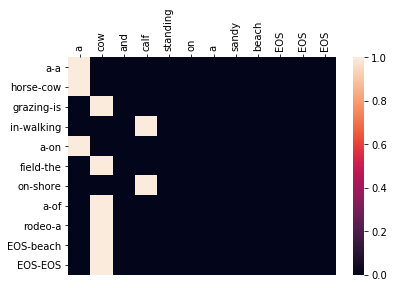

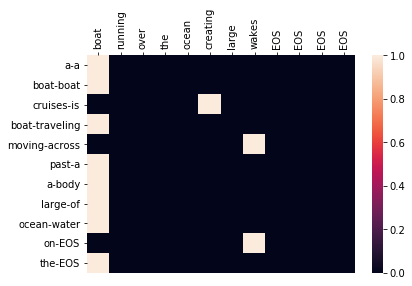

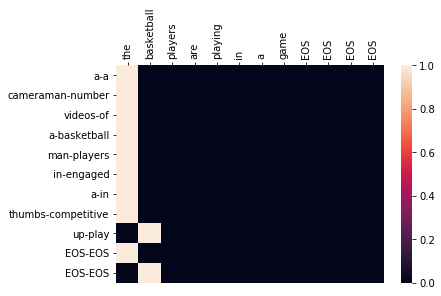



Example 1
INPUT >> a bath caddy is stuffed with all the amenities for teeth care
PRED >> a cat is laying on a n a blinks
TRUE >> a holder with toothbrushes toothpaste make up and earrings
[BLEU] 0.05

Example 2
INPUT >> a bathroom has a toilet a sink and a bidet
PRED >> a bathroom with a toilet and a shower
TRUE >> a residential bathroom with a toilet and bidet side by side
[BLEU] 0.37

Example 3
INPUT >> a cow and calf standing on a sandy beach
PRED >> a horse grazing in a field on a rodeo
TRUE >> a cow is walking on the shore of a beach
[BLEU] 0.06

Example 4
INPUT >> boat running over the ocean creating large wakes
PRED >> a boat cruises boat moving past a large ocean on the
TRUE >> a boat is traveling across a body of water
[BLEU] 0.08

Example 5
INPUT >> the basketball players are playing in a game
PRED >> a cameraman videos a man in a thumbs up
TRUE >> a number of basketball players engaged in competitive play
[BLEU] 0.06

Step 50 average loss = 0.012808 (time: 20.18)
Step 100 

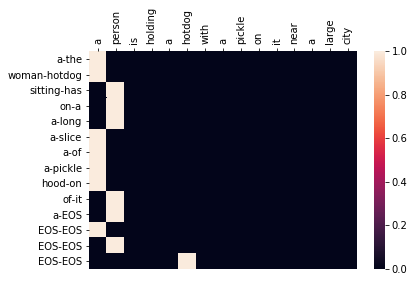

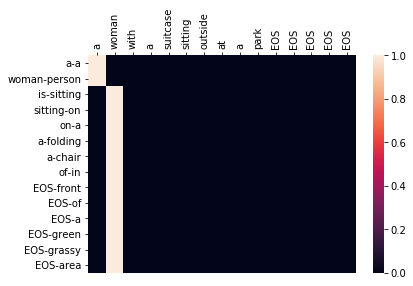

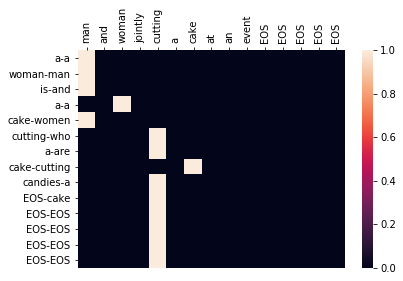

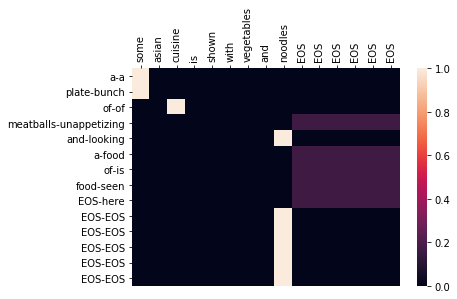

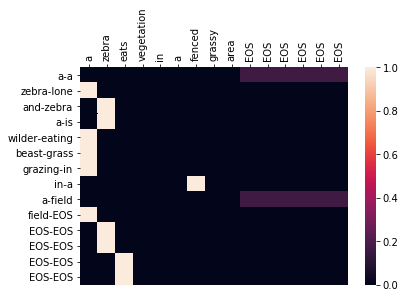



Example 1
INPUT >> a person is holding a hotdog with a pickle on it near a large city
PRED >> a woman sitting on a a a a hood of a
TRUE >> the hotdog has a long slice of pickle on it
[BLEU] 0.05

Example 2
INPUT >> a woman with a suitcase sitting outside at a park
PRED >> a woman is sitting on a a of
TRUE >> a person sitting on a folding chair in front of a green grassy area
[BLEU] 0.12

Example 3
INPUT >> man and woman jointly cutting a cake at an event
PRED >> a woman is a cake cutting a cake candies
TRUE >> a man and a women who are cutting a cake
[BLEU] 0.18

Example 4
INPUT >> some asian cuisine is shown with vegetables and noodles
PRED >> a plate of meatballs and a of food
TRUE >> a bunch of unappetizing looking food is seen here
[BLEU] 0.06

Example 5
INPUT >> a zebra eats vegetation in a fenced grassy area
PRED >> a zebra and a wilder beast grazing in a field
TRUE >> a lone zebra is eating grass in a field
[BLEU] 0.18

Step 50 average loss = 0.006398 (time: 20.51)
Step 100 av

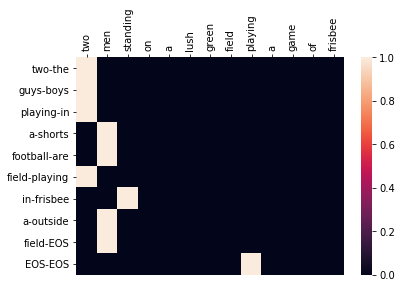

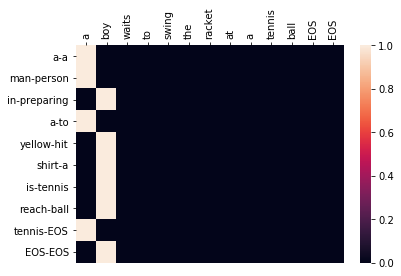

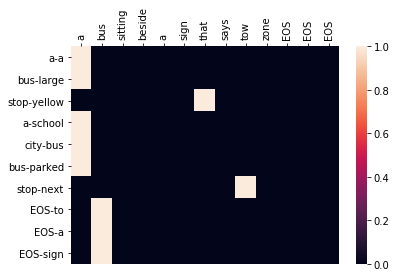

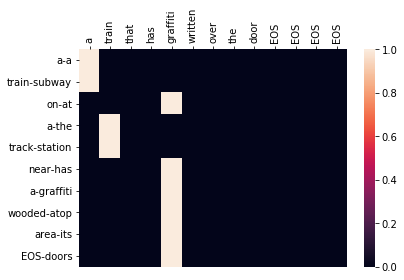

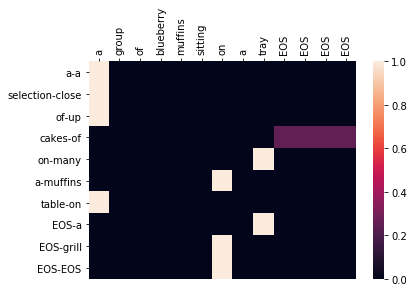



Example 1
INPUT >> two men standing on a lush green field playing a game of frisbee
PRED >> two guys playing a football field in a field
TRUE >> the boys in shorts are playing frisbee outside
[BLEU] 0.06

Example 2
INPUT >> a boy waits to swing the racket at a tennis ball
PRED >> a man in a yellow shirt is reach tennis
TRUE >> a person preparing to hit a tennis ball
[BLEU] 0.06

Example 3
INPUT >> a bus sitting beside a sign that says tow zone
PRED >> a bus stop a city bus stop
TRUE >> a large yellow school bus parked next to a sign
[BLEU] 0.06

Example 4
INPUT >> a train that has graffiti written over the door
PRED >> a train on a track near a wooded area
TRUE >> a subway at the station has graffiti atop its doors
[BLEU] 0.04

Example 5
INPUT >> a group of blueberry muffins sitting on a tray
PRED >> a selection of cakes on a table
TRUE >> a close up of many muffins on a grill
[BLEU] 0.12

Average BLEU score over 1600 examples is 0.0871


In [8]:
s2s = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens,
              attentionType='luong',
              batchSize=32, embeddingSize=300, hiddenSize=512,
              nLayers=2, dropout=0.1, residual=True, bidirectional=True,
              lr=1e-3, enforcingRatio=0.8, clip=20.0, gloveInit=embeddings)
s2s.train(nEpochs=100, epochSize=1000, printEvery=50)
s2s.evaluate(nBatches=50, saveResults=True)
torch.save(s2s, 'mscoco/seq2seq.ckpt')